# 利用智能优化算法优化神经网络参数

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import sys
path = 'D:/Jupyter notebook/src/01.python/05.application/03.optimization/models' #智能优化算法所在文件夹
sys.path.insert(0, path)

## 数据准备

In [3]:
# 读取数据
def loader(data_path=None, data=None, time_col=None, datetime=None, freq=None):
    """
    读取数据，并对输入数据时间列进行处理

    参数说明
    ----------
    data_path : {str}
        输入数据地址，如果为空，读取已有数据
    data : {DataFrame} of shape (n_samples, n_features)
        输入数据，如果需读取本地数据，将该值置空，否则传入已有数据
    time_col : {str}
        输入数据的时间列，如果没有时间列，生成时间戳范围，或者生成固定频率的时间戳数据
    datetime : {str} 
        时间列开始时间，如果time_col为空，需填入此项，格式为%Y-%m-%d %H:%M:%S
    freq : {int}
        时间序列频率，单位为秒

    返回值
    -------
    data : {DataFrame} of shape (n_samples, n_features)
        经过时间序列处理后的数据
    """
    # 读取原始数据
    if data_path == None:
        if data.empty is True:
            raise ValueError("data is not exist!")
        else:
            data = data
    else:
        data = pd.read_csv(data_path)

    # 时间列处理
    if time_col == None:
        # 筛选输入频率
        re_1 = re.findall('[0-9]', freq)
        re_2 = re.findall('[a-z]', freq)
        # 识别数字频率
        if len(re_1) == 0:
            nums = 1
        else:
            nums = int(''.join(re_1))
        # 识别频率
        fr = re_2[0]
        # 生成时间间隔
        if fr == 's':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           seconds=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 't':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           minutes=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'h':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           hours=(data.shape[0] - 1)*nums),
                                       freq=freq)
        elif fr == 'd':
            time_index = pd.date_range(start=pd.to_datetime(datetime),
                                       end=pd.to_datetime(datetime) +
                                       timedelta(
                                           days=(data.shape[0] - 1)*nums),
                                       freq=freq)
        full_data = pd.DataFrame(data=data.values,
                                 index=pd.to_datetime(time_index, unit=freq),
                                 columns=data.columns)
    else:
        columns = [i for i in data.columns if i != time_col]  # 去除时间列
        full_data = pd.DataFrame(data=data.drop([time_col], axis=1).values,
                                 index=pd.to_datetime(data[time_col].values),
                                 columns=columns)
    return full_data

In [5]:
data_path = "../data/energy.csv"
ts_data = loader(data_path=data_path, data=None, time_col='time')
ts_data

,load,temp
2012-01-01 00:00:00,2698.0,32.00
2012-01-01 01:00:00,2558.0,32.67
2012-01-01 02:00:00,2444.0,30.00
2012-01-01 03:00:00,2402.0,31.00
2012-01-01 04:00:00,2403.0,32.00
...,...,...
2014-12-31 19:00:00,4012.0,18.00
2014-12-31 20:00:00,3856.0,16.67
2014-12-31 21:00:00,3671.0,17.00
2014-12-31 22:00:00,3499.0,15.33


In [6]:
# 时间格式编码
def time_features_from_frequency_str(freq_str: str):
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    class TimeFeature:
        def __init__(self):
            pass

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            pass

        def __repr__(self):
            return self.__class__.__name__ + "()"


    class SecondOfMinute(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.second / 59.0 - 0.5


    class MinuteOfHour(TimeFeature):
        """Minute of hour encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.minute / 59.0 - 0.5


    class HourOfDay(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.hour / 23.0 - 0.5


    class DayOfWeek(TimeFeature):
        """Hour of day encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return index.dayofweek / 6.0 - 0.5


    class DayOfMonth(TimeFeature):
        """Day of month encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.day - 1) / 30.0 - 0.5


    class DayOfYear(TimeFeature):
        """Day of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.dayofyear - 1) / 365.0 - 0.5


    class MonthOfYear(TimeFeature):
        """Month of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.month - 1) / 11.0 - 0.5


    class WeekOfYear(TimeFeature):
        """Week of year encoded as value between [-0.5, 0.5]"""

        def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
            return (index.isocalendar().week - 1) / 52.0 - 0.5

    
    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)
    
def time_features(dates, freq='h'):
    return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)])

In [7]:
# 数据集划分
def divider(df, train_ratio, valid_ratio, x_feature_list, y_feature_list, freq, scaler_path):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    train_ratio : {float}
        用于训练的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    valid_ratio : {float}
        用于验证的数据集占比:将数据按照一定比例进行切分，取值范围为(0,1)
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    y_feature_list : {list[str]} 
        目标特征列，不包含时间列
    freq : {str}
        用来编码时间特征的频率，可选[s:秒,t:分,h:时,d:天,b:工作日,w:周,m:月]，频率越低，模型可能越精确
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    y_scaler : {sklearn.preprocessing.MinMaxScaler}
        目标特征列归一化器
    train : {list[DataFrame]}
        训练特征数据，目标特征数据，时间特征数据
    valid : {list[DataFrame]}
        验证特征数据，目标特征数据，时间特征数据
    test : {list[DataFrame]}
        测试特征数据，目标特征数据，时间特征数据
    """
    # 归一化
    x_scaler = MinMaxScaler()  # 保证数据同分布
    y_scaler = MinMaxScaler()
    x_scaler = x_scaler.fit(df.copy()[x_feature_list])
    y_scaler = y_scaler.fit(df.copy()[y_feature_list])

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")
    joblib.dump(y_scaler, scaler_path + "/y_scaler.pkl")

    # 测试集
    train = df.copy().iloc[:int(df.shape[0]*train_ratio), :][x_feature_list]
    train_stamp = time_features(pd.to_datetime(train.index), freq=freq)
    train_stamp = train_stamp.transpose(1, 0)
    train[x_feature_list] = x_scaler.transform(train)
    xtr = train.values.astype('float32')
    ytr = df.copy().iloc[:int(df.shape[0]*train_ratio), :][y_feature_list]
    ytr[y_feature_list] = y_scaler.transform(ytr)
    ytr = ytr.values.astype('float32')
    train = [xtr, ytr, train_stamp]

    # 验证集
    if train_ratio != 1:
        valid = df.copy().iloc[int(df.shape[0]*train_ratio)
                        : int(df.shape[0]*(train_ratio+valid_ratio)), :][x_feature_list]
        valid_stamp = time_features(pd.to_datetime(valid.index), freq=freq)
        valid_stamp = valid_stamp.transpose(1, 0)
        valid[x_feature_list] = x_scaler.transform(valid)
        xva = valid.values.astype('float32')
        yva = df.copy().iloc[int(df.shape[0]*train_ratio)
                      : int(df.shape[0]*(train_ratio+valid_ratio)), :][y_feature_list]
        yva[y_feature_list] = y_scaler.transform(yva)
        yva = yva.values.astype('float32')
        valid = [xva, yva, valid_stamp]
    else:
        valid = [np.array(0), np.array(0), np.array(0)]

    # 测试集
    if train_ratio + valid_ratio != 1:
        test = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][x_feature_list]
        test_stamp = time_features(pd.to_datetime(test.index), freq=freq)
        test_stamp = test_stamp.transpose(1, 0)
        test[x_feature_list] = x_scaler.transform(test)
        xte = test.values.astype('float32')
        yte = df.copy().iloc[int(
            df.shape[0]*(train_ratio+valid_ratio)):, :][y_feature_list]
        yte[y_feature_list] = y_scaler.transform(yte)
        yte = yte.values.astype('float32')
        test = [xte, yte, test_stamp]
    else:
        test = [np.array(0), np.array(0), np.array(0)]

    return x_scaler, y_scaler, train, valid, test

In [9]:
# 构造参数字典
params1 = {
    "df": ts_data,
    "train_ratio": 0.7,
    "valid_ratio": 0.1,
    "x_feature_list": ['load', 'temp'],
    "y_feature_list": ['load', 'temp'],
    "freq": 'h',
    "scaler_path": '../outputs/scalers/DLinear_opt'
}

# 函数传参
x_scaler, y_scaler, train_data, valid_data, test_data = divider(**params1)
print("x_train shape: {0} y_train shape: {1} stamp_train shape: {2}".format(
    train_data[0].shape, train_data[1].shape, train_data[2].shape))
print("x_valid shape: {0} y_valid shape: {1} stamp_valid shape: {2}".format(
    valid_data[0].shape, valid_data[1].shape, valid_data[2].shape))
print("x_test shape: {0} y_test shape: {1} stamp_test shape: {2}".format(
    test_data[0].shape, test_data[1].shape, test_data[2].shape))

x_train shape: (18412, 2) y_train shape: (18412, 2) stamp_train shape: (18412, 4)
x_valid shape: (2631, 2) y_valid shape: (2631, 2) stamp_valid shape: (2631, 4)
x_test shape: (5261, 2) y_test shape: (5261, 2) stamp_test shape: (5261, 4)


In [10]:
# 利用前seq_len个数据，预测下pred_len个数据
def generator(data_list, seq_len, pred_len, label_len, batch_size, sample_freq: int = 1):
    """
    读取数据，并对数据进行划分

    参数说明
    ----------
    data_list : {list[DataFrame]}
        输入特征数据，目标特征数据，时间特征数据
    seq_len : {int}
        输入数据包含过去多少个时间步，正整数
    pred_len : {int}
        目标应该在未来多少个时间步之后，正整数
    label_len : {int} 
        先验时间步
    batch_size : {int} 
        输入数据的批次大小，正整数
    sample_freq : {int} 
        采样频率，正整数

    返回值
    -------
    X : {torch.Tensor}
        特征数据张量
    y : {torch.Tensor}
        目标数据张量
    X_stamp : {torch.Tensor}
        特征时间编码张量
    y_stamp : {torch.Tensor}
        目标时间编码张量
    data_loader : {torch.utils.data.dataloader.DataLoader}
        数据加载器，[特征，目标，特征时间编码，目标时间编码]
    """
    # 获取数据
    feature = data_list[0]  # 特征
    target = data_list[1]  # 目标
    stamp = data_list[2]  # 时间戳，不包含未来的时间

    # 循环生成数据
    X, y = [], []
    X_stamp, y_stamp = [], []

    for index in range(0, len(feature) - seq_len - pred_len + 1, sample_freq):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        # (终点 - 先验序列窗口)
        r_begin = s_end - label_len
        # (终点 + 预测序列长度)
        r_end = r_begin + label_len + pred_len

        # 数据维度
        feat = feature[s_begin: s_end]
        tar = target[r_begin: r_end]
        X.append(np.array(feat))
        y.append(np.array(tar))

        # 时间维度
        xs = stamp[s_begin: s_end]
        ys = stamp[r_begin: r_end]
        X_stamp.append(np.array(xs))
        y_stamp.append(np.array(ys))

    # 转为张量，数据维度
    X = torch.as_tensor(X).float()
    y = torch.as_tensor(y).float()

    # 转为张量，时间维度
    X_stamp = torch.as_tensor(X_stamp).float()
    y_stamp = torch.as_tensor(y_stamp).float()

    # 创建dataloader，[特征，目标，特征时间编码，目标时间编码]
    data_loader = DataLoader(TensorDataset(
        X, y, X_stamp, y_stamp), shuffle=True, batch_size=batch_size)

    return X, y, X_stamp, y_stamp, data_loader

In [11]:
# 构造参数字典
params2 = {
    "seq_len": 6,
    "pred_len": 3,
    "label_len": 0,
    "batch_size": 32,
}
X_train, y_train, X_train_stamp, y_train_stamp, train_loader = generator(
    train_data, **params2)
X_valid, y_valid, X_valid_stamp, y_valid_stamp, valid_loader = generator(
    valid_data, **params2)
X_test, y_test, X_test_stamp, y_test_stamp, test_loader = generator(
    test_data, **params2)
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_train.shape, y_train.shape, len(train_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_valid.shape, y_valid.shape, len(valid_loader)))
print("X_size: {0},y_size: {1},loader_len: {2}".format(
    X_test.shape, y_test.shape, len(test_loader)))

X_size: torch.Size([18404, 6, 2]),y_size: torch.Size([18404, 3, 2]),loader_len: 576
X_size: torch.Size([2623, 6, 2]),y_size: torch.Size([2623, 3, 2]),loader_len: 82
X_size: torch.Size([5253, 6, 2]),y_size: torch.Size([5253, 3, 2]),loader_len: 165


## 模型定义

In [12]:
# 滑动平均计算时间序列趋势
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

# 时间序列分解
class series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean
    
# DLinear模型
class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len, label_len, moving_avg, enc_in, individual=False):
        """
        individual: Bool, whether shared model among different variates.
        """
        super(DLinear, self).__init__()
        self.seq_len = seq_len # look back长度
        self.pred_len = pred_len # 预测长度
        self.decompsition = series_decomp(moving_avg) # 依据Autoformer分解
        self.individual = individual # 不同变量间是否共享权重
        self.channels = enc_in # 输入数据维度

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(
                    nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(
                    nn.Linear(self.seq_len, self.pred_len))

                self.Linear_Seasonal[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            self.Linear_Seasonal.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))

    def encoder(self, x):
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(
            0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                                          dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len],
                                       dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](
                    seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](
                    trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        dec_out = self.encoder(x_enc)
        output = dec_out[:, -self.pred_len:, :]  # [B, L, D]
        return output

## 模型训练

In [13]:
def train(train_args, model_args):
    # 参数配置
    features = train_args['features']  # 模型预测模式
    model_name = train_args['model_name']  # 模型名称
    train_loader = train_args['train_loader']  # 训练集
    valid_loader = train_args['valid_loader']  # 验证集
    n_epochs = train_args['n_epochs']  # 训练次数
    learning_rate = train_args['learning_rate']  # 学习率
    loss = train_args['loss']  # 损失函数
    patience = train_args['patience']  # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj']  # 学习率函数
    model_path = train_args['model_path']  # 模型保存路径
    verbose = train_args['verbose']  # 打印训练过程
    plots = train_args['plots']  # 绘制损失图
    device = train_args['device']  # 训练设备，可选'cuda'和'cpu'
    pred_len = model_args['pred_len']  # 预测长度
    label_len = model_args['label_len']

    # 检查可用device
    device = torch.device(device)

    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = loss

    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate / 2 *
                         (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))

    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience  # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(
                    f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(
                    f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)

    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
            # 将数据移至 device
            batch_x = batch_x.to(device)  # 会用到实际数据
            batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
            batch_x_mark = batch_x_mark.to(device)
            batch_y_mark = batch_y_mark.to(device)
            # 清空梯度
            optimizer.zero_grad()
            # decoder输入
            dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
            dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
            outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            f_dim = -1 if features == 'MS' else 0
            outputs = outputs[:, -pred_len:, f_dim:]
            batch_y = batch_y[:, -pred_len:, f_dim:]
            train_loss = criterion(outputs, batch_y)
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            # 每个batch的loss和
            total_train_loss += train_loss.item()  # .item()表示只包含一个元素的tensor中提取值

        # 每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)

        # 所有epoch的loss
        train_losses.append(avg_train_loss)

        # 评估模型
        model.eval()
        # 关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, batch_x_mark, batch_y_mark in valid_loader:
                # 将数据移至 device
                batch_x = batch_x.to(device)  # 会用到实际数据
                batch_y = batch_y.to(device)  # 只用来获取维度，不会用到实际数据，防止泄露信息
                batch_x_mark = batch_x_mark.to(device)
                batch_y_mark = batch_y_mark.to(device)
                # decoder输入
                dec_inp = torch.zeros_like(batch_y[:, -pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :label_len, :], dec_inp], dim=1).float().to(device)
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                f_dim = -1 if features == 'MS' else 0
                outputs = outputs[:, -pred_len:, f_dim:]
                batch_y = batch_y[:, -pred_len:, f_dim:]
                val_loss = criterion(outputs, batch_y)
                # 每个batch的loss和
                total_val_loss += val_loss.item()

        # 每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)

        # 所有epoch的loss
        val_losses.append(avg_val_loss)

        # 打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break

        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj,
                             learning_rate, n_epochs)

    # 绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper')  # 绘制背景色
        plt.grid(axis='y', linewidth=0.35)  # 绘制网格
        plt.plot(val_losses, linestyle='-', color='#11b3b6')
        plt.plot(train_losses, linestyle='-', color='#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)

    return avg_val_loss

## 适应度函数

In [14]:
# 适应度函数
def fitness(X):
    """超参数初始化"""
    params1 = {
        "seq_len": int(X[0]),
        "pred_len": int(X[1]),
        "label_len": 0,
        "batch_size": int(X[2]),
    }
    _, _, _, _, train_loader = generator(train_data, **params1)
    _, _, _, _, valid_loader = generator(valid_data, **params1)

    params2 = {
        "train_args": {
            "features": 'M',
            "model_name": DLinear,
            "train_loader": train_loader,
            "valid_loader": valid_loader,
            "n_epochs": int(X[3]),
            "learning_rate": 0.001,
            "loss": nn.MSELoss(),
            "patience": 5,
            "lradj": 'cosine',
            "model_path": "../outputs/best_models/DLinear_opt",
            "device": 'cuda',
            "verbose": True,
            "plots": True,
        },
        "model_args": {
            'seq_len': int(X[0]),
            'pred_len': int(X[1]),
            "label_len": 0,
            'moving_avg': 3,
            'enc_in': 2,
            'individual': False,
        },
    }
    avg_val_loss = train(**params2)
        
    return avg_val_loss # 适应度值，如果任务是最大化，将适应度值加负号即可

## 智能优化算法

### 鲸鱼优化算法

 17%|██████████████                                                                      | 1/6 [00:01<00:07,  1.59s/it]

Epoch [1/6], Training Loss: 0.0337, Validation Loss: 0.0130
Validation loss decreased (inf --> 0.012985).  Saving model ...
Updating learning rate to 0.0009330127018922195


 33%|████████████████████████████                                                        | 2/6 [00:03<00:06,  1.51s/it]

Epoch [2/6], Training Loss: 0.0117, Validation Loss: 0.0063
Validation loss decreased (0.012985 --> 0.006320).  Saving model ...
Updating learning rate to 0.00075


 50%|██████████████████████████████████████████                                          | 3/6 [00:04<00:04,  1.52s/it]

Epoch [3/6], Training Loss: 0.0063, Validation Loss: 0.0037
Validation loss decreased (0.006320 --> 0.003709).  Saving model ...
Updating learning rate to 0.0005


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:05<00:02,  1.48s/it]

Epoch [4/6], Training Loss: 0.0041, Validation Loss: 0.0027
Validation loss decreased (0.003709 --> 0.002695).  Saving model ...
Updating learning rate to 0.0002500000000000001


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.45s/it]

Epoch [5/6], Training Loss: 0.0032, Validation Loss: 0.0023
Validation loss decreased (0.002695 --> 0.002304).  Saving model ...
Updating learning rate to 6.698729810778065e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.47s/it]

Epoch [6/6], Training Loss: 0.0029, Validation Loss: 0.0022
Validation loss decreased (0.002304 --> 0.002210).  Saving model ...
Updating learning rate to 0.0


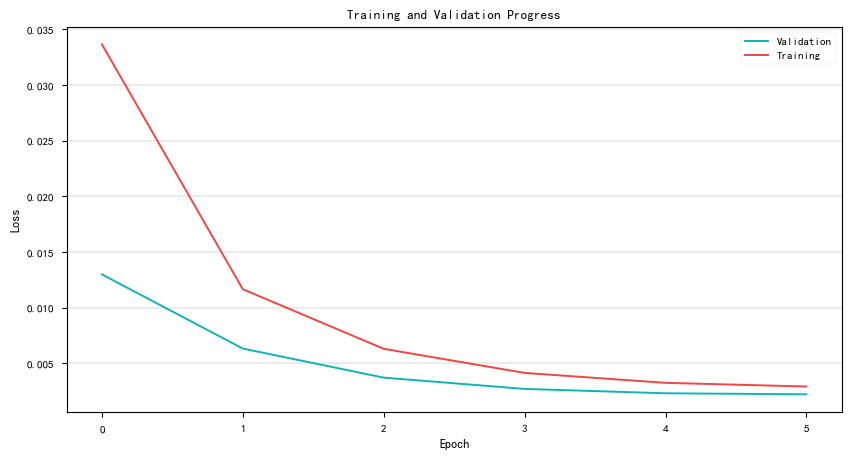

 20%|████████████████▊                                                                   | 1/5 [00:01<00:07,  1.99s/it]

Epoch [1/5], Training Loss: 0.0176, Validation Loss: 0.0050
Validation loss decreased (inf --> 0.004978).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:03<00:06,  2.00s/it]

Epoch [2/5], Training Loss: 0.0046, Validation Loss: 0.0029
Validation loss decreased (0.004978 --> 0.002858).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.08s/it]

Epoch [3/5], Training Loss: 0.0029, Validation Loss: 0.0020
Validation loss decreased (0.002858 --> 0.001976).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:08<00:02,  2.14s/it]

Epoch [4/5], Training Loss: 0.0022, Validation Loss: 0.0016
Validation loss decreased (0.001976 --> 0.001617).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]

Epoch [5/5], Training Loss: 0.0019, Validation Loss: 0.0015
Validation loss decreased (0.001617 --> 0.001520).  Saving model ...
Updating learning rate to 0.0


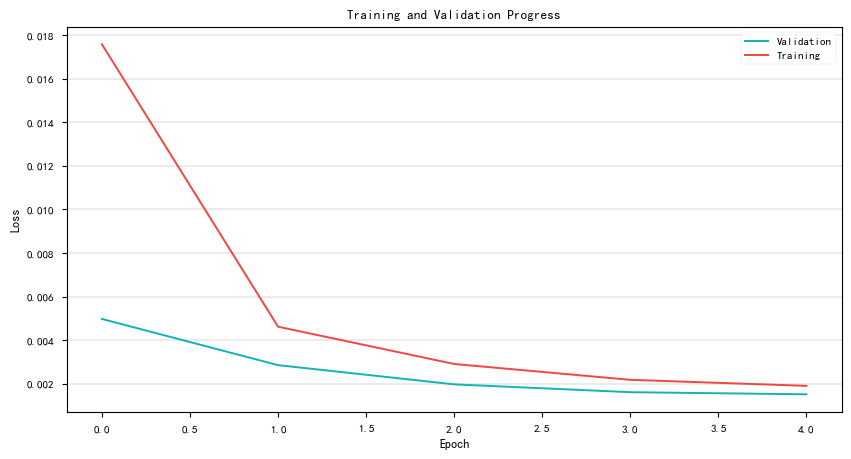

 11%|█████████▎                                                                          | 1/9 [00:03<00:25,  3.24s/it]

Epoch [1/9], Training Loss: 0.0047, Validation Loss: 0.0010
Validation loss decreased (inf --> 0.001029).  Saving model ...
Updating learning rate to 0.0009698463103929542


 22%|██████████████████▋                                                                 | 2/9 [00:06<00:23,  3.42s/it]

Epoch [2/9], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.001029 --> 0.000531).  Saving model ...
Updating learning rate to 0.000883022221559489


 33%|████████████████████████████                                                        | 3/9 [00:10<00:20,  3.41s/it]

Epoch [3/9], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000531 --> 0.000406).  Saving model ...
Updating learning rate to 0.00075


 44%|█████████████████████████████████████▎                                              | 4/9 [00:13<00:16,  3.36s/it]

Epoch [4/9], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000406 --> 0.000324).  Saving model ...
Updating learning rate to 0.0005868240888334653


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:16<00:13,  3.39s/it]

Epoch [5/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000324 --> 0.000292).  Saving model ...
Updating learning rate to 0.00041317591116653486


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:20<00:10,  3.37s/it]

Epoch [6/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000292 --> 0.000287).  Saving model ...
Updating learning rate to 0.0002500000000000001


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:23<00:06,  3.40s/it]

Epoch [7/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000287 --> 0.000282).  Saving model ...
Updating learning rate to 0.00011697777844051105


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:27<00:03,  3.39s/it]

Epoch [8/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000282 --> 0.000272).  Saving model ...
Updating learning rate to 3.0153689607045842e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:30<00:00,  3.39s/it]

Epoch [9/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000272 --> 0.000271).  Saving model ...
Updating learning rate to 0.0


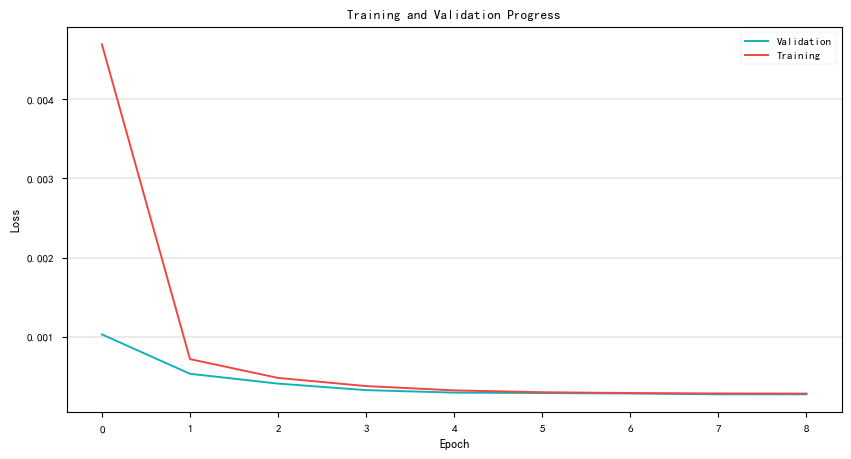

  5%|████▎                                                                              | 1/19 [00:01<00:22,  1.28s/it]

Epoch [1/19], Training Loss: 0.0200, Validation Loss: 0.0083
Validation loss decreased (inf --> 0.008272).  Saving model ...
Updating learning rate to 0.0009931806517013613


 11%|████████▋                                                                          | 2/19 [00:02<00:22,  1.32s/it]

Epoch [2/19], Training Loss: 0.0074, Validation Loss: 0.0041
Validation loss decreased (0.008272 --> 0.004083).  Saving model ...
Updating learning rate to 0.0009729086208503173


 16%|█████████████                                                                      | 3/19 [00:03<00:20,  1.31s/it]

Epoch [3/19], Training Loss: 0.0038, Validation Loss: 0.0023
Validation loss decreased (0.004083 --> 0.002327).  Saving model ...
Updating learning rate to 0.0009397368756032445


 21%|█████████████████▍                                                                 | 4/19 [00:05<00:20,  1.33s/it]

Epoch [4/19], Training Loss: 0.0022, Validation Loss: 0.0015
Validation loss decreased (0.002327 --> 0.001520).  Saving model ...
Updating learning rate to 0.0008945702546981969


 26%|█████████████████████▊                                                             | 5/19 [00:06<00:18,  1.31s/it]

Epoch [5/19], Training Loss: 0.0015, Validation Loss: 0.0011
Validation loss decreased (0.001520 --> 0.001055).  Saving model ...
Updating learning rate to 0.0008386407858128706


 32%|██████████████████████████▏                                                        | 6/19 [00:07<00:17,  1.31s/it]

Epoch [6/19], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.001055 --> 0.000794).  Saving model ...
Updating learning rate to 0.0007734740790612134


 37%|██████████████████████████████▌                                                    | 7/19 [00:09<00:15,  1.30s/it]

Epoch [7/19], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000794 --> 0.000639).  Saving model ...
Updating learning rate to 0.0007008477123264848


 42%|██████████████████████████████████▉                                                | 8/19 [00:10<00:14,  1.27s/it]

Epoch [8/19], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000639 --> 0.000542).  Saving model ...
Updating learning rate to 0.0006227427435703996


 47%|███████████████████████████████████████▎                                           | 9/19 [00:11<00:12,  1.27s/it]

Epoch [9/19], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000542 --> 0.000490).  Saving model ...
Updating learning rate to 0.0005412896727361663


 53%|███████████████████████████████████████████▏                                      | 10/19 [00:13<00:11,  1.30s/it]

Epoch [10/19], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000490 --> 0.000452).  Saving model ...
Updating learning rate to 0.0004587103272638339


 58%|███████████████████████████████████████████████▍                                  | 11/19 [00:14<00:10,  1.27s/it]

Epoch [11/19], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000452 --> 0.000433).  Saving model ...
Updating learning rate to 0.00037725725642960046


 63%|███████████████████████████████████████████████████▊                              | 12/19 [00:15<00:08,  1.28s/it]

Epoch [12/19], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000433 --> 0.000415).  Saving model ...
Updating learning rate to 0.0002991522876735154


 68%|████████████████████████████████████████████████████████                          | 13/19 [00:16<00:07,  1.27s/it]

Epoch [13/19], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000415 --> 0.000415).  Saving model ...
Updating learning rate to 0.00022652592093878665


 74%|████████████████████████████████████████████████████████████▍                     | 14/19 [00:18<00:06,  1.30s/it]

Epoch [14/19], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000415 --> 0.000409).  Saving model ...
Updating learning rate to 0.00016135921418712956


 79%|████████████████████████████████████████████████████████████████▋                 | 15/19 [00:19<00:05,  1.29s/it]

Epoch [15/19], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000409 --> 0.000399).  Saving model ...
Updating learning rate to 0.00010542974530180327


 84%|█████████████████████████████████████████████████████████████████████             | 16/19 [00:20<00:03,  1.32s/it]

Epoch [16/19], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000399 --> 0.000393).  Saving model ...
Updating learning rate to 6.026312439675552e-05


 89%|█████████████████████████████████████████████████████████████████████████▎        | 17/19 [00:22<00:02,  1.30s/it]

Epoch [17/19], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 2.709137914968268e-05


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 18/19 [00:23<00:01,  1.31s/it]

Epoch [18/19], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000393 --> 0.000389).  Saving model ...
Updating learning rate to 6.819348298638839e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:24<00:00,  1.30s/it]

Epoch [19/19], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


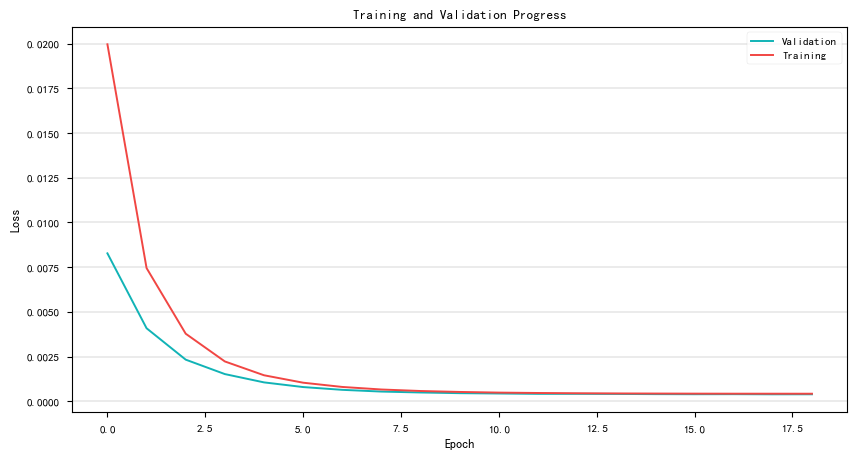

 20%|████████████████▊                                                                   | 1/5 [00:01<00:05,  1.27s/it]

Epoch [1/5], Training Loss: 0.0098, Validation Loss: 0.0039
Validation loss decreased (inf --> 0.003857).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:02<00:03,  1.26s/it]

Epoch [2/5], Training Loss: 0.0035, Validation Loss: 0.0022
Validation loss decreased (0.003857 --> 0.002186).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:03<00:02,  1.26s/it]

Epoch [3/5], Training Loss: 0.0021, Validation Loss: 0.0016
Validation loss decreased (0.002186 --> 0.001562).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:05<00:01,  1.27s/it]

Epoch [4/5], Training Loss: 0.0016, Validation Loss: 0.0013
Validation loss decreased (0.001562 --> 0.001341).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]

Epoch [5/5], Training Loss: 0.0015, Validation Loss: 0.0013
Validation loss decreased (0.001341 --> 0.001289).  Saving model ...
Updating learning rate to 0.0


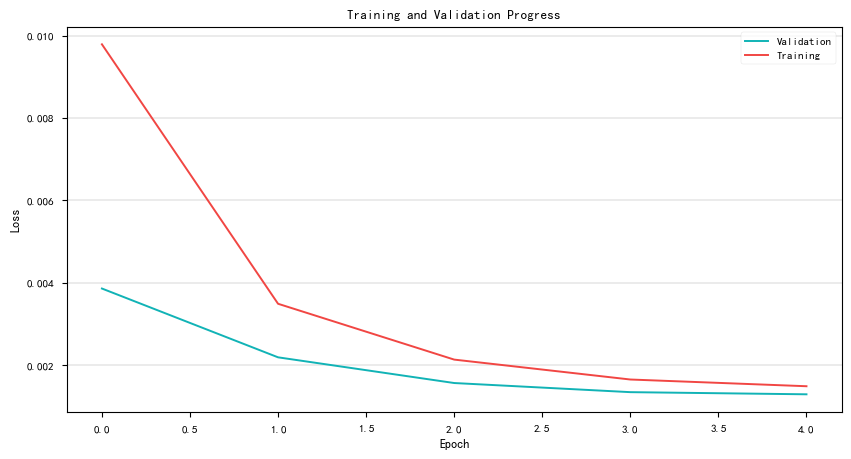

第0次迭代


 11%|█████████▎                                                                          | 1/9 [00:03<00:29,  3.69s/it]

Epoch [1/9], Training Loss: 0.0045, Validation Loss: 0.0009
Validation loss decreased (inf --> 0.000853).  Saving model ...
Updating learning rate to 0.0009698463103929542


 22%|██████████████████▋                                                                 | 2/9 [00:07<00:25,  3.70s/it]

Epoch [2/9], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000853 --> 0.000465).  Saving model ...
Updating learning rate to 0.000883022221559489


 33%|████████████████████████████                                                        | 3/9 [00:10<00:21,  3.65s/it]

Epoch [3/9], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000465 --> 0.000335).  Saving model ...
Updating learning rate to 0.00075


 44%|█████████████████████████████████████▎                                              | 4/9 [00:14<00:18,  3.66s/it]

Epoch [4/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000335 --> 0.000290).  Saving model ...
Updating learning rate to 0.0005868240888334653


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:18<00:14,  3.62s/it]

Epoch [5/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000290 --> 0.000279).  Saving model ...
Updating learning rate to 0.00041317591116653486


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:21<00:10,  3.63s/it]

Epoch [6/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000279 --> 0.000268).  Saving model ...
Updating learning rate to 0.0002500000000000001


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:25<00:07,  3.65s/it]

Epoch [7/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000268 --> 0.000267).  Saving model ...
Updating learning rate to 0.00011697777844051105


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:29<00:03,  3.65s/it]

Epoch [8/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000267 --> 0.000267).  Saving model ...
Updating learning rate to 3.0153689607045842e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.65s/it]

Epoch [9/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000267 --> 0.000265).  Saving model ...
Updating learning rate to 0.0


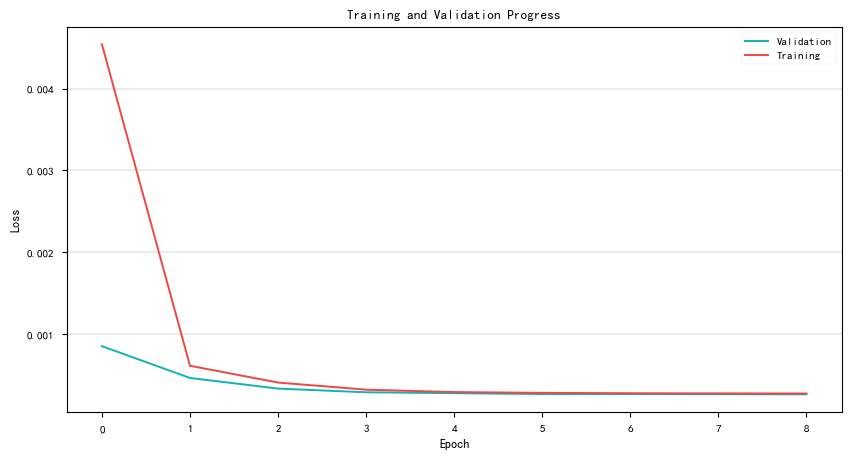

  6%|████▉                                                                              | 1/17 [00:01<00:20,  1.26s/it]

Epoch [1/17], Training Loss: 0.0100, Validation Loss: 0.0039
Validation loss decreased (inf --> 0.003950).  Saving model ...
Updating learning rate to 0.000991486549841951


 12%|█████████▊                                                                         | 2/17 [00:02<00:17,  1.18s/it]

Epoch [2/17], Training Loss: 0.0027, Validation Loss: 0.0017
Validation loss decreased (0.003950 --> 0.001664).  Saving model ...
Updating learning rate to 0.0009662361147021779


 18%|██████████████▋                                                                    | 3/17 [00:03<00:16,  1.19s/it]

Epoch [3/17], Training Loss: 0.0013, Validation Loss: 0.0010
Validation loss decreased (0.001664 --> 0.000966).  Saving model ...
Updating learning rate to 0.0009251085678648072


 24%|███████████████████▌                                                               | 4/17 [00:04<00:15,  1.16s/it]

Epoch [4/17], Training Loss: 0.0008, Validation Loss: 0.0008
Validation loss decreased (0.000966 --> 0.000751).  Saving model ...
Updating learning rate to 0.0008695044586103295


 29%|████████████████████████▍                                                          | 5/17 [00:05<00:13,  1.15s/it]

Epoch [5/17], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000751 --> 0.000645).  Saving model ...
Updating learning rate to 0.0008013173181896282


 35%|█████████████████████████████▎                                                     | 6/17 [00:06<00:12,  1.13s/it]

Epoch [6/17], Training Loss: 0.0006, Validation Loss: 0.0006
Validation loss decreased (0.000645 --> 0.000571).  Saving model ...
Updating learning rate to 0.0007228691778882692


 41%|██████████████████████████████████▏                                                | 7/17 [00:08<00:11,  1.14s/it]

Epoch [7/17], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000571 --> 0.000516).  Saving model ...
Updating learning rate to 0.0006368314950360416


 47%|███████████████████████████████████████                                            | 8/17 [00:09<00:10,  1.15s/it]

Epoch [8/17], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000516 --> 0.000466).  Saving model ...
Updating learning rate to 0.000546134179731651


 53%|███████████████████████████████████████████▉                                       | 9/17 [00:10<00:09,  1.15s/it]

Epoch [9/17], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000466 --> 0.000429).  Saving model ...
Updating learning rate to 0.00045386582026834903


 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:11<00:08,  1.16s/it]

Epoch [10/17], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000429 --> 0.000403).  Saving model ...
Updating learning rate to 0.0003631685049639586


 65%|█████████████████████████████████████████████████████                             | 11/17 [00:12<00:07,  1.17s/it]

Epoch [11/17], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000403 --> 0.000382).  Saving model ...
Updating learning rate to 0.0002771308221117309


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [00:13<00:05,  1.14s/it]

Epoch [12/17], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000382 --> 0.000367).  Saving model ...
Updating learning rate to 0.00019868268181037185


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [00:14<00:04,  1.14s/it]

Epoch [13/17], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000367 --> 0.000357).  Saving model ...
Updating learning rate to 0.0001304955413896705


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [00:16<00:03,  1.15s/it]

Epoch [14/17], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000357 --> 0.000350).  Saving model ...
Updating learning rate to 7.489143213519301e-05


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [00:17<00:02,  1.15s/it]

Epoch [15/17], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000350 --> 0.000345).  Saving model ...
Updating learning rate to 3.376388529782215e-05


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:18<00:01,  1.15s/it]

Epoch [16/17], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000345 --> 0.000344).  Saving model ...
Updating learning rate to 8.513450158049108e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]

Epoch [17/17], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000344 --> 0.000343).  Saving model ...
Updating learning rate to 0.0


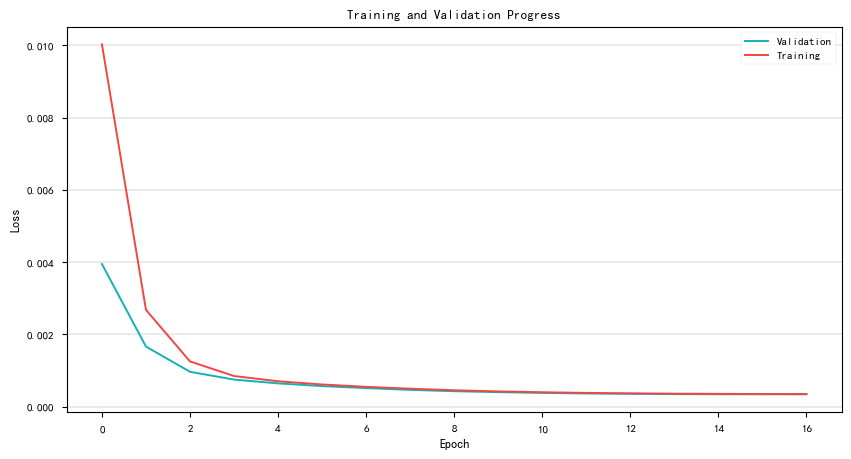

  8%|██████▍                                                                            | 1/13 [00:01<00:15,  1.30s/it]

Epoch [1/13], Training Loss: 0.0112, Validation Loss: 0.0039
Validation loss decreased (inf --> 0.003857).  Saving model ...
Updating learning rate to 0.000985470908713026


 15%|████████████▊                                                                      | 2/13 [00:02<00:13,  1.25s/it]

Epoch [2/13], Training Loss: 0.0026, Validation Loss: 0.0016
Validation loss decreased (0.003857 --> 0.001613).  Saving model ...
Updating learning rate to 0.0009427280128266049


 23%|███████████████████▏                                                               | 3/13 [00:03<00:12,  1.28s/it]

Epoch [3/13], Training Loss: 0.0012, Validation Loss: 0.0010
Validation loss decreased (0.001613 --> 0.000978).  Saving model ...
Updating learning rate to 0.0008742553740855505


 31%|█████████████████████████▌                                                         | 4/13 [00:05<00:11,  1.29s/it]

Epoch [4/13], Training Loss: 0.0008, Validation Loss: 0.0008
Validation loss decreased (0.000978 --> 0.000769).  Saving model ...
Updating learning rate to 0.0007840323733655779


 38%|███████████████████████████████▉                                                   | 5/13 [00:06<00:10,  1.30s/it]

Epoch [5/13], Training Loss: 0.0007, Validation Loss: 0.0007
Validation loss decreased (0.000769 --> 0.000653).  Saving model ...
Updating learning rate to 0.0006773024435212678


 46%|██████████████████████████████████████▎                                            | 6/13 [00:07<00:08,  1.28s/it]

Epoch [6/13], Training Loss: 0.0006, Validation Loss: 0.0006
Validation loss decreased (0.000653 --> 0.000592).  Saving model ...
Updating learning rate to 0.0005602683401276614


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:09<00:07,  1.30s/it]

Epoch [7/13], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000592 --> 0.000526).  Saving model ...
Updating learning rate to 0.00043973165987233853


 62%|███████████████████████████████████████████████████                                | 8/13 [00:10<00:06,  1.27s/it]

Epoch [8/13], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000526 --> 0.000491).  Saving model ...
Updating learning rate to 0.00032269755647873217


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:11<00:04,  1.23s/it]

Epoch [9/13], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000491 --> 0.000456).  Saving model ...
Updating learning rate to 0.00021596762663442215


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:12<00:03,  1.25s/it]

Epoch [10/13], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000456 --> 0.000436).  Saving model ...
Updating learning rate to 0.0001257446259144494


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:13<00:02,  1.23s/it]

Epoch [11/13], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000436 --> 0.000425).  Saving model ...
Updating learning rate to 5.72719871733951e-05


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:15<00:01,  1.24s/it]

Epoch [12/13], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 1.4529091286973995e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:16<00:00,  1.26s/it]

Epoch [13/13], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0


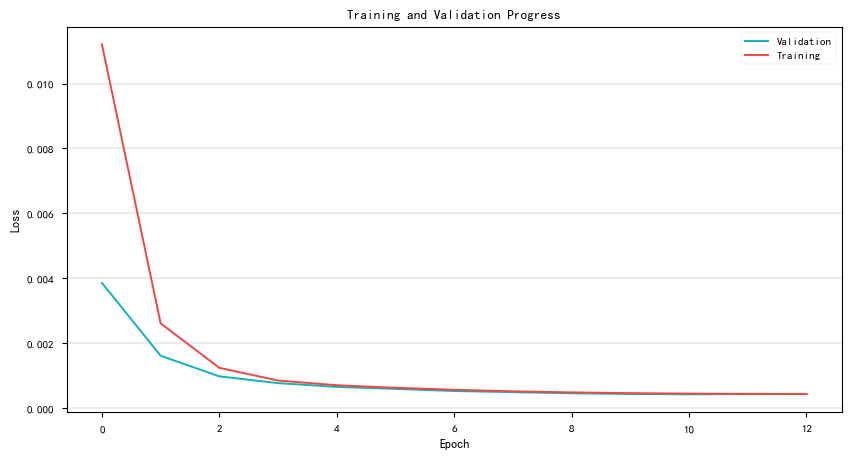

 12%|██████████▌                                                                         | 1/8 [00:03<00:26,  3.83s/it]

Epoch [1/8], Training Loss: 0.0029, Validation Loss: 0.0013
Validation loss decreased (inf --> 0.001278).  Saving model ...
Updating learning rate to 0.0009619397662556434


 25%|█████████████████████                                                               | 2/8 [00:07<00:22,  3.76s/it]

Epoch [2/8], Training Loss: 0.0010, Validation Loss: 0.0005
Validation loss decreased (0.001278 --> 0.000529).  Saving model ...
Updating learning rate to 0.0008535533905932737


 38%|███████████████████████████████▌                                                    | 3/8 [00:11<00:18,  3.79s/it]

Epoch [3/8], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000529 --> 0.000424).  Saving model ...
Updating learning rate to 0.000691341716182545


 50%|██████████████████████████████████████████                                          | 4/8 [00:15<00:15,  3.81s/it]

Epoch [4/8], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000424 --> 0.000403).  Saving model ...
Updating learning rate to 0.0005


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:18<00:11,  3.75s/it]

Epoch [5/8], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0003086582838174551


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:22<00:07,  3.73s/it]

Epoch [6/8], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000403 --> 0.000398).  Saving model ...
Updating learning rate to 0.00014644660940672628


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:26<00:03,  3.69s/it]

Epoch [7/8], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000398 --> 0.000398).  Saving model ...
Updating learning rate to 3.806023374435663e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:29<00:00,  3.72s/it]

Epoch [8/8], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000398 --> 0.000395).  Saving model ...
Updating learning rate to 0.0


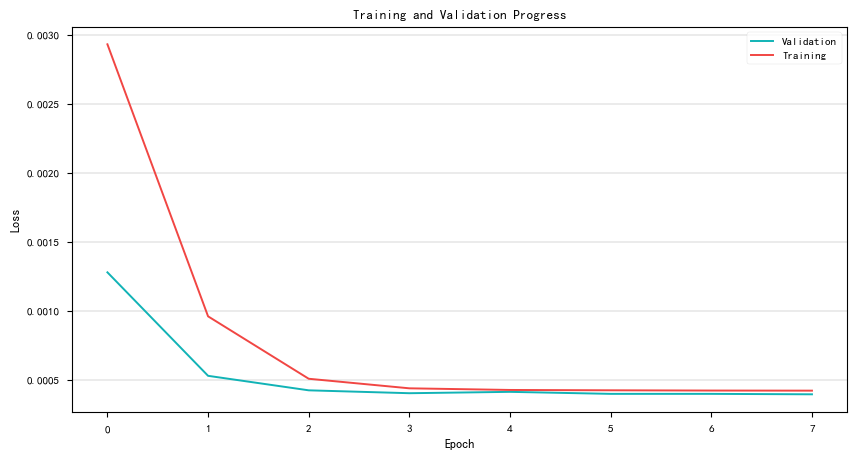

 20%|████████████████▊                                                                   | 1/5 [00:03<00:15,  3.75s/it]

Epoch [1/5], Training Loss: 0.0065, Validation Loss: 0.0021
Validation loss decreased (inf --> 0.002092).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:07<00:11,  3.77s/it]

Epoch [2/5], Training Loss: 0.0016, Validation Loss: 0.0008
Validation loss decreased (0.002092 --> 0.000769).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:11<00:07,  3.81s/it]

Epoch [3/5], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000769 --> 0.000480).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:15<00:03,  3.78s/it]

Epoch [4/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000480 --> 0.000428).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.75s/it]

Epoch [5/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000428 --> 0.000426).  Saving model ...
Updating learning rate to 0.0


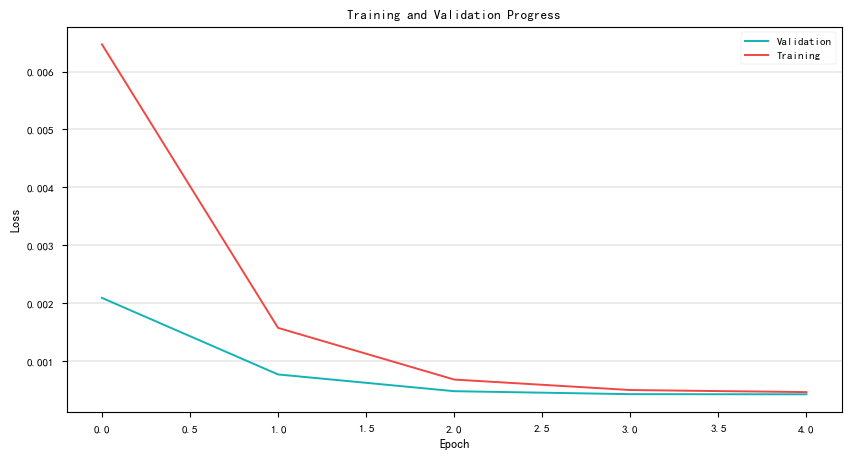

第1次迭代


 11%|█████████▎                                                                          | 1/9 [00:03<00:25,  3.16s/it]

Epoch [1/9], Training Loss: 0.0057, Validation Loss: 0.0012
Validation loss decreased (inf --> 0.001184).  Saving model ...
Updating learning rate to 0.0009698463103929542


 22%|██████████████████▋                                                                 | 2/9 [00:06<00:21,  3.10s/it]

Epoch [2/9], Training Loss: 0.0008, Validation Loss: 0.0005
Validation loss decreased (0.001184 --> 0.000544).  Saving model ...
Updating learning rate to 0.000883022221559489


 33%|████████████████████████████                                                        | 3/9 [00:09<00:18,  3.04s/it]

Epoch [3/9], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000544 --> 0.000407).  Saving model ...
Updating learning rate to 0.00075


 44%|█████████████████████████████████████▎                                              | 4/9 [00:12<00:15,  3.04s/it]

Epoch [4/9], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000407 --> 0.000347).  Saving model ...
Updating learning rate to 0.0005868240888334653


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:15<00:12,  3.03s/it]

Epoch [5/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000347 --> 0.000297).  Saving model ...
Updating learning rate to 0.00041317591116653486


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:18<00:09,  3.00s/it]

Epoch [6/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000297 --> 0.000285).  Saving model ...
Updating learning rate to 0.0002500000000000001


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:21<00:06,  3.02s/it]

Epoch [7/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000285 --> 0.000275).  Saving model ...
Updating learning rate to 0.00011697777844051105


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:24<00:03,  3.08s/it]

Epoch [8/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000275 --> 0.000272).  Saving model ...
Updating learning rate to 3.0153689607045842e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.10s/it]

Epoch [9/9], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000272 --> 0.000270).  Saving model ...
Updating learning rate to 0.0


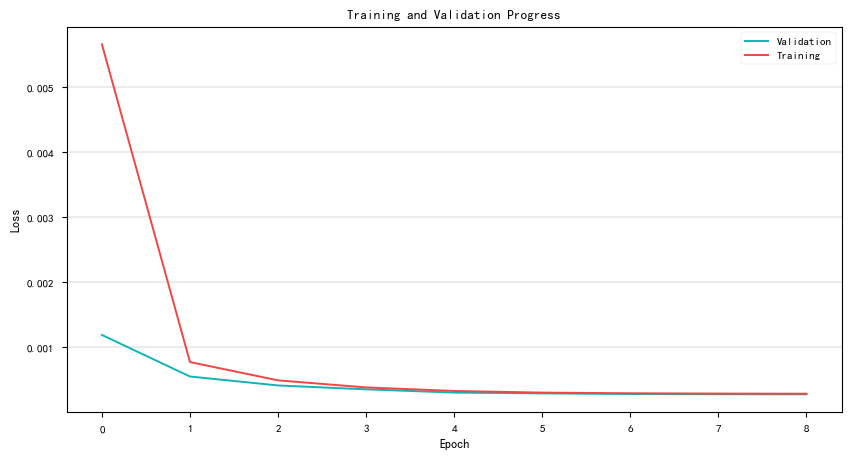

 20%|████████████████▊                                                                   | 1/5 [00:04<00:16,  4.08s/it]

Epoch [1/5], Training Loss: 0.0041, Validation Loss: 0.0008
Validation loss decreased (inf --> 0.000807).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:07<00:11,  3.86s/it]

Epoch [2/5], Training Loss: 0.0006, Validation Loss: 0.0004
Validation loss decreased (0.000807 --> 0.000440).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:11<00:07,  3.75s/it]

Epoch [3/5], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000440 --> 0.000361).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:15<00:03,  3.71s/it]

Epoch [4/5], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000361 --> 0.000311).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.73s/it]

Epoch [5/5], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000311 --> 0.000305).  Saving model ...
Updating learning rate to 0.0


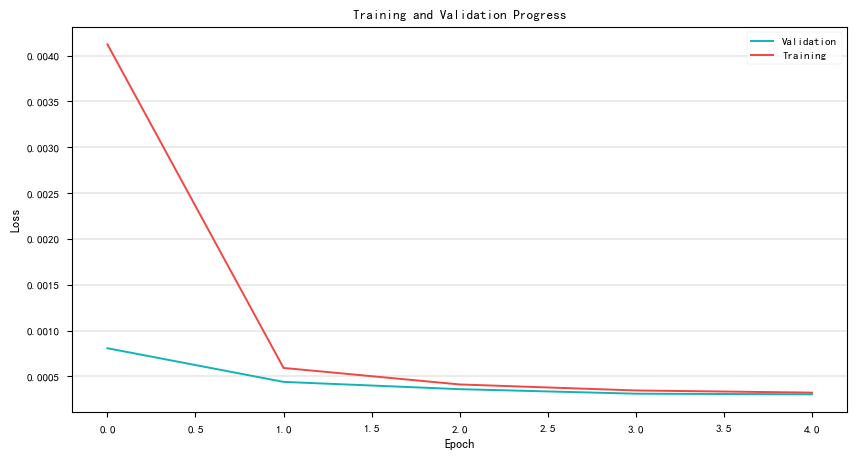

 12%|██████████▌                                                                         | 1/8 [00:02<00:15,  2.25s/it]

Epoch [1/8], Training Loss: 0.0051, Validation Loss: 0.0016
Validation loss decreased (inf --> 0.001605).  Saving model ...
Updating learning rate to 0.0009619397662556434


 25%|█████████████████████                                                               | 2/8 [00:04<00:13,  2.24s/it]

Epoch [2/8], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001605 --> 0.001057).  Saving model ...
Updating learning rate to 0.0008535533905932737


 38%|███████████████████████████████▌                                                    | 3/8 [00:06<00:11,  2.25s/it]

Epoch [3/8], Training Loss: 0.0010, Validation Loss: 0.0009
Validation loss decreased (0.001057 --> 0.000890).  Saving model ...
Updating learning rate to 0.000691341716182545


 50%|██████████████████████████████████████████                                          | 4/8 [00:09<00:09,  2.30s/it]

Epoch [4/8], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000890 --> 0.000806).  Saving model ...
Updating learning rate to 0.0005


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:11<00:06,  2.31s/it]

Epoch [5/8], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000806 --> 0.000748).  Saving model ...
Updating learning rate to 0.0003086582838174551


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:13<00:04,  2.34s/it]

Epoch [6/8], Training Loss: 0.0007, Validation Loss: 0.0007
Validation loss decreased (0.000748 --> 0.000721).  Saving model ...
Updating learning rate to 0.00014644660940672628


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:16<00:02,  2.35s/it]

Epoch [7/8], Training Loss: 0.0007, Validation Loss: 0.0007
Validation loss decreased (0.000721 --> 0.000716).  Saving model ...
Updating learning rate to 3.806023374435663e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.33s/it]

Epoch [8/8], Training Loss: 0.0007, Validation Loss: 0.0007
Validation loss decreased (0.000716 --> 0.000707).  Saving model ...
Updating learning rate to 0.0


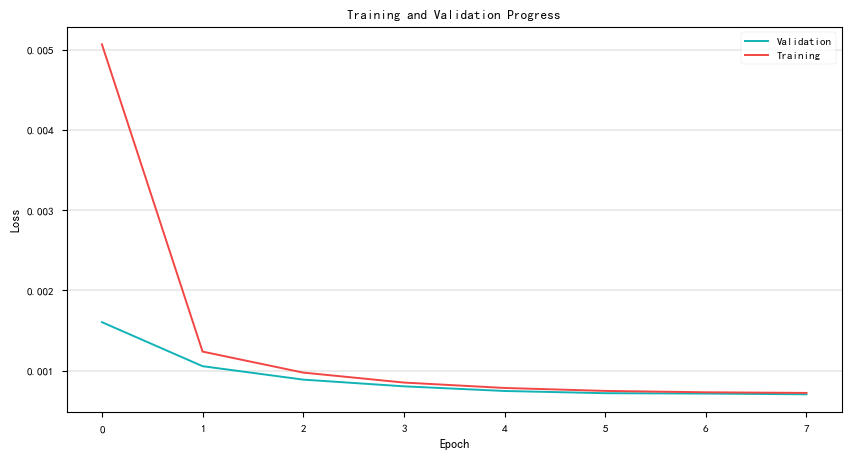

  8%|██████▉                                                                            | 1/12 [00:03<00:38,  3.48s/it]

Epoch [1/12], Training Loss: 0.0049, Validation Loss: 0.0009
Validation loss decreased (inf --> 0.000948).  Saving model ...
Updating learning rate to 0.0009829629131445341


 17%|█████████████▊                                                                     | 2/12 [00:06<00:34,  3.46s/it]

Epoch [2/12], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000948 --> 0.000483).  Saving model ...
Updating learning rate to 0.0009330127018922195


 25%|████████████████████▊                                                              | 3/12 [00:10<00:30,  3.44s/it]

Epoch [3/12], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000483 --> 0.000368).  Saving model ...
Updating learning rate to 0.0008535533905932737


 33%|███████████████████████████▋                                                       | 4/12 [00:13<00:27,  3.50s/it]

Epoch [4/12], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000368 --> 0.000290).  Saving model ...
Updating learning rate to 0.00075


 42%|██████████████████████████████████▌                                                | 5/12 [00:17<00:24,  3.50s/it]

Epoch [5/12], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000290 --> 0.000272).  Saving model ...
Updating learning rate to 0.0006294095225512603


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:20<00:20,  3.48s/it]

Epoch [6/12], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000272 --> 0.000268).  Saving model ...
Updating learning rate to 0.0005


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:24<00:17,  3.56s/it]

Epoch [7/12], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000268 --> 0.000267).  Saving model ...
Updating learning rate to 0.0003705904774487396


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:28<00:14,  3.60s/it]

Epoch [8/12], Training Loss: 0.0003, Validation Loss: 0.0003
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002500000000000001


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:31<00:10,  3.63s/it]

Epoch [9/12], Training Loss: 0.0003, Validation Loss: 0.0003
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00014644660940672628


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:35<00:07,  3.66s/it]

Epoch [10/12], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000267 --> 0.000266).  Saving model ...
Updating learning rate to 6.698729810778065e-05


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:39<00:03,  3.68s/it]

Epoch [11/12], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000266 --> 0.000266).  Saving model ...
Updating learning rate to 1.70370868554659e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:43<00:00,  3.60s/it]

Epoch [12/12], Training Loss: 0.0003, Validation Loss: 0.0003
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


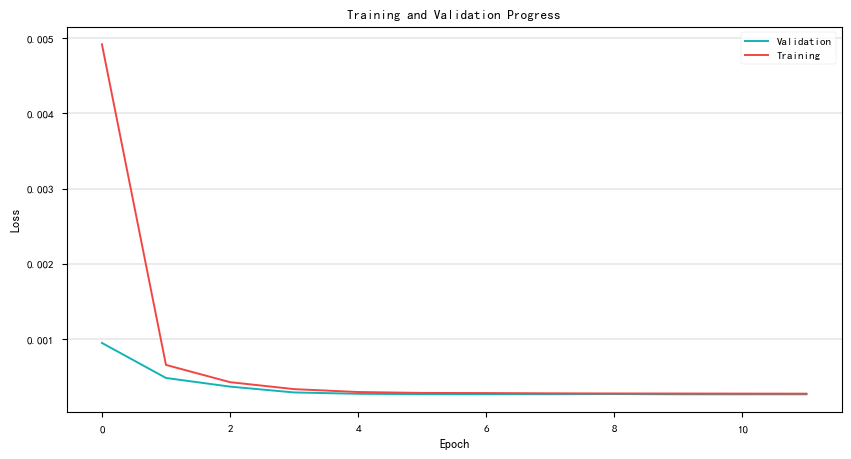

 14%|████████████                                                                        | 1/7 [00:04<00:24,  4.06s/it]

Epoch [1/7], Training Loss: 0.0042, Validation Loss: 0.0008
Validation loss decreased (inf --> 0.000842).  Saving model ...
Updating learning rate to 0.0009504844339512095


 29%|████████████████████████                                                            | 2/7 [00:08<00:20,  4.04s/it]

Epoch [2/7], Training Loss: 0.0006, Validation Loss: 0.0004
Validation loss decreased (0.000842 --> 0.000432).  Saving model ...
Updating learning rate to 0.0008117449009293668


 43%|████████████████████████████████████                                                | 3/7 [00:12<00:16,  4.02s/it]

Epoch [3/7], Training Loss: 0.0004, Validation Loss: 0.0003
Validation loss decreased (0.000432 --> 0.000331).  Saving model ...
Updating learning rate to 0.0006112604669781572


 57%|████████████████████████████████████████████████                                    | 4/7 [00:16<00:12,  4.01s/it]

Epoch [4/7], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000331 --> 0.000293).  Saving model ...
Updating learning rate to 0.00038873953302184284


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:20<00:07,  3.99s/it]

Epoch [5/7], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000293 --> 0.000281).  Saving model ...
Updating learning rate to 0.00018825509907063325


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:23<00:03,  3.98s/it]

Epoch [6/7], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000281 --> 0.000275).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:27<00:00,  3.99s/it]

Epoch [7/7], Training Loss: 0.0003, Validation Loss: 0.0003
Validation loss decreased (0.000275 --> 0.000274).  Saving model ...
Updating learning rate to 0.0


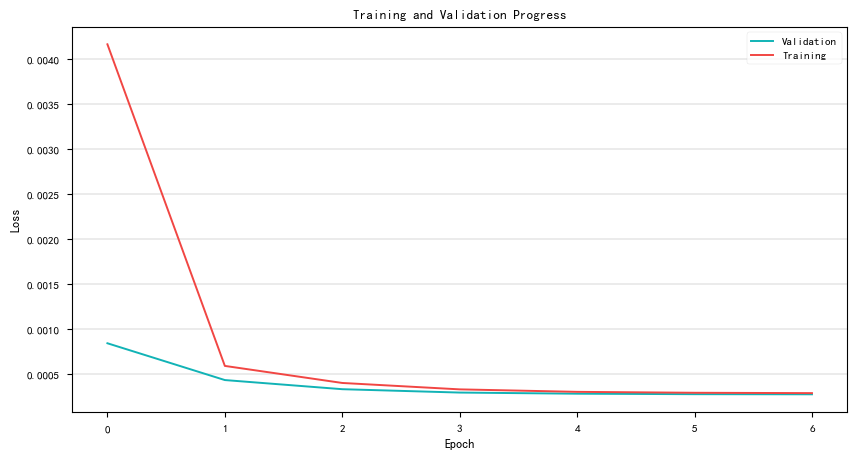

In [15]:
import WOA # 加载本地鲸鱼优化算法

# 构造参数字典
woa_args = {
    "pop": 5, # 种群数量，需遍历
    "dim": 4, # 优化参数维度
    "lb": np.array([3, 1, 16, 5]), # 下边界，分别为回视窗口、预测维度、批量大小、迭代次数
    "ub": np.array([20, 3, 64, 20]), # 上边界，分别为回视窗口、预测维度、批量大小、迭代次数
    "fun": fitness, # 适应度函数，最小化问题
    "MaxIter": 2, # 最大迭代次数，需遍历
}

#函数传参，运行次数：pop*MaxIter*n_epochs
GbestScore,GbestPositon,Curve = WOA.WOA(**woa_args)

In [16]:
x1, x2, x3, x4 = GbestPositon[0]
print('最优适应度值：',GbestScore)
print('最优解[回视窗口]：', int(x1))
print('最优解[预测维度]：', int(x2))
print('最优解[批量大小]：', int(x3))
print('最优解[迭代次数]：', int(x4))

最优适应度值： [0.00026503]
最优解[回视窗口]： 19
最优解[预测维度]： 1
最优解[批量大小]： 16
最优解[迭代次数]： 9


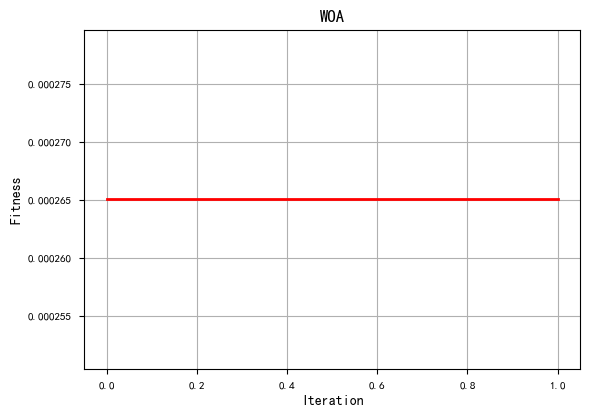

In [17]:
#绘制适应度曲线
plt.figure(1)
plt.plot(Curve,'r-',linewidth=2)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('WOA',fontsize='large')
plt.show()

### 遗传算法

 10%|████████▎                                                                          | 1/10 [00:01<00:14,  1.65s/it]

Epoch [1/10], Training Loss: 0.0311, Validation Loss: 0.0106
Validation loss decreased (inf --> 0.010565).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:03<00:12,  1.56s/it]

Epoch [2/10], Training Loss: 0.0083, Validation Loss: 0.0038
Validation loss decreased (0.010565 --> 0.003810).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:10,  1.57s/it]

Epoch [3/10], Training Loss: 0.0035, Validation Loss: 0.0023
Validation loss decreased (0.003810 --> 0.002292).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.58s/it]

Epoch [4/10], Training Loss: 0.0022, Validation Loss: 0.0016
Validation loss decreased (0.002292 --> 0.001551).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:07,  1.59s/it]

Epoch [5/10], Training Loss: 0.0015, Validation Loss: 0.0011
Validation loss decreased (0.001551 --> 0.001141).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:09<00:06,  1.60s/it]

Epoch [6/10], Training Loss: 0.0011, Validation Loss: 0.0009
Validation loss decreased (0.001141 --> 0.000909).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:04,  1.60s/it]

Epoch [7/10], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000909 --> 0.000790).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:12<00:03,  1.60s/it]

Epoch [8/10], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000790 --> 0.000719).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:14<00:01,  1.59s/it]

Epoch [9/10], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000719 --> 0.000686).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]

Epoch [10/10], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000686 --> 0.000681).  Saving model ...
Updating learning rate to 0.0


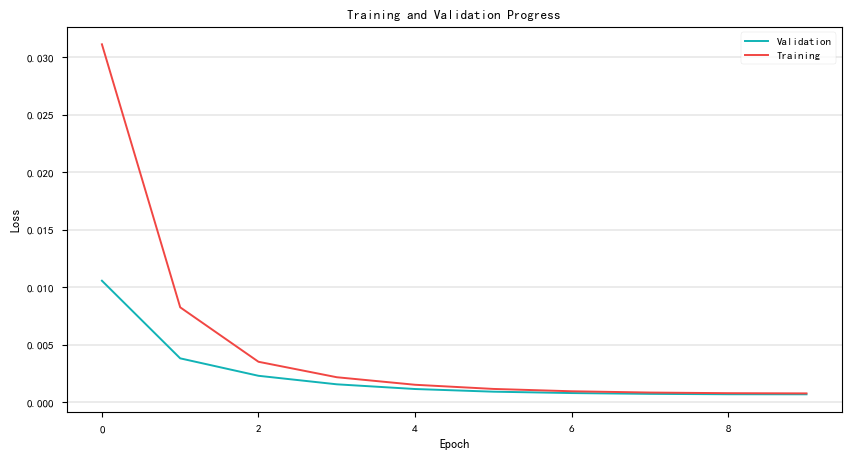

  8%|██████▉                                                                            | 1/12 [00:01<00:15,  1.41s/it]

Epoch [1/12], Training Loss: 0.0112, Validation Loss: 0.0050
Validation loss decreased (inf --> 0.005049).  Saving model ...
Updating learning rate to 0.0009829629131445341


 17%|█████████████▊                                                                     | 2/12 [00:02<00:14,  1.42s/it]

Epoch [2/12], Training Loss: 0.0039, Validation Loss: 0.0025
Validation loss decreased (0.005049 --> 0.002504).  Saving model ...
Updating learning rate to 0.0009330127018922195


 25%|████████████████████▊                                                              | 3/12 [00:04<00:12,  1.43s/it]

Epoch [3/12], Training Loss: 0.0020, Validation Loss: 0.0015
Validation loss decreased (0.002504 --> 0.001464).  Saving model ...
Updating learning rate to 0.0008535533905932737


 33%|███████████████████████████▋                                                       | 4/12 [00:05<00:11,  1.43s/it]

Epoch [4/12], Training Loss: 0.0013, Validation Loss: 0.0011
Validation loss decreased (0.001464 --> 0.001091).  Saving model ...
Updating learning rate to 0.00075


 42%|██████████████████████████████████▌                                                | 5/12 [00:07<00:09,  1.42s/it]

Epoch [5/12], Training Loss: 0.0011, Validation Loss: 0.0009
Validation loss decreased (0.001091 --> 0.000940).  Saving model ...
Updating learning rate to 0.0006294095225512603


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:08<00:08,  1.39s/it]

Epoch [6/12], Training Loss: 0.0010, Validation Loss: 0.0009
Validation loss decreased (0.000940 --> 0.000884).  Saving model ...
Updating learning rate to 0.0005


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:09<00:06,  1.37s/it]

Epoch [7/12], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000884 --> 0.000840).  Saving model ...
Updating learning rate to 0.0003705904774487396


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:11<00:05,  1.36s/it]

Epoch [8/12], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000840 --> 0.000827).  Saving model ...
Updating learning rate to 0.0002500000000000001


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:12<00:04,  1.36s/it]

Epoch [9/12], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000827 --> 0.000809).  Saving model ...
Updating learning rate to 0.00014644660940672628


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:13<00:02,  1.35s/it]

Epoch [10/12], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000809 --> 0.000799).  Saving model ...
Updating learning rate to 6.698729810778065e-05


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:15<00:01,  1.35s/it]

Epoch [11/12], Training Loss: 0.0009, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 5
Updating learning rate to 1.70370868554659e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.37s/it]

Epoch [12/12], Training Loss: 0.0009, Validation Loss: 0.0008
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0


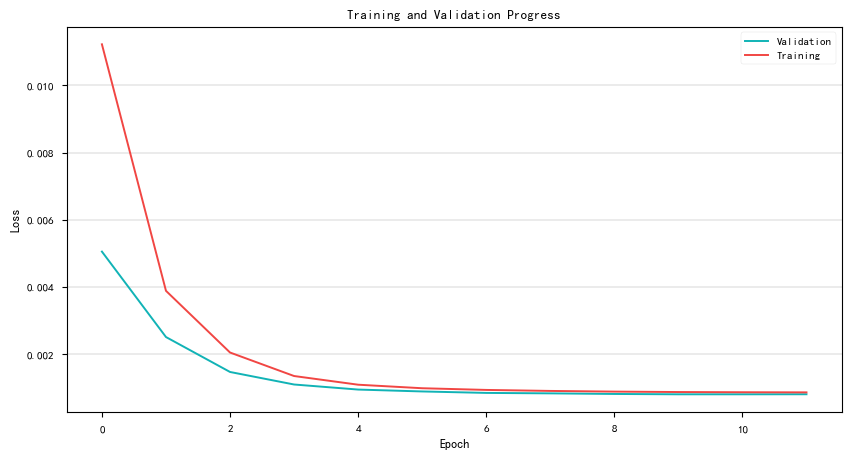

 20%|████████████████▊                                                                   | 1/5 [00:03<00:13,  3.33s/it]

Epoch [1/5], Training Loss: 0.0089, Validation Loss: 0.0021
Validation loss decreased (inf --> 0.002054).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:10,  3.37s/it]

Epoch [2/5], Training Loss: 0.0016, Validation Loss: 0.0009
Validation loss decreased (0.002054 --> 0.000860).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:10<00:06,  3.40s/it]

Epoch [3/5], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000860 --> 0.000562).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:13<00:03,  3.39s/it]

Epoch [4/5], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000562 --> 0.000478).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.40s/it]

Epoch [5/5], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000478 --> 0.000464).  Saving model ...
Updating learning rate to 0.0


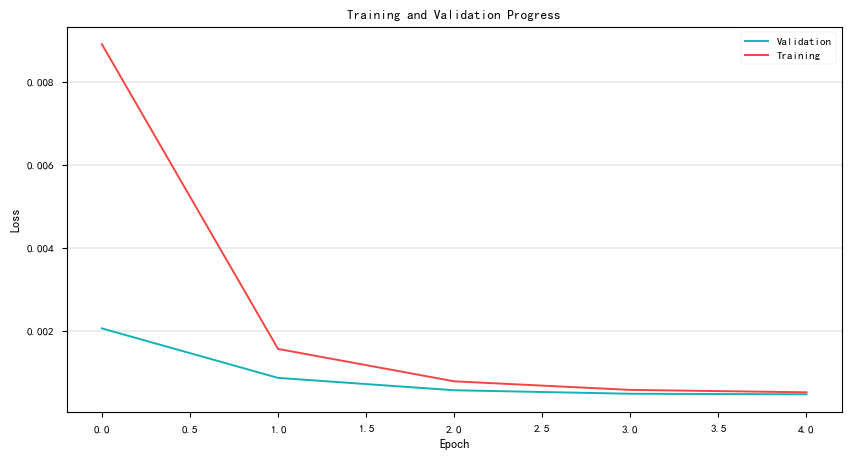

 14%|████████████                                                                        | 1/7 [00:01<00:09,  1.62s/it]

Epoch [1/7], Training Loss: 0.0119, Validation Loss: 0.0052
Validation loss decreased (inf --> 0.005187).  Saving model ...
Updating learning rate to 0.0009504844339512095


 29%|████████████████████████                                                            | 2/7 [00:03<00:09,  1.93s/it]

Epoch [2/7], Training Loss: 0.0043, Validation Loss: 0.0028
Validation loss decreased (0.005187 --> 0.002812).  Saving model ...
Updating learning rate to 0.0008117449009293668


 43%|████████████████████████████████████                                                | 3/7 [00:05<00:08,  2.05s/it]

Epoch [3/7], Training Loss: 0.0024, Validation Loss: 0.0018
Validation loss decreased (0.002812 --> 0.001776).  Saving model ...
Updating learning rate to 0.0006112604669781572


 57%|████████████████████████████████████████████████                                    | 4/7 [00:08<00:06,  2.25s/it]

Epoch [4/7], Training Loss: 0.0017, Validation Loss: 0.0013
Validation loss decreased (0.001776 --> 0.001335).  Saving model ...
Updating learning rate to 0.00038873953302184284


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:10<00:04,  2.32s/it]

Epoch [5/7], Training Loss: 0.0014, Validation Loss: 0.0012
Validation loss decreased (0.001335 --> 0.001159).  Saving model ...
Updating learning rate to 0.00018825509907063325


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:12<00:02,  2.20s/it]

Epoch [6/7], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001159 --> 0.001102).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.09s/it]

Epoch [7/7], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001102 --> 0.001077).  Saving model ...
Updating learning rate to 0.0


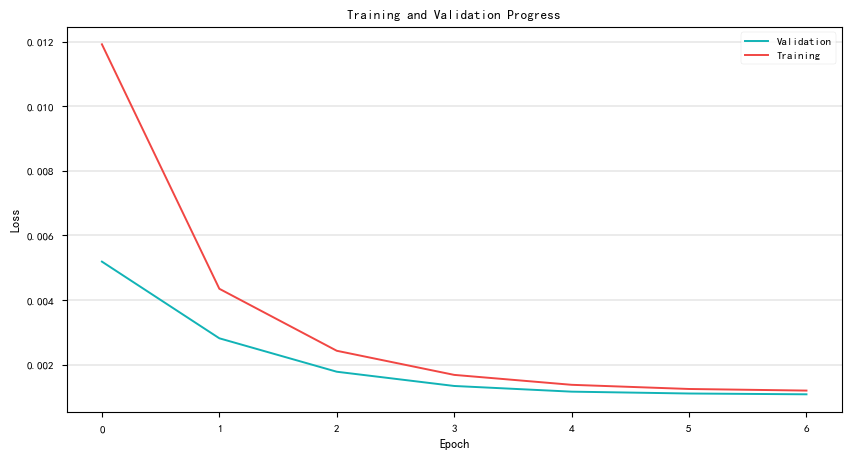

  6%|████▉                                                                              | 1/17 [00:01<00:30,  1.94s/it]

Epoch [1/17], Training Loss: 0.0127, Validation Loss: 0.0056
Validation loss decreased (inf --> 0.005573).  Saving model ...
Updating learning rate to 0.000991486549841951


 12%|█████████▊                                                                         | 2/17 [00:03<00:28,  1.92s/it]

Epoch [2/17], Training Loss: 0.0050, Validation Loss: 0.0032
Validation loss decreased (0.005573 --> 0.003178).  Saving model ...
Updating learning rate to 0.0009662361147021779


 18%|██████████████▋                                                                    | 3/17 [00:05<00:26,  1.88s/it]

Epoch [3/17], Training Loss: 0.0030, Validation Loss: 0.0022
Validation loss decreased (0.003178 --> 0.002188).  Saving model ...
Updating learning rate to 0.0009251085678648072


 24%|███████████████████▌                                                               | 4/17 [00:07<00:24,  1.90s/it]

Epoch [4/17], Training Loss: 0.0022, Validation Loss: 0.0018
Validation loss decreased (0.002188 --> 0.001771).  Saving model ...
Updating learning rate to 0.0008695044586103295


 29%|████████████████████████▍                                                          | 5/17 [00:09<00:22,  1.91s/it]

Epoch [5/17], Training Loss: 0.0018, Validation Loss: 0.0014
Validation loss decreased (0.001771 --> 0.001442).  Saving model ...
Updating learning rate to 0.0008013173181896282


 35%|█████████████████████████████▎                                                     | 6/17 [00:11<00:21,  1.93s/it]

Epoch [6/17], Training Loss: 0.0015, Validation Loss: 0.0013
Validation loss decreased (0.001442 --> 0.001328).  Saving model ...
Updating learning rate to 0.0007228691778882692


 41%|██████████████████████████████████▏                                                | 7/17 [00:13<00:19,  1.94s/it]

Epoch [7/17], Training Loss: 0.0014, Validation Loss: 0.0012
Validation loss decreased (0.001328 --> 0.001231).  Saving model ...
Updating learning rate to 0.0006368314950360416


 47%|███████████████████████████████████████                                            | 8/17 [00:15<00:17,  1.93s/it]

Epoch [8/17], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001231 --> 0.001181).  Saving model ...
Updating learning rate to 0.000546134179731651


 53%|███████████████████████████████████████████▉                                       | 9/17 [00:17<00:15,  1.89s/it]

Epoch [9/17], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001181 --> 0.001163).  Saving model ...
Updating learning rate to 0.00045386582026834903


 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:19<00:13,  1.92s/it]

Epoch [10/17], Training Loss: 0.0013, Validation Loss: 0.0011
Validation loss decreased (0.001163 --> 0.001149).  Saving model ...
Updating learning rate to 0.0003631685049639586


 65%|█████████████████████████████████████████████████████                             | 11/17 [00:21<00:11,  1.89s/it]

Epoch [11/17], Training Loss: 0.0012, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002771308221117309


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [00:22<00:09,  1.85s/it]

Epoch [12/17], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001149 --> 0.001135).  Saving model ...
Updating learning rate to 0.00019868268181037185


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [00:24<00:07,  1.86s/it]

Epoch [13/17], Training Loss: 0.0012, Validation Loss: 0.0011
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0001304955413896705


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [00:26<00:05,  1.87s/it]

Epoch [14/17], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001135 --> 0.001131).  Saving model ...
Updating learning rate to 7.489143213519301e-05


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [00:28<00:03,  1.87s/it]

Epoch [15/17], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001131 --> 0.001128).  Saving model ...
Updating learning rate to 3.376388529782215e-05


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:30<00:01,  1.86s/it]

Epoch [16/17], Training Loss: 0.0012, Validation Loss: 0.0011
Validation loss decreased (0.001128 --> 0.001120).  Saving model ...
Updating learning rate to 8.513450158049108e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:32<00:00,  1.89s/it]

Epoch [17/17], Training Loss: 0.0012, Validation Loss: 0.0011
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


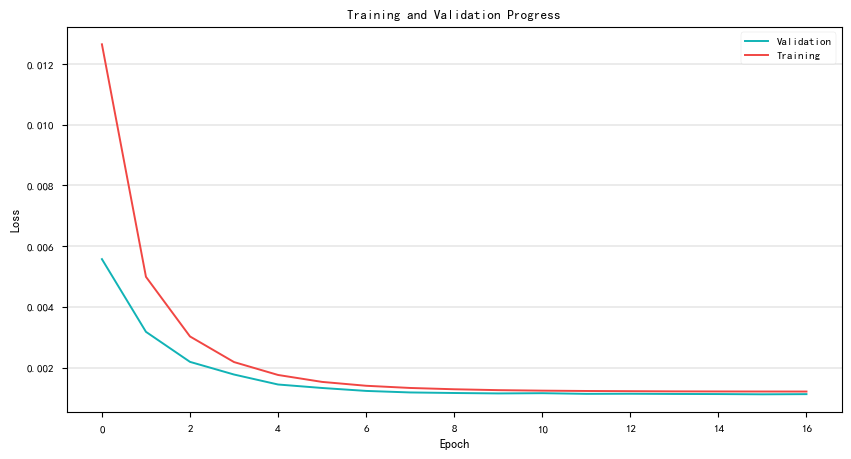

 17%|██████████████                                                                      | 1/6 [00:01<00:07,  1.43s/it]

Epoch [1/6], Training Loss: 0.0154, Validation Loss: 0.0071
Validation loss decreased (inf --> 0.007061).  Saving model ...
Updating learning rate to 0.0009330127018922195


 33%|████████████████████████████                                                        | 2/6 [00:02<00:05,  1.47s/it]

Epoch [2/6], Training Loss: 0.0073, Validation Loss: 0.0045
Validation loss decreased (0.007061 --> 0.004508).  Saving model ...
Updating learning rate to 0.00075


 50%|██████████████████████████████████████████                                          | 3/6 [00:04<00:04,  1.48s/it]

Epoch [3/6], Training Loss: 0.0049, Validation Loss: 0.0033
Validation loss decreased (0.004508 --> 0.003339).  Saving model ...
Updating learning rate to 0.0005


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:05<00:03,  1.50s/it]

Epoch [4/6], Training Loss: 0.0038, Validation Loss: 0.0029
Validation loss decreased (0.003339 --> 0.002859).  Saving model ...
Updating learning rate to 0.0002500000000000001


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:07<00:01,  1.49s/it]

Epoch [5/6], Training Loss: 0.0033, Validation Loss: 0.0026
Validation loss decreased (0.002859 --> 0.002620).  Saving model ...
Updating learning rate to 6.698729810778065e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.48s/it]

Epoch [6/6], Training Loss: 0.0032, Validation Loss: 0.0026
Validation loss decreased (0.002620 --> 0.002569).  Saving model ...
Updating learning rate to 0.0


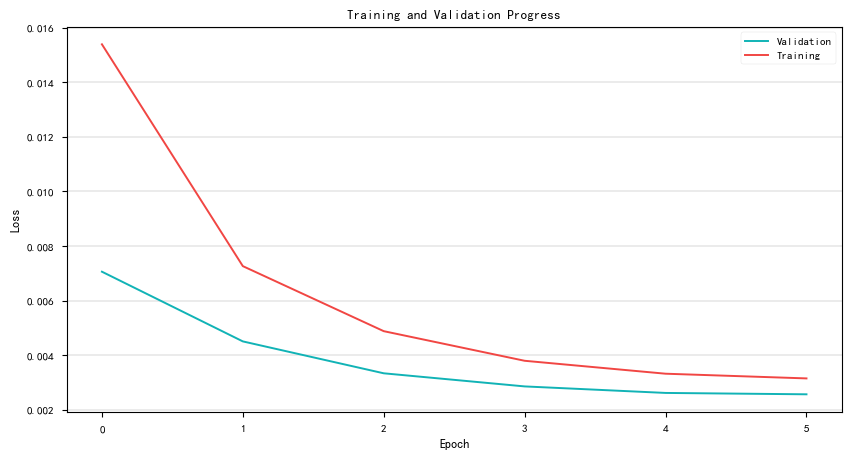

 11%|█████████▎                                                                          | 1/9 [00:03<00:25,  3.17s/it]

Epoch [1/9], Training Loss: 0.0114, Validation Loss: 0.0038
Validation loss decreased (inf --> 0.003754).  Saving model ...
Updating learning rate to 0.0009698463103929542


 22%|██████████████████▋                                                                 | 2/9 [00:06<00:23,  3.33s/it]

Epoch [2/9], Training Loss: 0.0034, Validation Loss: 0.0021
Validation loss decreased (0.003754 --> 0.002122).  Saving model ...
Updating learning rate to 0.000883022221559489


 33%|████████████████████████████                                                        | 3/9 [00:10<00:20,  3.44s/it]

Epoch [3/9], Training Loss: 0.0021, Validation Loss: 0.0016
Validation loss decreased (0.002122 --> 0.001606).  Saving model ...
Updating learning rate to 0.00075


 44%|█████████████████████████████████████▎                                              | 4/9 [00:13<00:16,  3.21s/it]

Epoch [4/9], Training Loss: 0.0017, Validation Loss: 0.0014
Validation loss decreased (0.001606 --> 0.001387).  Saving model ...
Updating learning rate to 0.0005868240888334653


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:16<00:12,  3.15s/it]

Epoch [5/9], Training Loss: 0.0015, Validation Loss: 0.0013
Validation loss decreased (0.001387 --> 0.001303).  Saving model ...
Updating learning rate to 0.00041317591116653486


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:19<00:09,  3.13s/it]

Epoch [6/9], Training Loss: 0.0014, Validation Loss: 0.0013
Validation loss decreased (0.001303 --> 0.001277).  Saving model ...
Updating learning rate to 0.0002500000000000001


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:22<00:06,  3.18s/it]

Epoch [7/9], Training Loss: 0.0014, Validation Loss: 0.0012
Validation loss decreased (0.001277 --> 0.001235).  Saving model ...
Updating learning rate to 0.00011697777844051105


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:25<00:03,  3.14s/it]

Epoch [8/9], Training Loss: 0.0014, Validation Loss: 0.0012
Validation loss decreased (0.001235 --> 0.001228).  Saving model ...
Updating learning rate to 3.0153689607045842e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.25s/it]

Epoch [9/9], Training Loss: 0.0014, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


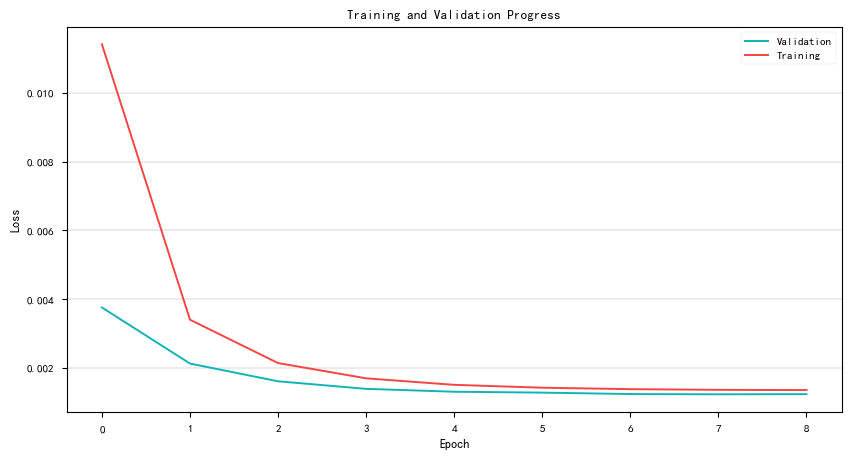

  7%|█████▉                                                                             | 1/14 [00:02<00:28,  2.19s/it]

Epoch [1/14], Training Loss: 0.2174, Validation Loss: 0.0275
Validation loss decreased (inf --> 0.027472).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:03<00:22,  1.91s/it]

Epoch [2/14], Training Loss: 0.0192, Validation Loss: 0.0133
Validation loss decreased (0.027472 --> 0.013279).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:05<00:19,  1.81s/it]

Epoch [3/14], Training Loss: 0.0133, Validation Loss: 0.0092
Validation loss decreased (0.013279 --> 0.009202).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:07<00:17,  1.78s/it]

Epoch [4/14], Training Loss: 0.0088, Validation Loss: 0.0059
Validation loss decreased (0.009202 --> 0.005929).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:09<00:15,  1.75s/it]

Epoch [5/14], Training Loss: 0.0056, Validation Loss: 0.0037
Validation loss decreased (0.005929 --> 0.003671).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:10<00:13,  1.74s/it]

Epoch [6/14], Training Loss: 0.0035, Validation Loss: 0.0023
Validation loss decreased (0.003671 --> 0.002331).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:12<00:13,  1.86s/it]

Epoch [7/14], Training Loss: 0.0023, Validation Loss: 0.0016
Validation loss decreased (0.002331 --> 0.001622).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:15<00:12,  2.05s/it]

Epoch [8/14], Training Loss: 0.0016, Validation Loss: 0.0012
Validation loss decreased (0.001622 --> 0.001182).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:17<00:10,  2.05s/it]

Epoch [9/14], Training Loss: 0.0012, Validation Loss: 0.0010
Validation loss decreased (0.001182 --> 0.000959).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:19<00:07,  1.95s/it]

Epoch [10/14], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.000959 --> 0.000839).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:20<00:05,  1.89s/it]

Epoch [11/14], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000839 --> 0.000764).  Saving model ...
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:22<00:03,  1.84s/it]

Epoch [12/14], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000764 --> 0.000752).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:24<00:01,  1.77s/it]

Epoch [13/14], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000752 --> 0.000724).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.84s/it]

Epoch [14/14], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000724 --> 0.000710).  Saving model ...
Updating learning rate to 0.0


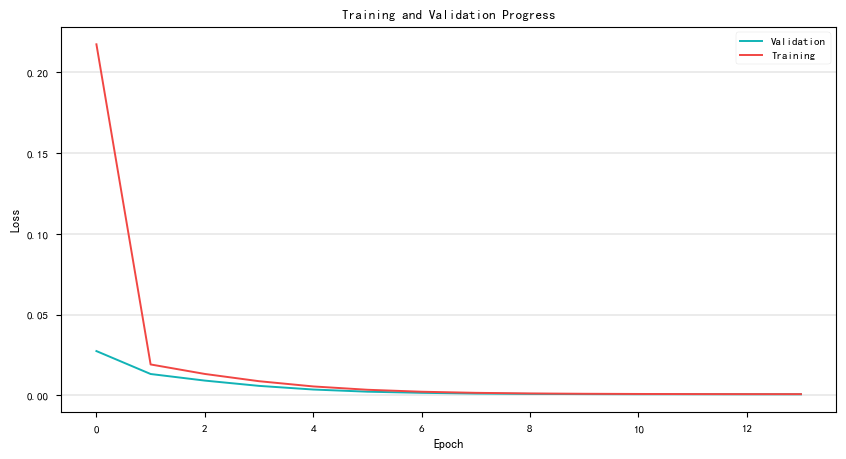

  6%|████▉                                                                              | 1/17 [00:01<00:25,  1.60s/it]

Epoch [1/17], Training Loss: 0.0133, Validation Loss: 0.0058
Validation loss decreased (inf --> 0.005775).  Saving model ...
Updating learning rate to 0.000991486549841951


 12%|█████████▊                                                                         | 2/17 [00:03<00:24,  1.61s/it]

Epoch [2/17], Training Loss: 0.0048, Validation Loss: 0.0029
Validation loss decreased (0.005775 --> 0.002932).  Saving model ...
Updating learning rate to 0.0009662361147021779


 18%|██████████████▋                                                                    | 3/17 [00:04<00:22,  1.64s/it]

Epoch [3/17], Training Loss: 0.0026, Validation Loss: 0.0018
Validation loss decreased (0.002932 --> 0.001831).  Saving model ...
Updating learning rate to 0.0009251085678648072


 24%|███████████████████▌                                                               | 4/17 [00:06<00:21,  1.65s/it]

Epoch [4/17], Training Loss: 0.0017, Validation Loss: 0.0013
Validation loss decreased (0.001831 --> 0.001321).  Saving model ...
Updating learning rate to 0.0008695044586103295


 29%|████████████████████████▍                                                          | 5/17 [00:08<00:20,  1.70s/it]

Epoch [5/17], Training Loss: 0.0013, Validation Loss: 0.0011
Validation loss decreased (0.001321 --> 0.001103).  Saving model ...
Updating learning rate to 0.0008013173181896282


 35%|█████████████████████████████▎                                                     | 6/17 [00:10<00:18,  1.68s/it]

Epoch [6/17], Training Loss: 0.0011, Validation Loss: 0.0010
Validation loss decreased (0.001103 --> 0.000987).  Saving model ...
Updating learning rate to 0.0007228691778882692


 41%|██████████████████████████████████▏                                                | 7/17 [00:11<00:16,  1.65s/it]

Epoch [7/17], Training Loss: 0.0010, Validation Loss: 0.0009
Validation loss decreased (0.000987 --> 0.000926).  Saving model ...
Updating learning rate to 0.0006368314950360416


 47%|███████████████████████████████████████                                            | 8/17 [00:13<00:14,  1.65s/it]

Epoch [8/17], Training Loss: 0.0010, Validation Loss: 0.0009
Validation loss decreased (0.000926 --> 0.000908).  Saving model ...
Updating learning rate to 0.000546134179731651


 53%|███████████████████████████████████████████▉                                       | 9/17 [00:14<00:13,  1.64s/it]

Epoch [9/17], Training Loss: 0.0010, Validation Loss: 0.0009
Validation loss decreased (0.000908 --> 0.000886).  Saving model ...
Updating learning rate to 0.00045386582026834903


 59%|████████████████████████████████████████████████▏                                 | 10/17 [00:16<00:11,  1.63s/it]

Epoch [10/17], Training Loss: 0.0009, Validation Loss: 0.0009
Validation loss decreased (0.000886 --> 0.000864).  Saving model ...
Updating learning rate to 0.0003631685049639586


 65%|█████████████████████████████████████████████████████                             | 11/17 [00:18<00:09,  1.63s/it]

Epoch [11/17], Training Loss: 0.0009, Validation Loss: 0.0009
Validation loss decreased (0.000864 --> 0.000860).  Saving model ...
Updating learning rate to 0.0002771308221117309


 71%|█████████████████████████████████████████████████████████▉                        | 12/17 [00:19<00:08,  1.63s/it]

Epoch [12/17], Training Loss: 0.0009, Validation Loss: 0.0009
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00019868268181037185


 76%|██████████████████████████████████████████████████████████████▋                   | 13/17 [00:21<00:06,  1.62s/it]

Epoch [13/17], Training Loss: 0.0009, Validation Loss: 0.0009
Validation loss decreased (0.000860 --> 0.000855).  Saving model ...
Updating learning rate to 0.0001304955413896705


 82%|███████████████████████████████████████████████████████████████████▌              | 14/17 [00:22<00:04,  1.61s/it]

Epoch [14/17], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000855 --> 0.000846).  Saving model ...
Updating learning rate to 7.489143213519301e-05


 88%|████████████████████████████████████████████████████████████████████████▎         | 15/17 [00:24<00:03,  1.67s/it]

Epoch [15/17], Training Loss: 0.0009, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 5
Updating learning rate to 3.376388529782215e-05


 94%|█████████████████████████████████████████████████████████████████████████████▏    | 16/17 [00:26<00:01,  1.74s/it]

Epoch [16/17], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000846 --> 0.000845).  Saving model ...
Updating learning rate to 8.513450158049108e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:28<00:00,  1.68s/it]

Epoch [17/17], Training Loss: 0.0009, Validation Loss: 0.0008
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


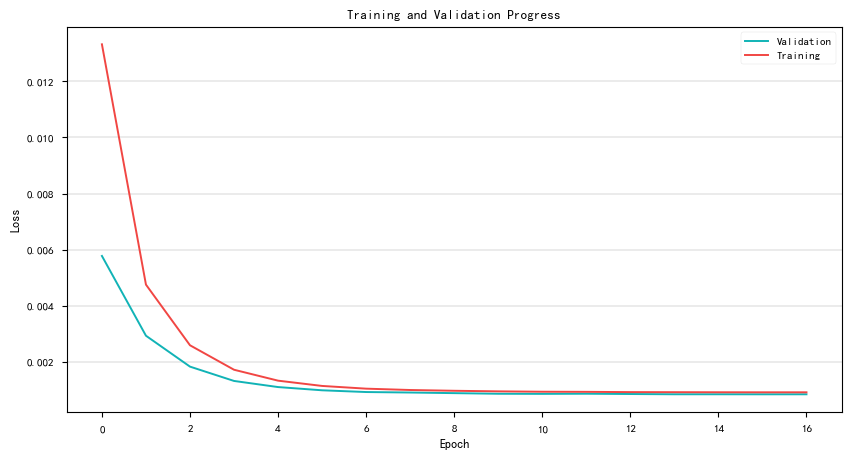

  7%|█████▌                                                                             | 1/15 [00:03<00:51,  3.68s/it]

Epoch [1/15], Training Loss: 0.0088, Validation Loss: 0.0029
Validation loss decreased (inf --> 0.002934).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:07<00:48,  3.75s/it]

Epoch [2/15], Training Loss: 0.0026, Validation Loss: 0.0017
Validation loss decreased (0.002934 --> 0.001676).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:11<00:45,  3.81s/it]

Epoch [3/15], Training Loss: 0.0017, Validation Loss: 0.0014
Validation loss decreased (0.001676 --> 0.001357).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:15<00:42,  3.86s/it]

Epoch [4/15], Training Loss: 0.0014, Validation Loss: 0.0013
Validation loss decreased (0.001357 --> 0.001253).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:19<00:40,  4.07s/it]

Epoch [5/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001253 --> 0.001221).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:24<00:38,  4.26s/it]

Epoch [6/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001221 --> 0.001206).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:28<00:33,  4.14s/it]

Epoch [7/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001206 --> 0.001205).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:32<00:28,  4.07s/it]

Epoch [8/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001205 --> 0.001193).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:36<00:24,  4.01s/it]

Epoch [9/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:39<00:19,  3.94s/it]

Epoch [10/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001193 --> 0.001193).  Saving model ...
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:43<00:15,  3.80s/it]

Epoch [11/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001193 --> 0.001186).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:46<00:11,  3.76s/it]

Epoch [12/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 5
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:50<00:07,  3.70s/it]

Epoch [13/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 2 out of 5
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:54<00:03,  3.80s/it]

Epoch [14/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 3 out of 5
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.91s/it]

Epoch [15/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001186 --> 0.001186).  Saving model ...
Updating learning rate to 0.0


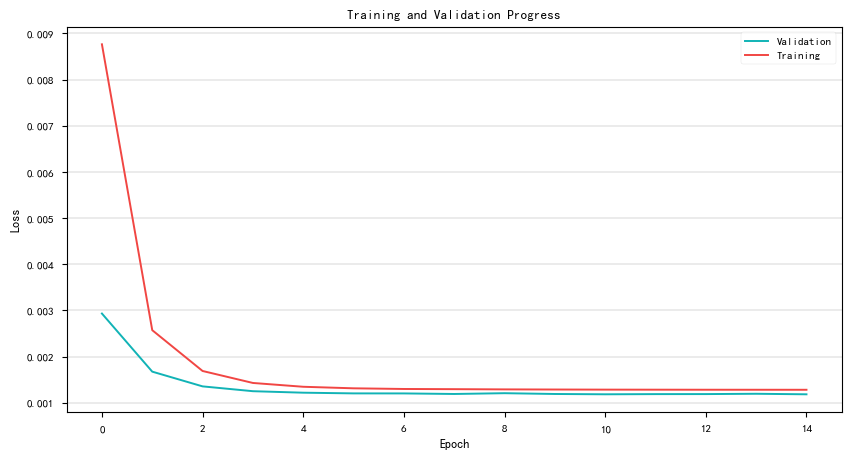

  7%|█████▉                                                                             | 1/14 [00:01<00:22,  1.73s/it]

Epoch [1/14], Training Loss: 0.0039, Validation Loss: 0.0026
Validation loss decreased (inf --> 0.002604).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:03<00:20,  1.69s/it]

Epoch [2/14], Training Loss: 0.0024, Validation Loss: 0.0016
Validation loss decreased (0.002604 --> 0.001557).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:04<00:18,  1.65s/it]

Epoch [3/14], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001557 --> 0.000984).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:06<00:16,  1.63s/it]

Epoch [4/14], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.000984 --> 0.000677).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:08<00:14,  1.58s/it]

Epoch [5/14], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000677 --> 0.000542).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:09<00:12,  1.57s/it]

Epoch [6/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000542 --> 0.000470).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:11<00:11,  1.59s/it]

Epoch [7/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000470 --> 0.000438).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:12<00:09,  1.57s/it]

Epoch [8/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000438 --> 0.000427).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:14<00:07,  1.54s/it]

Epoch [9/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000427 --> 0.000418).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:15<00:06,  1.53s/it]

Epoch [10/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000418 --> 0.000408).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:17<00:04,  1.57s/it]

Epoch [11/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000408 --> 0.000408).  Saving model ...
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:19<00:03,  1.58s/it]

Epoch [12/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000408 --> 0.000405).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:20<00:01,  1.56s/it]

Epoch [13/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000405 --> 0.000404).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:22<00:00,  1.57s/it]

Epoch [14/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


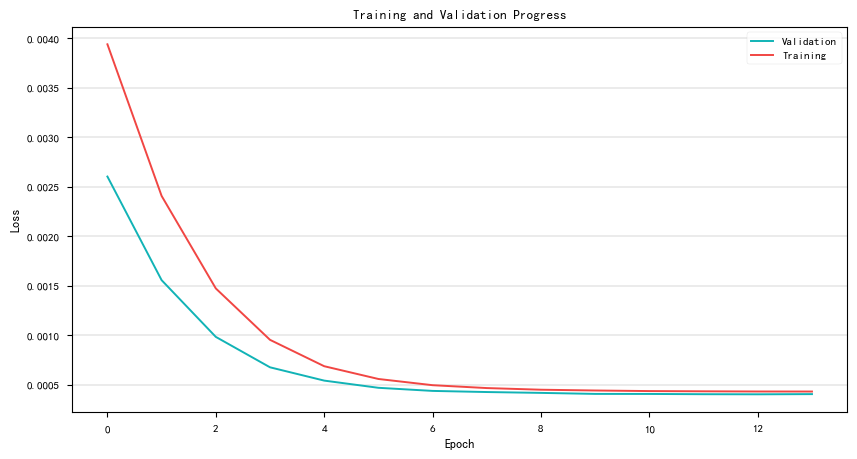

  7%|█████▉                                                                             | 1/14 [00:01<00:19,  1.51s/it]

Epoch [1/14], Training Loss: 0.0039, Validation Loss: 0.0025
Validation loss decreased (inf --> 0.002550).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:02<00:17,  1.50s/it]

Epoch [2/14], Training Loss: 0.0024, Validation Loss: 0.0016
Validation loss decreased (0.002550 --> 0.001558).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:04<00:16,  1.49s/it]

Epoch [3/14], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001558 --> 0.000992).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:06<00:15,  1.57s/it]

Epoch [4/14], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.000992 --> 0.000723).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:07<00:14,  1.61s/it]

Epoch [5/14], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000723 --> 0.000554).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:09<00:13,  1.66s/it]

Epoch [6/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000554 --> 0.000484).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:11<00:12,  1.75s/it]

Epoch [7/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000484 --> 0.000449).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:13<00:10,  1.76s/it]

Epoch [8/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000449 --> 0.000430).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:15<00:08,  1.74s/it]

Epoch [9/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000430 --> 0.000418).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:16<00:06,  1.71s/it]

Epoch [10/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:18<00:04,  1.66s/it]

Epoch [11/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000418 --> 0.000409).  Saving model ...
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:19<00:03,  1.65s/it]

Epoch [12/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:21<00:01,  1.69s/it]

Epoch [13/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000409 --> 0.000408).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.67s/it]

Epoch [14/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


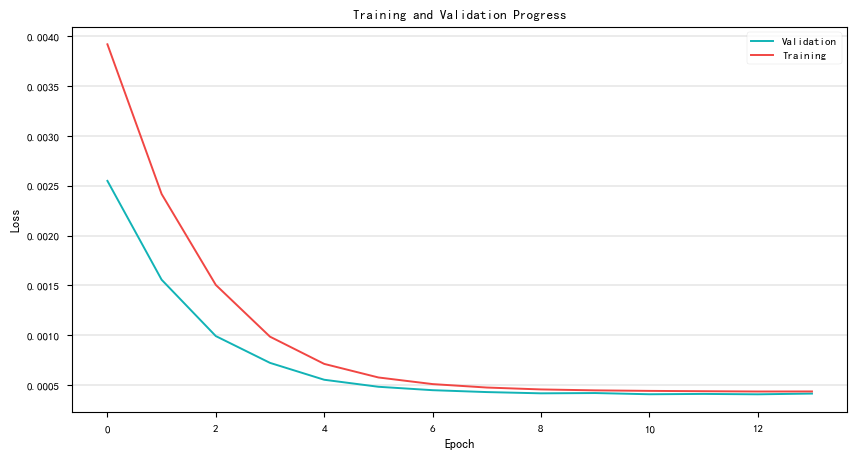

  7%|█████▉                                                                             | 1/14 [00:01<00:22,  1.75s/it]

Epoch [1/14], Training Loss: 0.0115, Validation Loss: 0.0040
Validation loss decreased (inf --> 0.004014).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:03<00:20,  1.72s/it]

Epoch [2/14], Training Loss: 0.0036, Validation Loss: 0.0023
Validation loss decreased (0.004014 --> 0.002335).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:05<00:18,  1.69s/it]

Epoch [3/14], Training Loss: 0.0023, Validation Loss: 0.0016
Validation loss decreased (0.002335 --> 0.001607).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:06<00:16,  1.69s/it]

Epoch [4/14], Training Loss: 0.0016, Validation Loss: 0.0012
Validation loss decreased (0.001607 --> 0.001179).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:08<00:15,  1.70s/it]

Epoch [5/14], Training Loss: 0.0012, Validation Loss: 0.0009
Validation loss decreased (0.001179 --> 0.000886).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:10<00:13,  1.67s/it]

Epoch [6/14], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.000886 --> 0.000708).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:11<00:11,  1.68s/it]

Epoch [7/14], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000708 --> 0.000591).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:13<00:10,  1.69s/it]

Epoch [8/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000591 --> 0.000522).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:15<00:08,  1.70s/it]

Epoch [9/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000522 --> 0.000485).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:16<00:06,  1.68s/it]

Epoch [10/14], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000485 --> 0.000455).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:18<00:05,  1.67s/it]

Epoch [11/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000455 --> 0.000445).  Saving model ...
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:20<00:03,  1.66s/it]

Epoch [12/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000445 --> 0.000443).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:21<00:01,  1.66s/it]

Epoch [13/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000443 --> 0.000437).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:23<00:00,  1.68s/it]

Epoch [14/14], Training Loss: 0.0005, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


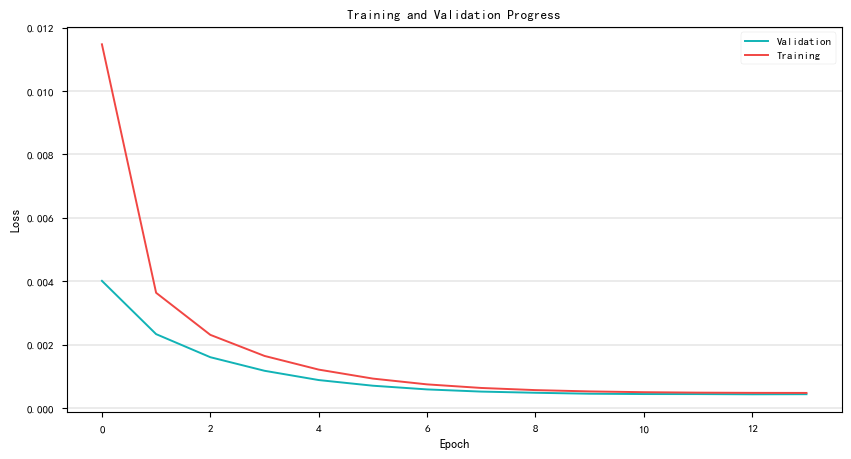

  8%|██████▉                                                                            | 1/12 [00:01<00:16,  1.53s/it]

Epoch [1/12], Training Loss: 0.0303, Validation Loss: 0.0111
Validation loss decreased (inf --> 0.011141).  Saving model ...
Updating learning rate to 0.0009829629131445341


 17%|█████████████▊                                                                     | 2/12 [00:03<00:15,  1.56s/it]

Epoch [2/12], Training Loss: 0.0103, Validation Loss: 0.0057
Validation loss decreased (0.011141 --> 0.005701).  Saving model ...
Updating learning rate to 0.0009330127018922195


 25%|████████████████████▊                                                              | 3/12 [00:04<00:14,  1.56s/it]

Epoch [3/12], Training Loss: 0.0054, Validation Loss: 0.0031
Validation loss decreased (0.005701 --> 0.003095).  Saving model ...
Updating learning rate to 0.0008535533905932737


 33%|███████████████████████████▋                                                       | 4/12 [00:06<00:12,  1.54s/it]

Epoch [4/12], Training Loss: 0.0030, Validation Loss: 0.0019
Validation loss decreased (0.003095 --> 0.001887).  Saving model ...
Updating learning rate to 0.00075


 42%|██████████████████████████████████▌                                                | 5/12 [00:07<00:10,  1.53s/it]

Epoch [5/12], Training Loss: 0.0019, Validation Loss: 0.0013
Validation loss decreased (0.001887 --> 0.001331).  Saving model ...
Updating learning rate to 0.0006294095225512603


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:09<00:09,  1.53s/it]

Epoch [6/12], Training Loss: 0.0014, Validation Loss: 0.0010
Validation loss decreased (0.001331 --> 0.001040).  Saving model ...
Updating learning rate to 0.0005


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:10<00:07,  1.53s/it]

Epoch [7/12], Training Loss: 0.0011, Validation Loss: 0.0009
Validation loss decreased (0.001040 --> 0.000873).  Saving model ...
Updating learning rate to 0.0003705904774487396


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:12<00:06,  1.53s/it]

Epoch [8/12], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000873 --> 0.000758).  Saving model ...
Updating learning rate to 0.0002500000000000001


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:13<00:04,  1.53s/it]

Epoch [9/12], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000758 --> 0.000695).  Saving model ...
Updating learning rate to 0.00014644660940672628


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:15<00:03,  1.53s/it]

Epoch [10/12], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000695 --> 0.000665).  Saving model ...
Updating learning rate to 6.698729810778065e-05


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:16<00:01,  1.56s/it]

Epoch [11/12], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000665 --> 0.000649).  Saving model ...
Updating learning rate to 1.70370868554659e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.54s/it]

Epoch [12/12], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000649 --> 0.000648).  Saving model ...
Updating learning rate to 0.0


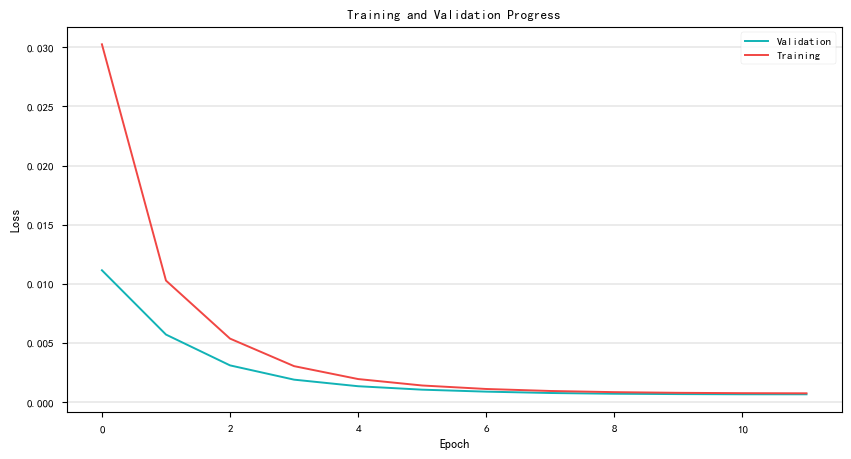

 20%|████████████████▊                                                                   | 1/5 [00:03<00:14,  3.57s/it]

Epoch [1/5], Training Loss: 0.0139, Validation Loss: 0.0031
Validation loss decreased (inf --> 0.003135).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:07<00:10,  3.62s/it]

Epoch [2/5], Training Loss: 0.0022, Validation Loss: 0.0011
Validation loss decreased (0.003135 --> 0.001073).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:10<00:07,  3.65s/it]

Epoch [3/5], Training Loss: 0.0009, Validation Loss: 0.0006
Validation loss decreased (0.001073 --> 0.000634).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:14<00:03,  3.63s/it]

Epoch [4/5], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000634 --> 0.000496).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.62s/it]

Epoch [5/5], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000496 --> 0.000467).  Saving model ...
Updating learning rate to 0.0


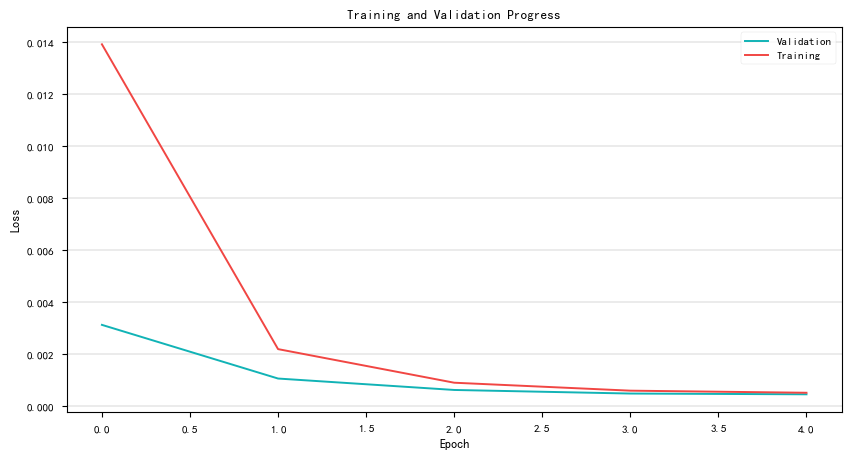

 10%|████████▎                                                                          | 1/10 [00:01<00:14,  1.58s/it]

Epoch [1/10], Training Loss: 0.0092, Validation Loss: 0.0036
Validation loss decreased (inf --> 0.003643).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:03<00:12,  1.58s/it]

Epoch [2/10], Training Loss: 0.0030, Validation Loss: 0.0019
Validation loss decreased (0.003643 --> 0.001859).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:11,  1.58s/it]

Epoch [3/10], Training Loss: 0.0017, Validation Loss: 0.0012
Validation loss decreased (0.001859 --> 0.001176).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.60s/it]

Epoch [4/10], Training Loss: 0.0011, Validation Loss: 0.0008
Validation loss decreased (0.001176 --> 0.000843).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:08,  1.61s/it]

Epoch [5/10], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000843 --> 0.000664).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:09<00:06,  1.61s/it]

Epoch [6/10], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000664 --> 0.000576).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:04,  1.62s/it]

Epoch [7/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000576 --> 0.000529).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:12<00:03,  1.62s/it]

Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000529 --> 0.000512).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:14<00:01,  1.65s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000512 --> 0.000495).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000495 --> 0.000494).  Saving model ...
Updating learning rate to 0.0


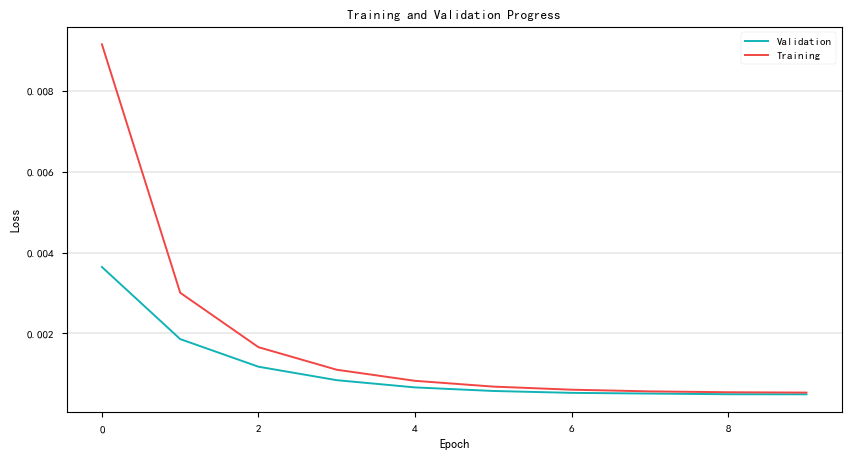

  7%|█████▌                                                                             | 1/15 [00:04<00:57,  4.09s/it]

Epoch [1/15], Training Loss: 0.0106, Validation Loss: 0.0032
Validation loss decreased (inf --> 0.003233).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:08<00:53,  4.13s/it]

Epoch [2/15], Training Loss: 0.0027, Validation Loss: 0.0017
Validation loss decreased (0.003233 --> 0.001712).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:12<00:49,  4.11s/it]

Epoch [3/15], Training Loss: 0.0017, Validation Loss: 0.0013
Validation loss decreased (0.001712 --> 0.001344).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:16<00:44,  4.08s/it]

Epoch [4/15], Training Loss: 0.0014, Validation Loss: 0.0012
Validation loss decreased (0.001344 --> 0.001238).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:20<00:39,  3.99s/it]

Epoch [5/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001238 --> 0.001213).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:23<00:34,  3.86s/it]

Epoch [6/15], Training Loss: 0.0013, Validation Loss: 0.0012
Validation loss decreased (0.001213 --> 0.001189).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:27<00:31,  3.89s/it]

Epoch [7/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:31<00:27,  3.95s/it]

Epoch [8/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:35<00:23,  3.88s/it]

Epoch [9/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:39<00:18,  3.78s/it]

Epoch [10/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0002500000000000001


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:42<00:21,  4.26s/it]

Epoch [11/15], Training Loss: 0.0013, Validation Loss: 0.0012
EarlyStopping counter: 5 out of 5
Early stopping!


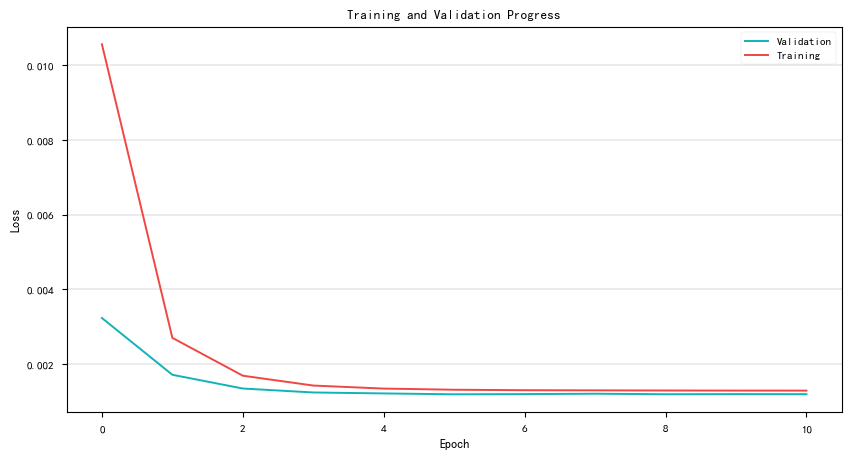

  7%|█████▉                                                                             | 1/14 [00:01<00:19,  1.49s/it]

Epoch [1/14], Training Loss: 0.0039, Validation Loss: 0.0026
Validation loss decreased (inf --> 0.002554).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:03<00:18,  1.52s/it]

Epoch [2/14], Training Loss: 0.0024, Validation Loss: 0.0016
Validation loss decreased (0.002554 --> 0.001564).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:04<00:16,  1.52s/it]

Epoch [3/14], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001564 --> 0.001034).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:06<00:15,  1.55s/it]

Epoch [4/14], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001034 --> 0.000714).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:07<00:13,  1.54s/it]

Epoch [5/14], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000714 --> 0.000556).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:09<00:12,  1.54s/it]

Epoch [6/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000556 --> 0.000498).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:10<00:10,  1.54s/it]

Epoch [7/14], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000498 --> 0.000453).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:12<00:09,  1.53s/it]

Epoch [8/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000453 --> 0.000426).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:13<00:07,  1.51s/it]

Epoch [9/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000426 --> 0.000423).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:15<00:06,  1.53s/it]

Epoch [10/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000423 --> 0.000420).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:16<00:04,  1.55s/it]

Epoch [11/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000420 --> 0.000410).  Saving model ...
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:18<00:03,  1.55s/it]

Epoch [12/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000410 --> 0.000408).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:19<00:01,  1.54s/it]

Epoch [13/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000408 --> 0.000405).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.54s/it]

Epoch [14/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


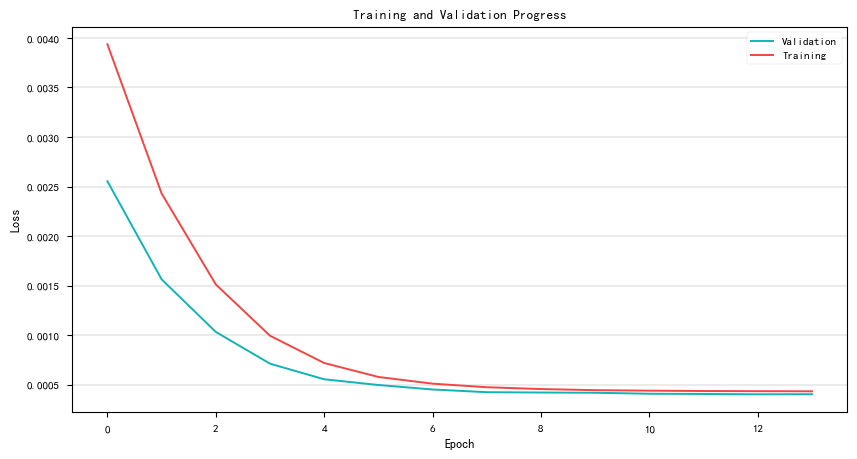

 20%|████████████████▊                                                                   | 1/5 [00:03<00:14,  3.55s/it]

Epoch [1/5], Training Loss: 0.0088, Validation Loss: 0.0025
Validation loss decreased (inf --> 0.002459).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:10,  3.46s/it]

Epoch [2/5], Training Loss: 0.0017, Validation Loss: 0.0011
Validation loss decreased (0.002459 --> 0.001090).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:10<00:06,  3.44s/it]

Epoch [3/5], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.001090 --> 0.000847).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:13<00:03,  3.43s/it]

Epoch [4/5], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000847 --> 0.000799).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]

Epoch [5/5], Training Loss: 0.0009, Validation Loss: 0.0008
Validation loss decreased (0.000799 --> 0.000794).  Saving model ...
Updating learning rate to 0.0


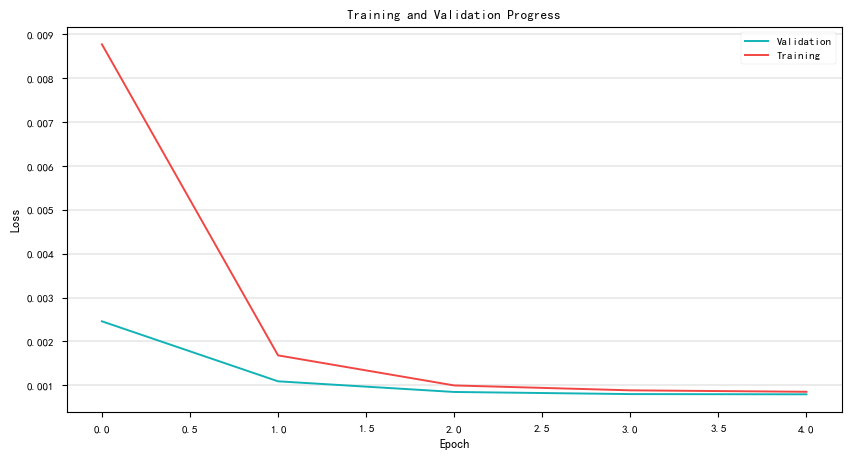

 10%|████████▎                                                                          | 1/10 [00:01<00:15,  1.69s/it]

Epoch [1/10], Training Loss: 0.0077, Validation Loss: 0.0029
Validation loss decreased (inf --> 0.002935).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:03<00:13,  1.65s/it]

Epoch [2/10], Training Loss: 0.0025, Validation Loss: 0.0015
Validation loss decreased (0.002935 --> 0.001505).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:11,  1.62s/it]

Epoch [3/10], Training Loss: 0.0014, Validation Loss: 0.0010
Validation loss decreased (0.001505 --> 0.001024).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.61s/it]

Epoch [4/10], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.001024 --> 0.000747).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:08<00:08,  1.62s/it]

Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000747 --> 0.000613).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:09<00:06,  1.63s/it]

Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000613 --> 0.000545).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:11<00:04,  1.63s/it]

Epoch [7/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000545 --> 0.000510).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:13<00:03,  1.63s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000510 --> 0.000488).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:14<00:01,  1.60s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000488 --> 0.000481).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000481 --> 0.000478).  Saving model ...
Updating learning rate to 0.0


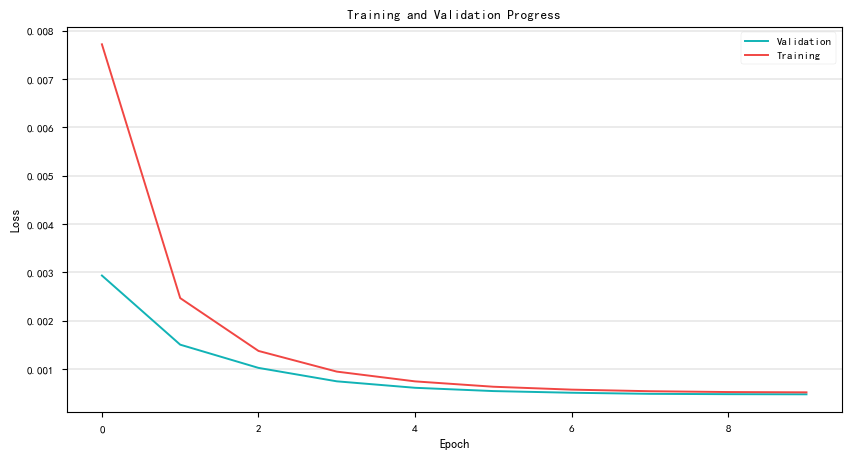

  7%|█████▉                                                                             | 1/14 [00:01<00:20,  1.60s/it]

Epoch [1/14], Training Loss: 0.0090, Validation Loss: 0.0033
Validation loss decreased (inf --> 0.003308).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:03<00:19,  1.59s/it]

Epoch [2/14], Training Loss: 0.0033, Validation Loss: 0.0022
Validation loss decreased (0.003308 --> 0.002224).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:04<00:17,  1.55s/it]

Epoch [3/14], Training Loss: 0.0023, Validation Loss: 0.0016
Validation loss decreased (0.002224 --> 0.001585).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:06<00:15,  1.55s/it]

Epoch [4/14], Training Loss: 0.0016, Validation Loss: 0.0011
Validation loss decreased (0.001585 --> 0.001127).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:07<00:14,  1.57s/it]

Epoch [5/14], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.001127 --> 0.000845).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:09<00:12,  1.56s/it]

Epoch [6/14], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.000845 --> 0.000670).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:10<00:10,  1.56s/it]

Epoch [7/14], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000670 --> 0.000557).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:12<00:09,  1.54s/it]

Epoch [8/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000557 --> 0.000508).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:13<00:07,  1.54s/it]

Epoch [9/14], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000508 --> 0.000468).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:15<00:06,  1.53s/it]

Epoch [10/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000468 --> 0.000442).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:17<00:04,  1.53s/it]

Epoch [11/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000442 --> 0.000432).  Saving model ...
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:18<00:03,  1.54s/it]

Epoch [12/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000432 --> 0.000420).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:20<00:01,  1.53s/it]

Epoch [13/14], Training Loss: 0.0005, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.54s/it]

Epoch [14/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000420 --> 0.000419).  Saving model ...
Updating learning rate to 0.0


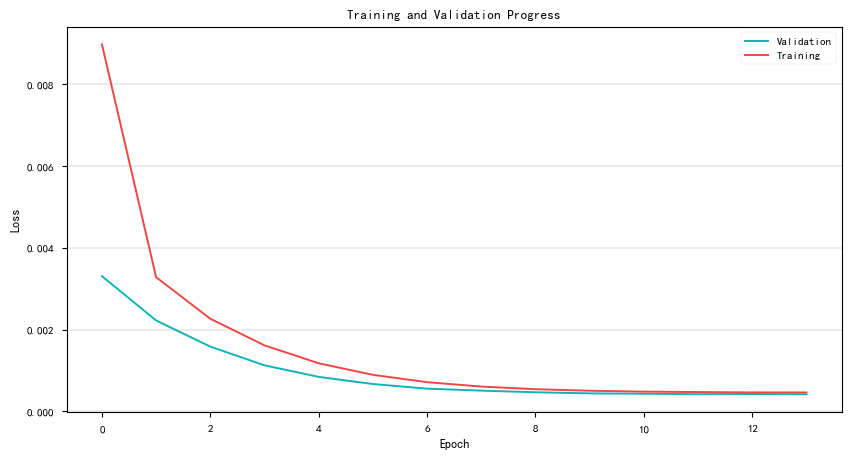

In [19]:
from sko.GA import GA

# 构造参数字典
ga_args = {
    "func": fitness, # 适应度函数，最小化问题
    "n_dim": 4, # 优化参数维度
    "lb": [3, 1, 16, 5], # 下边界，分别为回视窗口、预测维度、批量大小、迭代次数
    "ub": [20, 3, 64, 20], # 上边界，分别为回视窗口、预测维度、批量大小、迭代次数
    "size_pop": 10, 
    "max_iter": 2, # 最大迭代次数，需遍历
    "prob_mut": 0.001,
    "precision": 1e-7
}

#函数传参，运行次数：size_pop*max_iter*n_epochs
ga = GA(**ga_args)

# 执行优化程序
best_x, best_y = ga.run()

In [20]:
x1, x2, x3, x4 = best_x
print('最优适应度值：',best_y)
print('最优解[回视窗口]：', int(x1))
print('最优解[预测维度]：', int(x2))
print('最优解[批量大小]：', int(x3))
print('最优解[迭代次数]：', int(x4))

最优适应度值： [0.00041855]
最优解[回视窗口]： 3
最优解[预测维度]： 1
最优解[批量大小]： 46
最优解[迭代次数]： 14


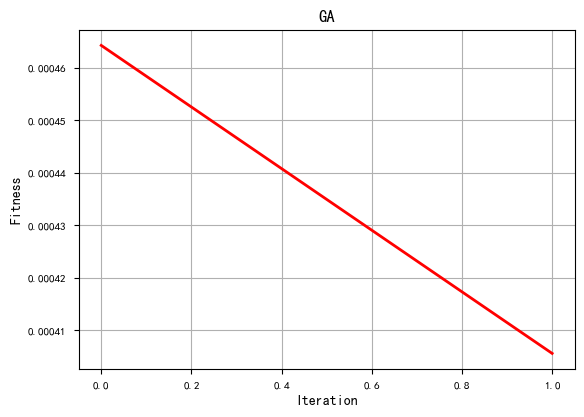

In [21]:
#绘制适应度曲线
Y_history = pd.DataFrame(ga.all_history_Y)
plt.figure(1)
plt.plot(Y_history.min(axis=1).cummin(),'r-',linewidth=2)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('GA',fontsize='large')
plt.show()

### 麻雀搜索算法

 14%|████████████                                                                        | 1/7 [00:01<00:11,  1.98s/it]

Epoch [1/7], Training Loss: 0.0125, Validation Loss: 0.0045
Validation loss decreased (inf --> 0.004500).  Saving model ...
Updating learning rate to 0.0009504844339512095


 29%|████████████████████████                                                            | 2/7 [00:03<00:09,  1.93s/it]

Epoch [2/7], Training Loss: 0.0036, Validation Loss: 0.0020
Validation loss decreased (0.004500 --> 0.002032).  Saving model ...
Updating learning rate to 0.0008117449009293668


 43%|████████████████████████████████████                                                | 3/7 [00:05<00:07,  1.90s/it]

Epoch [3/7], Training Loss: 0.0018, Validation Loss: 0.0012
Validation loss decreased (0.002032 --> 0.001184).  Saving model ...
Updating learning rate to 0.0006112604669781572


 57%|████████████████████████████████████████████████                                    | 4/7 [00:07<00:05,  1.90s/it]

Epoch [4/7], Training Loss: 0.0011, Validation Loss: 0.0008
Validation loss decreased (0.001184 --> 0.000842).  Saving model ...
Updating learning rate to 0.00038873953302184284


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:09<00:03,  1.90s/it]

Epoch [5/7], Training Loss: 0.0008, Validation Loss: 0.0007
Validation loss decreased (0.000842 --> 0.000697).  Saving model ...
Updating learning rate to 0.00018825509907063325


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:11<00:01,  1.91s/it]

Epoch [6/7], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000697 --> 0.000634).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.90s/it]

Epoch [7/7], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000634 --> 0.000621).  Saving model ...
Updating learning rate to 0.0


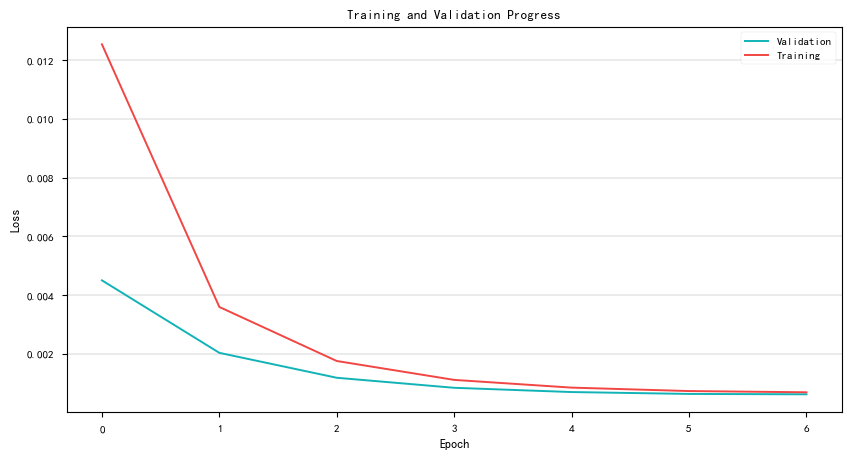

  6%|█████▏                                                                             | 1/16 [00:02<00:30,  2.06s/it]

Epoch [1/16], Training Loss: 0.0069, Validation Loss: 0.0025
Validation loss decreased (inf --> 0.002500).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:04<00:28,  2.03s/it]

Epoch [2/16], Training Loss: 0.0020, Validation Loss: 0.0012
Validation loss decreased (0.002500 --> 0.001192).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:06<00:26,  2.03s/it]

Epoch [3/16], Training Loss: 0.0011, Validation Loss: 0.0008
Validation loss decreased (0.001192 --> 0.000772).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:08<00:23,  2.00s/it]

Epoch [4/16], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000772 --> 0.000563).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:10<00:21,  2.00s/it]

Epoch [5/16], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000563 --> 0.000465).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:12<00:19,  1.99s/it]

Epoch [6/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000465 --> 0.000415).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:13<00:17,  1.98s/it]

Epoch [7/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000415 --> 0.000393).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:16<00:15,  2.00s/it]

Epoch [8/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:17<00:13,  1.98s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000393 --> 0.000379).  Saving model ...
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:19<00:11,  1.99s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:21<00:09,  2.00s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000379 --> 0.000378).  Saving model ...
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:23<00:07,  1.98s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000378 --> 0.000371).  Saving model ...
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:25<00:05,  1.98s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:27<00:03,  1.98s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:29<00:01,  1.99s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.99s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0


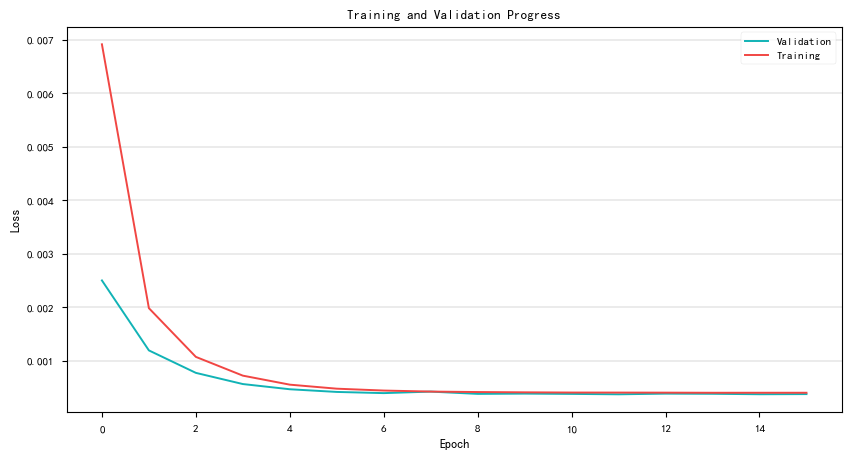

  8%|██████▍                                                                            | 1/13 [00:01<00:17,  1.47s/it]

Epoch [1/13], Training Loss: 0.0153, Validation Loss: 0.0073
Validation loss decreased (inf --> 0.007318).  Saving model ...
Updating learning rate to 0.000985470908713026


 15%|████████████▊                                                                      | 2/13 [00:02<00:15,  1.42s/it]

Epoch [2/13], Training Loss: 0.0072, Validation Loss: 0.0047
Validation loss decreased (0.007318 --> 0.004692).  Saving model ...
Updating learning rate to 0.0009427280128266049


 23%|███████████████████▏                                                               | 3/13 [00:04<00:14,  1.43s/it]

Epoch [3/13], Training Loss: 0.0049, Validation Loss: 0.0034
Validation loss decreased (0.004692 --> 0.003416).  Saving model ...
Updating learning rate to 0.0008742553740855505


 31%|█████████████████████████▌                                                         | 4/13 [00:05<00:12,  1.41s/it]

Epoch [4/13], Training Loss: 0.0037, Validation Loss: 0.0027
Validation loss decreased (0.003416 --> 0.002731).  Saving model ...
Updating learning rate to 0.0007840323733655779


 38%|███████████████████████████████▉                                                   | 5/13 [00:07<00:11,  1.40s/it]

Epoch [5/13], Training Loss: 0.0030, Validation Loss: 0.0023
Validation loss decreased (0.002731 --> 0.002257).  Saving model ...
Updating learning rate to 0.0006773024435212678


 46%|██████████████████████████████████████▎                                            | 6/13 [00:08<00:09,  1.41s/it]

Epoch [6/13], Training Loss: 0.0025, Validation Loss: 0.0020
Validation loss decreased (0.002257 --> 0.001991).  Saving model ...
Updating learning rate to 0.0005602683401276614


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:09<00:08,  1.40s/it]

Epoch [7/13], Training Loss: 0.0022, Validation Loss: 0.0018
Validation loss decreased (0.001991 --> 0.001801).  Saving model ...
Updating learning rate to 0.00043973165987233853


 62%|███████████████████████████████████████████████████                                | 8/13 [00:11<00:06,  1.39s/it]

Epoch [8/13], Training Loss: 0.0020, Validation Loss: 0.0017
Validation loss decreased (0.001801 --> 0.001686).  Saving model ...
Updating learning rate to 0.00032269755647873217


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:12<00:05,  1.41s/it]

Epoch [9/13], Training Loss: 0.0019, Validation Loss: 0.0016
Validation loss decreased (0.001686 --> 0.001612).  Saving model ...
Updating learning rate to 0.00021596762663442215


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:14<00:04,  1.43s/it]

Epoch [10/13], Training Loss: 0.0018, Validation Loss: 0.0016
Validation loss decreased (0.001612 --> 0.001565).  Saving model ...
Updating learning rate to 0.0001257446259144494


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:15<00:02,  1.43s/it]

Epoch [11/13], Training Loss: 0.0018, Validation Loss: 0.0016
Validation loss decreased (0.001565 --> 0.001552).  Saving model ...
Updating learning rate to 5.72719871733951e-05


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:16<00:01,  1.41s/it]

Epoch [12/13], Training Loss: 0.0018, Validation Loss: 0.0015
Validation loss decreased (0.001552 --> 0.001538).  Saving model ...
Updating learning rate to 1.4529091286973995e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.41s/it]

Epoch [13/13], Training Loss: 0.0018, Validation Loss: 0.0015
Validation loss decreased (0.001538 --> 0.001530).  Saving model ...
Updating learning rate to 0.0


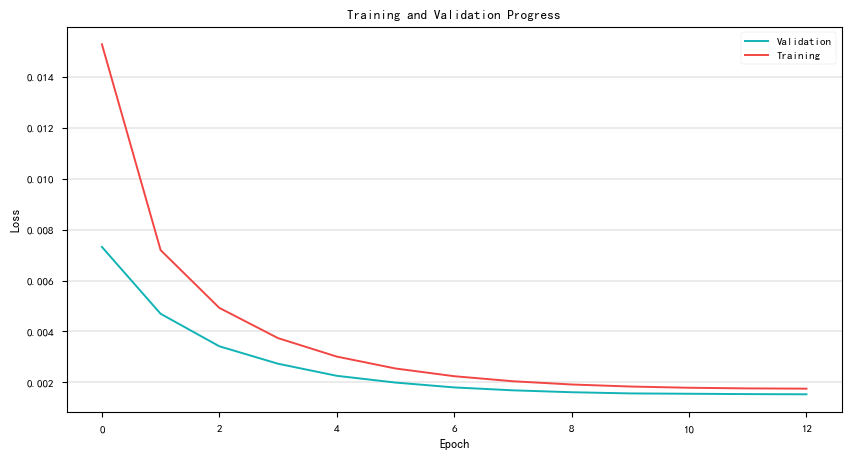

 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.10s/it]

Epoch [1/10], Training Loss: 0.0080, Validation Loss: 0.0030
Validation loss decreased (inf --> 0.003006).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.02s/it]

Epoch [2/10], Training Loss: 0.0023, Validation Loss: 0.0014
Validation loss decreased (0.003006 --> 0.001411).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:14,  2.01s/it]

Epoch [3/10], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.001411 --> 0.000830).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.97s/it]

Epoch [4/10], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000830 --> 0.000598).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.96s/it]

Epoch [5/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000598 --> 0.000508).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  1.96s/it]

Epoch [6/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000508 --> 0.000446).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:05,  1.95s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000446 --> 0.000422).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:15<00:03,  1.96s/it]

Epoch [8/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000422 --> 0.000407).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:17<00:01,  1.96s/it]

Epoch [9/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000407 --> 0.000402).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]

Epoch [10/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000402 --> 0.000397).  Saving model ...
Updating learning rate to 0.0


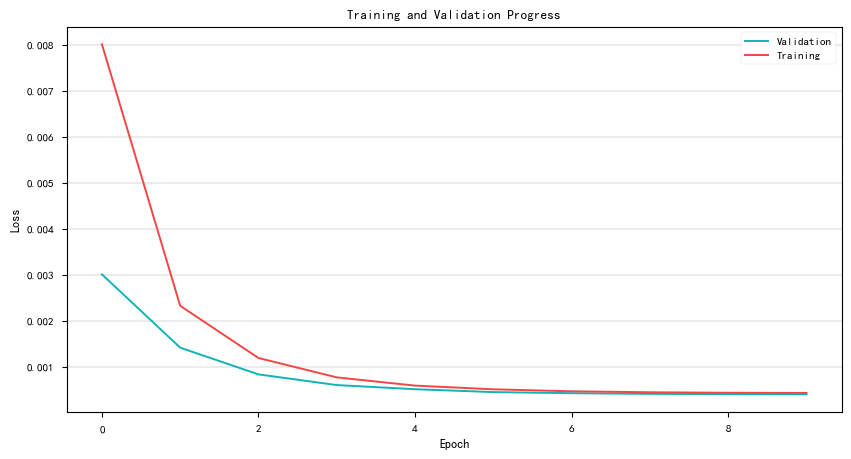

 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.06s/it]

Epoch [1/10], Training Loss: 0.0094, Validation Loss: 0.0032
Validation loss decreased (inf --> 0.003186).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:04<00:16,  2.02s/it]

Epoch [2/10], Training Loss: 0.0026, Validation Loss: 0.0015
Validation loss decreased (0.003186 --> 0.001536).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:14,  2.03s/it]

Epoch [3/10], Training Loss: 0.0013, Validation Loss: 0.0009
Validation loss decreased (0.001536 --> 0.000938).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:08<00:12,  2.16s/it]

Epoch [4/10], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.000938 --> 0.000654).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:10<00:11,  2.24s/it]

Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000654 --> 0.000526).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:13<00:08,  2.22s/it]

Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000526 --> 0.000474).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:15<00:06,  2.21s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000474 --> 0.000441).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:17<00:04,  2.14s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000441 --> 0.000429).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:19<00:02,  2.09s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000429 --> 0.000420).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000420 --> 0.000419).  Saving model ...
Updating learning rate to 0.0


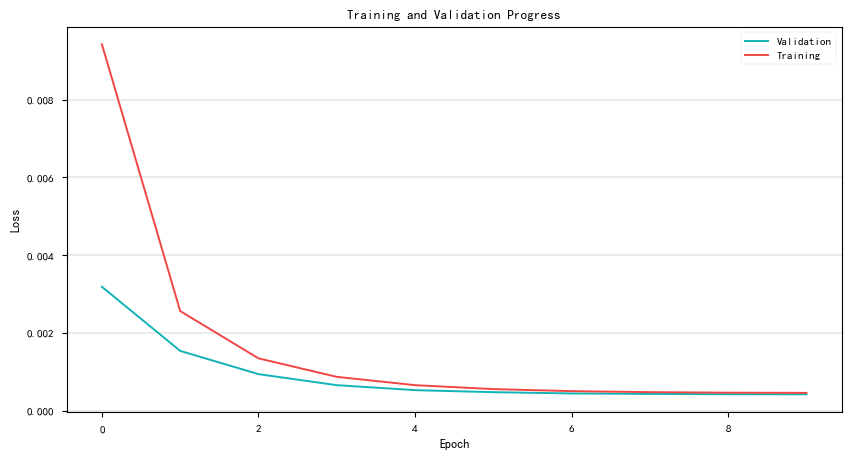

第0次迭代


  6%|█████▏                                                                             | 1/16 [00:02<00:30,  2.00s/it]

Epoch [1/16], Training Loss: 0.0100, Validation Loss: 0.0032
Validation loss decreased (inf --> 0.003248).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:03<00:27,  1.98s/it]

Epoch [2/16], Training Loss: 0.0026, Validation Loss: 0.0015
Validation loss decreased (0.003248 --> 0.001523).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:05<00:25,  1.98s/it]

Epoch [3/16], Training Loss: 0.0013, Validation Loss: 0.0009
Validation loss decreased (0.001523 --> 0.000913).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:07<00:23,  1.98s/it]

Epoch [4/16], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000913 --> 0.000631).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:09<00:21,  1.99s/it]

Epoch [5/16], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000631 --> 0.000495).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:11<00:19,  1.97s/it]

Epoch [6/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000495 --> 0.000431).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:13<00:17,  1.98s/it]

Epoch [7/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000431 --> 0.000401).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:15<00:15,  1.98s/it]

Epoch [8/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000401 --> 0.000385).  Saving model ...
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:17<00:13,  1.97s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000385 --> 0.000379).  Saving model ...
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:19<00:11,  1.99s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000379 --> 0.000374).  Saving model ...
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:21<00:09,  1.99s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:23<00:07,  1.98s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000371).  Saving model ...
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:25<00:05,  1.98s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:27<00:03,  1.97s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:29<00:01,  1.97s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:31<00:00,  1.98s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0


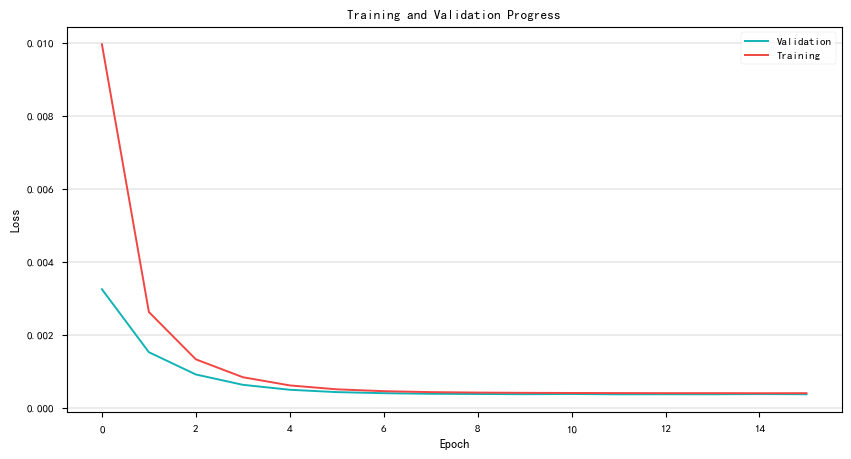

 10%|████████▎                                                                          | 1/10 [00:01<00:17,  1.99s/it]

Epoch [1/10], Training Loss: 0.0273, Validation Loss: 0.0078
Validation loss decreased (inf --> 0.007781).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:03<00:15,  1.95s/it]

Epoch [2/10], Training Loss: 0.0057, Validation Loss: 0.0029
Validation loss decreased (0.007781 --> 0.002856).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.97s/it]

Epoch [3/10], Training Loss: 0.0025, Validation Loss: 0.0016
Validation loss decreased (0.002856 --> 0.001638).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.95s/it]

Epoch [4/10], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001638 --> 0.001039).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.93s/it]

Epoch [5/10], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001039 --> 0.000741).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  1.91s/it]

Epoch [6/10], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000741 --> 0.000597).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:06,  2.06s/it]

Epoch [7/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000597 --> 0.000522).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:15<00:04,  2.03s/it]

Epoch [8/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000522 --> 0.000487).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:17<00:02,  2.02s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000487 --> 0.000473).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000473 --> 0.000470).  Saving model ...
Updating learning rate to 0.0


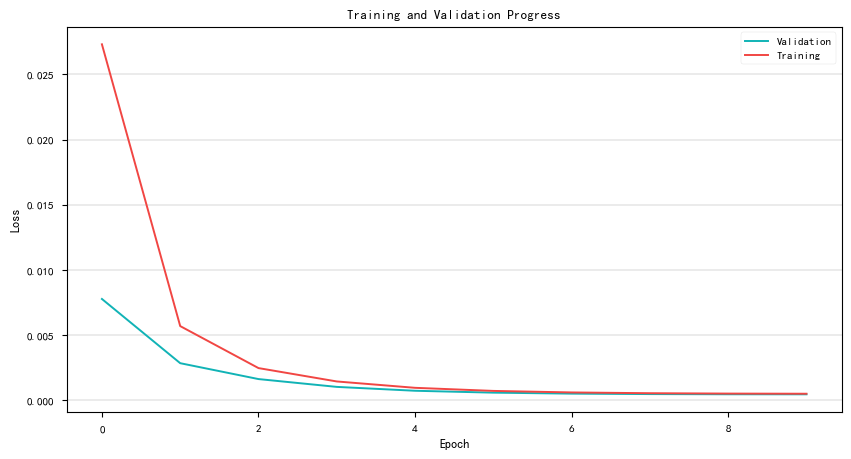

 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.03s/it]

Epoch [1/10], Training Loss: 0.0073, Validation Loss: 0.0027
Validation loss decreased (inf --> 0.002660).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:04<00:15,  2.00s/it]

Epoch [2/10], Training Loss: 0.0021, Validation Loss: 0.0013
Validation loss decreased (0.002660 --> 0.001340).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.97s/it]

Epoch [3/10], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.001340 --> 0.000811).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.98s/it]

Epoch [4/10], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000811 --> 0.000606).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.93s/it]

Epoch [5/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000606 --> 0.000495).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  1.95s/it]

Epoch [6/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000495 --> 0.000446).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:05,  1.93s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000446 --> 0.000425).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:15<00:03,  1.93s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000425 --> 0.000413).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:17<00:01,  1.94s/it]

Epoch [9/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000413 --> 0.000409).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]

Epoch [10/10], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


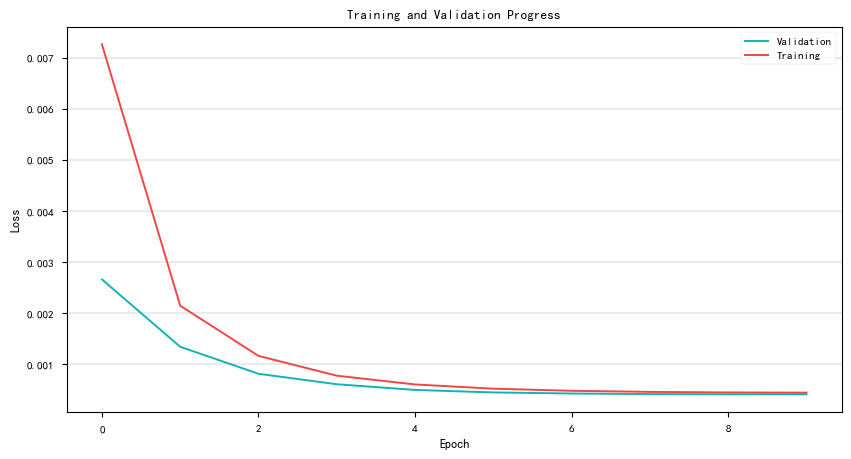

 14%|████████████                                                                        | 1/7 [00:01<00:11,  1.95s/it]

Epoch [1/7], Training Loss: 0.0094, Validation Loss: 0.0034
Validation loss decreased (inf --> 0.003411).  Saving model ...
Updating learning rate to 0.0009504844339512095


 29%|████████████████████████                                                            | 2/7 [00:03<00:09,  1.92s/it]

Epoch [2/7], Training Loss: 0.0027, Validation Loss: 0.0016
Validation loss decreased (0.003411 --> 0.001629).  Saving model ...
Updating learning rate to 0.0008117449009293668


 43%|████████████████████████████████████                                                | 3/7 [00:05<00:07,  1.91s/it]

Epoch [3/7], Training Loss: 0.0014, Validation Loss: 0.0010
Validation loss decreased (0.001629 --> 0.000975).  Saving model ...
Updating learning rate to 0.0006112604669781572


 57%|████████████████████████████████████████████████                                    | 4/7 [00:07<00:05,  1.90s/it]

Epoch [4/7], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.000975 --> 0.000712).  Saving model ...
Updating learning rate to 0.00038873953302184284


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:09<00:03,  1.88s/it]

Epoch [5/7], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000712 --> 0.000618).  Saving model ...
Updating learning rate to 0.00018825509907063325


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:11<00:01,  1.88s/it]

Epoch [6/7], Training Loss: 0.0006, Validation Loss: 0.0006
Validation loss decreased (0.000618 --> 0.000570).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.89s/it]

Epoch [7/7], Training Loss: 0.0006, Validation Loss: 0.0006
Validation loss decreased (0.000570 --> 0.000553).  Saving model ...
Updating learning rate to 0.0


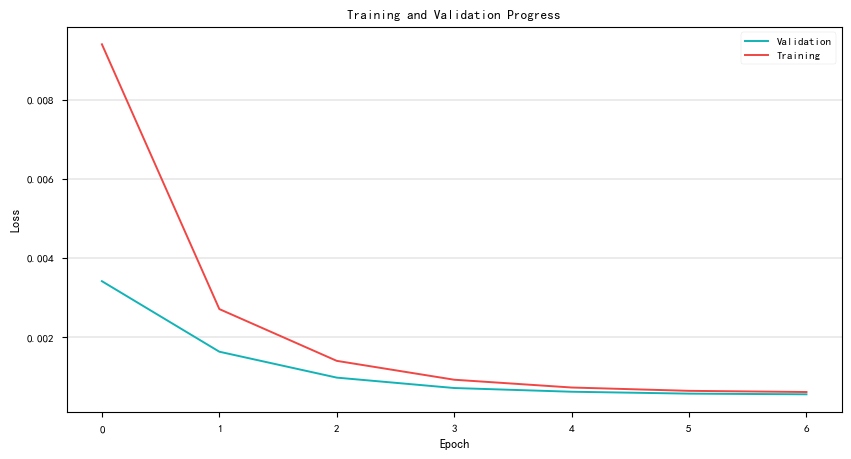

  8%|██████▍                                                                            | 1/13 [00:01<00:17,  1.47s/it]

Epoch [1/13], Training Loss: 0.0076, Validation Loss: 0.0048
Validation loss decreased (inf --> 0.004756).  Saving model ...
Updating learning rate to 0.000985470908713026


 15%|████████████▊                                                                      | 2/13 [00:02<00:15,  1.41s/it]

Epoch [2/13], Training Loss: 0.0048, Validation Loss: 0.0032
Validation loss decreased (0.004756 --> 0.003195).  Saving model ...
Updating learning rate to 0.0009427280128266049


 23%|███████████████████▏                                                               | 3/13 [00:04<00:14,  1.40s/it]

Epoch [3/13], Training Loss: 0.0033, Validation Loss: 0.0024
Validation loss decreased (0.003195 --> 0.002352).  Saving model ...
Updating learning rate to 0.0008742553740855505


 31%|█████████████████████████▌                                                         | 4/13 [00:05<00:12,  1.39s/it]

Epoch [4/13], Training Loss: 0.0025, Validation Loss: 0.0019
Validation loss decreased (0.002352 --> 0.001926).  Saving model ...
Updating learning rate to 0.0007840323733655779


 38%|███████████████████████████████▉                                                   | 5/13 [00:06<00:11,  1.38s/it]

Epoch [5/13], Training Loss: 0.0021, Validation Loss: 0.0017
Validation loss decreased (0.001926 --> 0.001703).  Saving model ...
Updating learning rate to 0.0006773024435212678


 46%|██████████████████████████████████████▎                                            | 6/13 [00:08<00:09,  1.38s/it]

Epoch [6/13], Training Loss: 0.0019, Validation Loss: 0.0016
Validation loss decreased (0.001703 --> 0.001620).  Saving model ...
Updating learning rate to 0.0005602683401276614


 54%|████████████████████████████████████████████▋                                      | 7/13 [00:09<00:08,  1.38s/it]

Epoch [7/13], Training Loss: 0.0017, Validation Loss: 0.0015
Validation loss decreased (0.001620 --> 0.001511).  Saving model ...
Updating learning rate to 0.00043973165987233853


 62%|███████████████████████████████████████████████████                                | 8/13 [00:11<00:06,  1.38s/it]

Epoch [8/13], Training Loss: 0.0016, Validation Loss: 0.0015
Validation loss decreased (0.001511 --> 0.001505).  Saving model ...
Updating learning rate to 0.00032269755647873217


 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:12<00:05,  1.38s/it]

Epoch [9/13], Training Loss: 0.0016, Validation Loss: 0.0014
Validation loss decreased (0.001505 --> 0.001444).  Saving model ...
Updating learning rate to 0.00021596762663442215


 77%|███████████████████████████████████████████████████████████████                   | 10/13 [00:13<00:04,  1.38s/it]

Epoch [10/13], Training Loss: 0.0016, Validation Loss: 0.0014
Validation loss decreased (0.001444 --> 0.001423).  Saving model ...
Updating learning rate to 0.0001257446259144494


 85%|█████████████████████████████████████████████████████████████████████▍            | 11/13 [00:15<00:02,  1.37s/it]

Epoch [11/13], Training Loss: 0.0015, Validation Loss: 0.0014
Validation loss decreased (0.001423 --> 0.001401).  Saving model ...
Updating learning rate to 5.72719871733951e-05


 92%|███████████████████████████████████████████████████████████████████████████▋      | 12/13 [00:16<00:01,  1.37s/it]

Epoch [12/13], Training Loss: 0.0015, Validation Loss: 0.0014
EarlyStopping counter: 1 out of 5
Updating learning rate to 1.4529091286973995e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:18<00:00,  1.38s/it]

Epoch [13/13], Training Loss: 0.0015, Validation Loss: 0.0014
Validation loss decreased (0.001401 --> 0.001398).  Saving model ...
Updating learning rate to 0.0


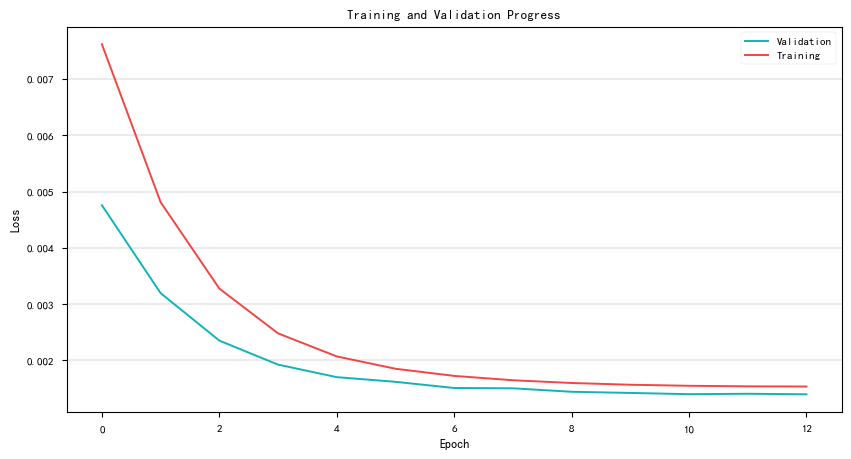

  6%|█████▏                                                                             | 1/16 [00:02<00:31,  2.10s/it]

Epoch [1/16], Training Loss: 0.0273, Validation Loss: 0.0092
Validation loss decreased (inf --> 0.009185).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:04<00:28,  2.06s/it]

Epoch [2/16], Training Loss: 0.0072, Validation Loss: 0.0035
Validation loss decreased (0.009185 --> 0.003522).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:06<00:26,  2.06s/it]

Epoch [3/16], Training Loss: 0.0030, Validation Loss: 0.0017
Validation loss decreased (0.003522 --> 0.001727).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:08<00:23,  2.00s/it]

Epoch [4/16], Training Loss: 0.0016, Validation Loss: 0.0010
Validation loss decreased (0.001727 --> 0.001018).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:10<00:21,  1.99s/it]

Epoch [5/16], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001018 --> 0.000692).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:12<00:19,  1.98s/it]

Epoch [6/16], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000692 --> 0.000526).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:14<00:18,  2.01s/it]

Epoch [7/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000526 --> 0.000450).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:16<00:16,  2.00s/it]

Epoch [8/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000450 --> 0.000416).  Saving model ...
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:18<00:13,  1.99s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000416 --> 0.000410).  Saving model ...
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:20<00:12,  2.00s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000410 --> 0.000385).  Saving model ...
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:22<00:09,  1.99s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000385 --> 0.000378).  Saving model ...
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:24<00:08,  2.00s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000378 --> 0.000378).  Saving model ...
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:26<00:06,  2.00s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000378 --> 0.000375).  Saving model ...
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:28<00:03,  2.00s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:30<00:01,  1.99s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:32<00:00,  2.00s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0


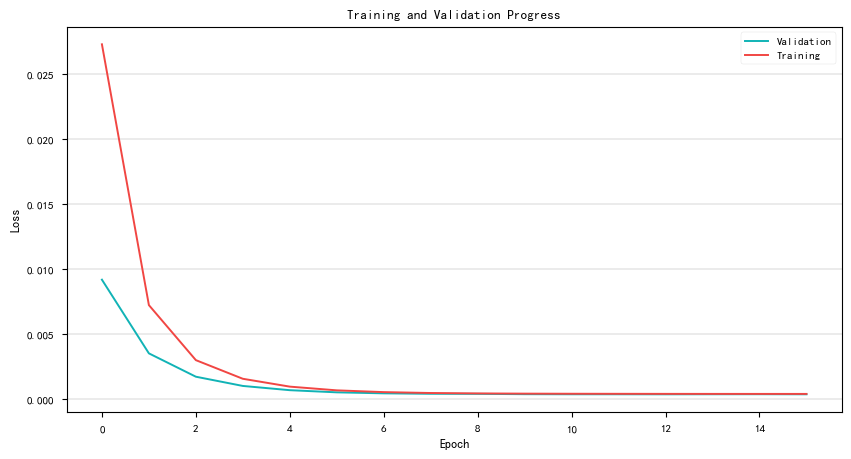

 10%|████████▎                                                                          | 1/10 [00:02<00:18,  2.00s/it]

Epoch [1/10], Training Loss: 0.0072, Validation Loss: 0.0029
Validation loss decreased (inf --> 0.002903).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:03<00:15,  1.97s/it]

Epoch [2/10], Training Loss: 0.0022, Validation Loss: 0.0013
Validation loss decreased (0.002903 --> 0.001326).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:05<00:13,  1.96s/it]

Epoch [3/10], Training Loss: 0.0011, Validation Loss: 0.0008
Validation loss decreased (0.001326 --> 0.000801).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:07<00:11,  1.93s/it]

Epoch [4/10], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000801 --> 0.000575).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:09<00:09,  1.93s/it]

Epoch [5/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000575 --> 0.000478).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:11<00:07,  1.96s/it]

Epoch [6/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000478 --> 0.000433).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:13<00:05,  1.96s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000433 --> 0.000412).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:15<00:03,  1.95s/it]

Epoch [8/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000412 --> 0.000399).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:17<00:01,  1.96s/it]

Epoch [9/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000399 --> 0.000394).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]

Epoch [10/10], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


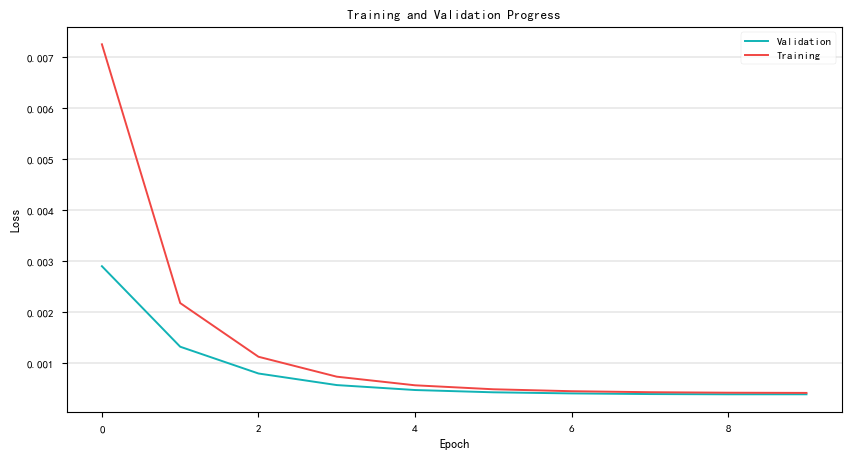

  7%|█████▌                                                                             | 1/15 [00:02<00:28,  2.01s/it]

Epoch [1/15], Training Loss: 0.0084, Validation Loss: 0.0030
Validation loss decreased (inf --> 0.002966).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:04<00:26,  2.02s/it]

Epoch [2/15], Training Loss: 0.0023, Validation Loss: 0.0014
Validation loss decreased (0.002966 --> 0.001361).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:06<00:24,  2.03s/it]

Epoch [3/15], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.001361 --> 0.000828).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:08<00:22,  2.02s/it]

Epoch [4/15], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000828 --> 0.000564).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:10<00:20,  2.02s/it]

Epoch [5/15], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000564 --> 0.000459).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:12<00:18,  2.03s/it]

Epoch [6/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000459 --> 0.000419).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:14<00:16,  2.02s/it]

Epoch [7/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000419 --> 0.000395).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:16<00:14,  2.02s/it]

Epoch [8/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000395 --> 0.000384).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:18<00:12,  2.02s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000384 --> 0.000375).  Saving model ...
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:20<00:10,  2.02s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000375 --> 0.000373).  Saving model ...
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:22<00:08,  2.02s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000373 --> 0.000372).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:24<00:06,  2.02s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000372 --> 0.000372).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:26<00:04,  2.03s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000372 --> 0.000371).  Saving model ...
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:28<00:02,  2.02s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000371 --> 0.000371).  Saving model ...
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.02s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


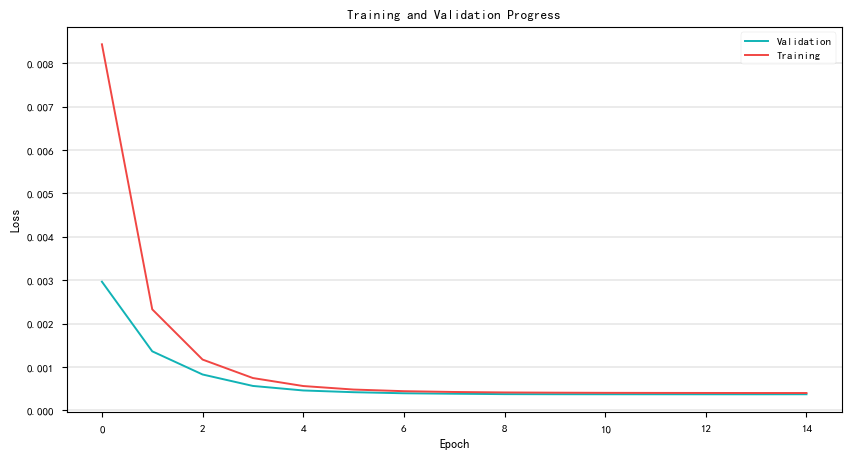

  6%|████▌                                                                              | 1/18 [00:02<00:34,  2.05s/it]

Epoch [1/18], Training Loss: 0.0083, Validation Loss: 0.0029
Validation loss decreased (inf --> 0.002854).  Saving model ...
Updating learning rate to 0.000992403876506104


 11%|█████████▏                                                                         | 2/18 [00:04<00:32,  2.02s/it]

Epoch [2/18], Training Loss: 0.0023, Validation Loss: 0.0013
Validation loss decreased (0.002854 --> 0.001316).  Saving model ...
Updating learning rate to 0.0009698463103929542


 17%|█████████████▊                                                                     | 3/18 [00:06<00:29,  1.99s/it]

Epoch [3/18], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.001316 --> 0.000824).  Saving model ...
Updating learning rate to 0.0009330127018922195


 22%|██████████████████▍                                                                | 4/18 [00:07<00:27,  1.98s/it]

Epoch [4/18], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000824 --> 0.000577).  Saving model ...
Updating learning rate to 0.000883022221559489


 28%|███████████████████████                                                            | 5/18 [00:10<00:26,  2.04s/it]

Epoch [5/18], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000577 --> 0.000481).  Saving model ...
Updating learning rate to 0.0008213938048432696


 33%|███████████████████████████▋                                                       | 6/18 [00:12<00:25,  2.15s/it]

Epoch [6/18], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000481 --> 0.000425).  Saving model ...
Updating learning rate to 0.00075


 39%|████████████████████████████████▎                                                  | 7/18 [00:14<00:24,  2.19s/it]

Epoch [7/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000425 --> 0.000406).  Saving model ...
Updating learning rate to 0.0006710100716628344


 44%|████████████████████████████████████▉                                              | 8/18 [00:16<00:21,  2.19s/it]

Epoch [8/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000406 --> 0.000388).  Saving model ...
Updating learning rate to 0.0005868240888334653


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:19<00:19,  2.22s/it]

Epoch [9/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000388 --> 0.000384).  Saving model ...
Updating learning rate to 0.0005


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:21<00:18,  2.26s/it]

Epoch [10/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00041317591116653486


 61%|██████████████████████████████████████████████████                                | 11/18 [00:23<00:15,  2.23s/it]

Epoch [11/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000384 --> 0.000378).  Saving model ...
Updating learning rate to 0.0003289899283371657


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:26<00:13,  2.26s/it]

Epoch [12/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002500000000000001


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:28<00:11,  2.24s/it]

Epoch [13/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0001786061951567303


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:30<00:08,  2.24s/it]

Epoch [14/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.00011697777844051105


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:32<00:06,  2.21s/it]

Epoch [15/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 4 out of 5
Updating learning rate to 6.698729810778065e-05


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:34<00:06,  2.33s/it]

Epoch [16/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 5 out of 5
Early stopping!


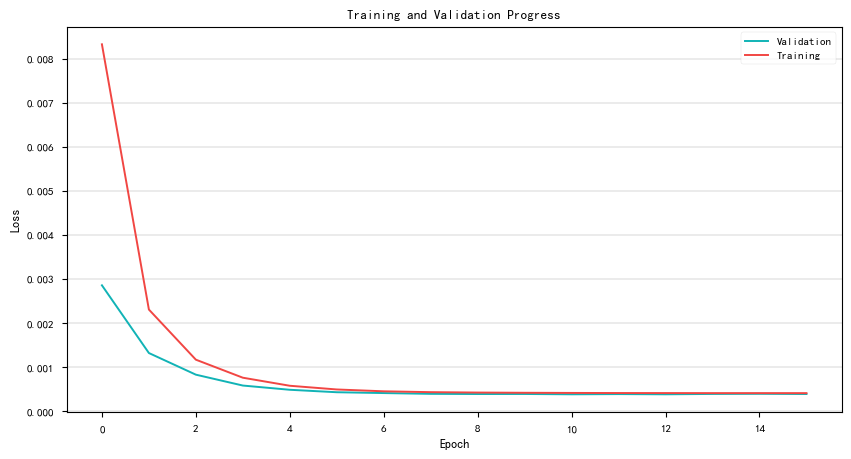

 20%|████████████████▊                                                                   | 1/5 [00:04<00:19,  4.78s/it]

Epoch [1/5], Training Loss: 0.0064, Validation Loss: 0.0018
Validation loss decreased (inf --> 0.001779).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:13,  4.49s/it]

Epoch [2/5], Training Loss: 0.0014, Validation Loss: 0.0008
Validation loss decreased (0.001779 --> 0.000766).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:12<00:08,  4.23s/it]

Epoch [3/5], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000766 --> 0.000492).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:17<00:04,  4.27s/it]

Epoch [4/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000492 --> 0.000436).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.32s/it]

Epoch [5/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000436 --> 0.000423).  Saving model ...
Updating learning rate to 0.0


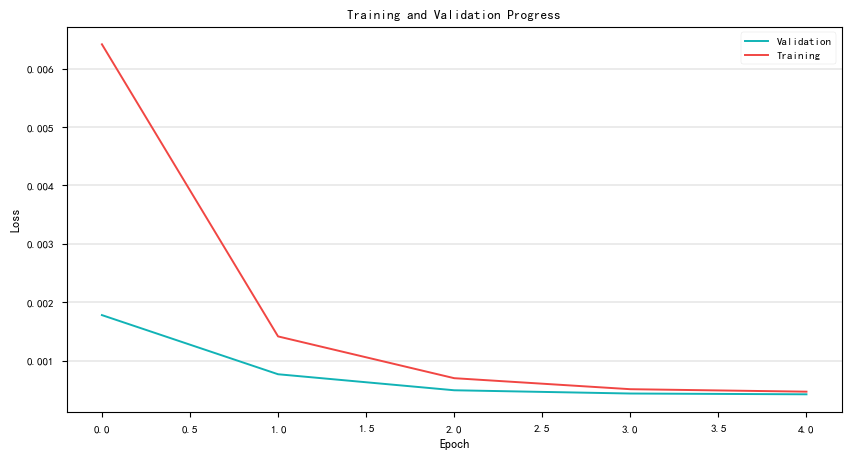

  6%|█████▏                                                                             | 1/16 [00:02<00:34,  2.30s/it]

Epoch [1/16], Training Loss: 0.0070, Validation Loss: 0.0025
Validation loss decreased (inf --> 0.002546).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:04<00:32,  2.29s/it]

Epoch [2/16], Training Loss: 0.0020, Validation Loss: 0.0012
Validation loss decreased (0.002546 --> 0.001187).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:06<00:29,  2.27s/it]

Epoch [3/16], Training Loss: 0.0011, Validation Loss: 0.0008
Validation loss decreased (0.001187 --> 0.000772).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:08<00:26,  2.22s/it]

Epoch [4/16], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000772 --> 0.000577).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:11<00:24,  2.25s/it]

Epoch [5/16], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000577 --> 0.000455).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:14<00:25,  2.52s/it]

Epoch [6/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000455 --> 0.000413).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:18<00:26,  2.95s/it]

Epoch [7/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000413 --> 0.000398).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:22<00:25,  3.24s/it]

Epoch [8/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000398 --> 0.000385).  Saving model ...
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:24<00:20,  2.95s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000385 --> 0.000383).  Saving model ...
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:27<00:17,  2.87s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000383 --> 0.000374).  Saving model ...
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:29<00:13,  2.80s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000372).  Saving model ...
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:31<00:10,  2.64s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000372 --> 0.000370).  Saving model ...
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:34<00:07,  2.53s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:36<00:04,  2.44s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:38<00:02,  2.37s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:41<00:00,  2.58s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000370 --> 0.000370).  Saving model ...
Updating learning rate to 0.0


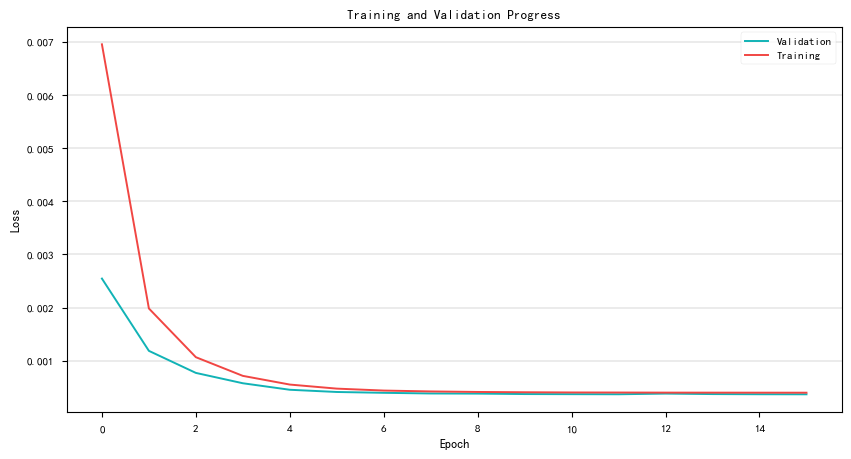

 10%|████████▎                                                                          | 1/10 [00:02<00:21,  2.34s/it]

Epoch [1/10], Training Loss: 0.0145, Validation Loss: 0.0044
Validation loss decreased (inf --> 0.004414).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:04<00:18,  2.27s/it]

Epoch [2/10], Training Loss: 0.0035, Validation Loss: 0.0021
Validation loss decreased (0.004414 --> 0.002062).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:16,  2.31s/it]

Epoch [3/10], Training Loss: 0.0017, Validation Loss: 0.0012
Validation loss decreased (0.002062 --> 0.001160).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:14,  2.43s/it]

Epoch [4/10], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.001160 --> 0.000757).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:11<00:11,  2.35s/it]

Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000757 --> 0.000592).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:14<00:09,  2.35s/it]

Epoch [6/10], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000592 --> 0.000497).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:16<00:07,  2.39s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000497 --> 0.000454).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:18<00:04,  2.28s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000454 --> 0.000436).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:20<00:02,  2.19s/it]

Epoch [9/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000436 --> 0.000428).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]

Epoch [10/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000428 --> 0.000425).  Saving model ...
Updating learning rate to 0.0


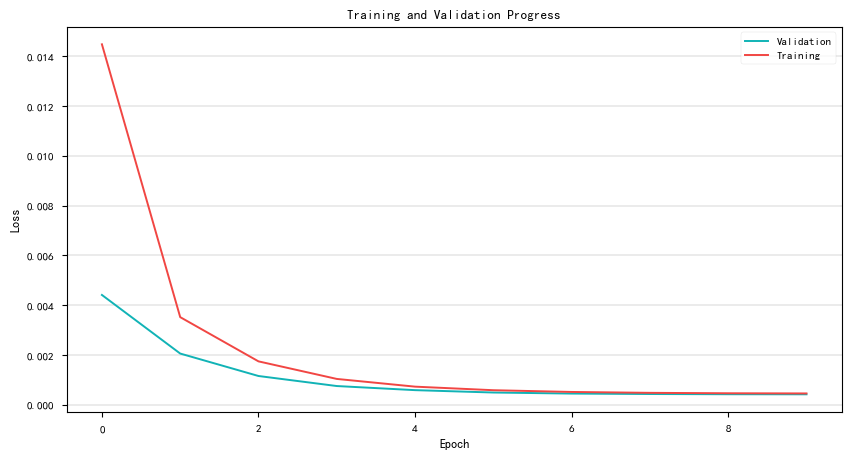

  7%|█████▌                                                                             | 1/15 [00:02<00:29,  2.14s/it]

Epoch [1/15], Training Loss: 0.0064, Validation Loss: 0.0023
Validation loss decreased (inf --> 0.002298).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:04<00:27,  2.10s/it]

Epoch [2/15], Training Loss: 0.0018, Validation Loss: 0.0012
Validation loss decreased (0.002298 --> 0.001152).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:06<00:25,  2.09s/it]

Epoch [3/15], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001152 --> 0.000725).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:08<00:22,  2.08s/it]

Epoch [4/15], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000725 --> 0.000518).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:10<00:20,  2.09s/it]

Epoch [5/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000518 --> 0.000440).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:12<00:18,  2.08s/it]

Epoch [6/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000440 --> 0.000403).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:14<00:16,  2.08s/it]

Epoch [7/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000403 --> 0.000389).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:16<00:14,  2.08s/it]

Epoch [8/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:18<00:12,  2.07s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000389 --> 0.000374).  Saving model ...
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:20<00:10,  2.06s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:22<00:08,  2.10s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000374).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:25<00:06,  2.15s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000371).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:27<00:04,  2.19s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:29<00:02,  2.21s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.13s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0


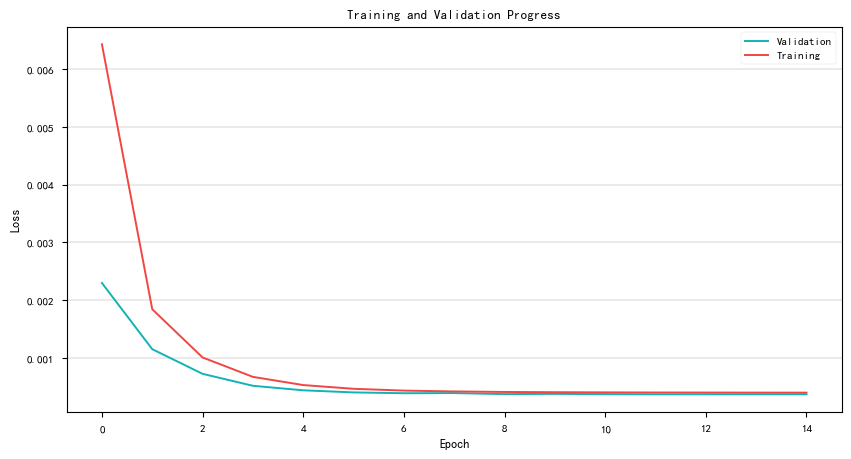

  6%|████▌                                                                              | 1/18 [00:02<00:36,  2.16s/it]

Epoch [1/18], Training Loss: 0.0065, Validation Loss: 0.0024
Validation loss decreased (inf --> 0.002380).  Saving model ...
Updating learning rate to 0.000992403876506104


 11%|█████████▏                                                                         | 2/18 [00:04<00:34,  2.19s/it]

Epoch [2/18], Training Loss: 0.0019, Validation Loss: 0.0011
Validation loss decreased (0.002380 --> 0.001131).  Saving model ...
Updating learning rate to 0.0009698463103929542


 17%|█████████████▊                                                                     | 3/18 [00:06<00:33,  2.23s/it]

Epoch [3/18], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001131 --> 0.000732).  Saving model ...
Updating learning rate to 0.0009330127018922195


 22%|██████████████████▍                                                                | 4/18 [00:08<00:31,  2.25s/it]

Epoch [4/18], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000732 --> 0.000544).  Saving model ...
Updating learning rate to 0.000883022221559489


 28%|███████████████████████                                                            | 5/18 [00:11<00:30,  2.31s/it]

Epoch [5/18], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000544 --> 0.000457).  Saving model ...
Updating learning rate to 0.0008213938048432696


 33%|███████████████████████████▋                                                       | 6/18 [00:13<00:27,  2.32s/it]

Epoch [6/18], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000457 --> 0.000418).  Saving model ...
Updating learning rate to 0.00075


 39%|████████████████████████████████▎                                                  | 7/18 [00:16<00:25,  2.34s/it]

Epoch [7/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000418 --> 0.000395).  Saving model ...
Updating learning rate to 0.0006710100716628344


 44%|████████████████████████████████████▉                                              | 8/18 [00:18<00:23,  2.31s/it]

Epoch [8/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0005868240888334653


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:20<00:20,  2.26s/it]

Epoch [9/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000395 --> 0.000383).  Saving model ...
Updating learning rate to 0.0005


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:22<00:17,  2.20s/it]

Epoch [10/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00041317591116653486


 61%|██████████████████████████████████████████████████                                | 11/18 [00:24<00:15,  2.15s/it]

Epoch [11/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0003289899283371657


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:26<00:12,  2.13s/it]

Epoch [12/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0002500000000000001


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:28<00:10,  2.16s/it]

Epoch [13/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 4 out of 5
Updating learning rate to 0.0001786061951567303


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:31<00:08,  2.17s/it]

Epoch [14/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000383 --> 0.000382).  Saving model ...
Updating learning rate to 0.00011697777844051105


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:33<00:06,  2.18s/it]

Epoch [15/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000382 --> 0.000378).  Saving model ...
Updating learning rate to 6.698729810778065e-05


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:35<00:04,  2.17s/it]

Epoch [16/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 3.0153689607045842e-05


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:37<00:02,  2.14s/it]

Epoch [17/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000378 --> 0.000378).  Saving model ...
Updating learning rate to 7.59612349389599e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:39<00:00,  2.20s/it]

Epoch [18/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


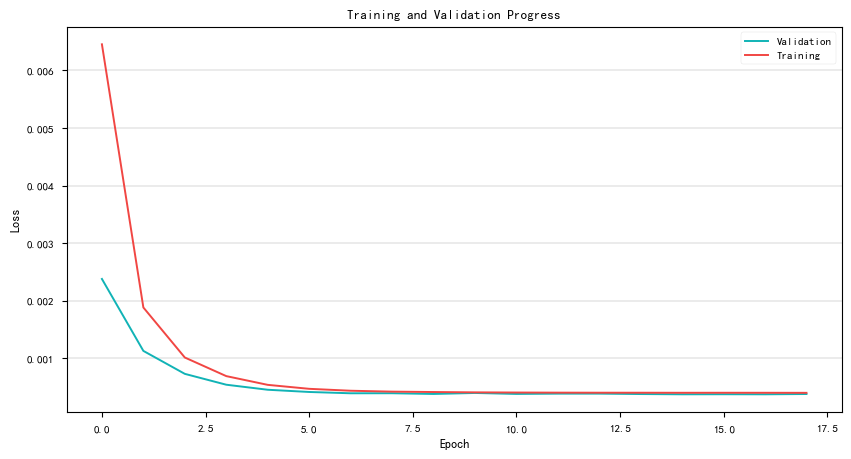

 20%|████████████████▊                                                                   | 1/5 [00:04<00:16,  4.09s/it]

Epoch [1/5], Training Loss: 0.0283, Validation Loss: 0.0038
Validation loss decreased (inf --> 0.003817).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:08<00:12,  4.03s/it]

Epoch [2/5], Training Loss: 0.0024, Validation Loss: 0.0010
Validation loss decreased (0.003817 --> 0.000998).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:12<00:08,  4.02s/it]

Epoch [3/5], Training Loss: 0.0009, Validation Loss: 0.0006
Validation loss decreased (0.000998 --> 0.000586).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:16<00:04,  4.02s/it]

Epoch [4/5], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000586 --> 0.000480).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.12s/it]

Epoch [5/5], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000480 --> 0.000458).  Saving model ...
Updating learning rate to 0.0


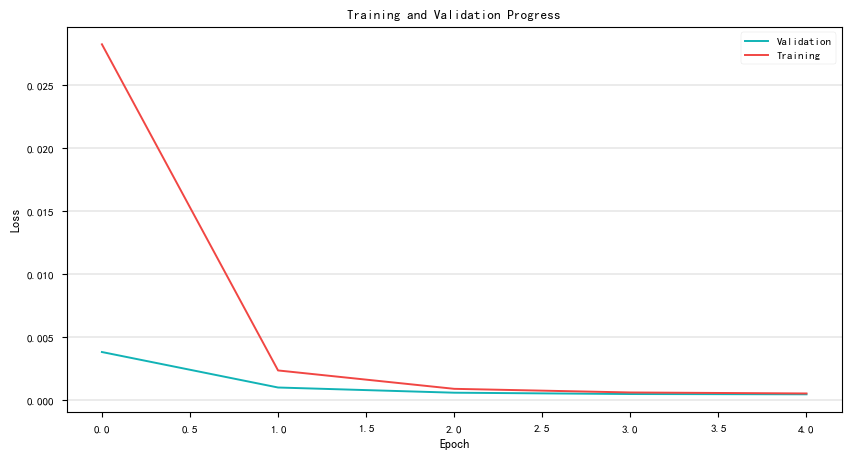

第1次迭代


  6%|█████▏                                                                             | 1/16 [00:02<00:32,  2.17s/it]

Epoch [1/16], Training Loss: 0.0067, Validation Loss: 0.0025
Validation loss decreased (inf --> 0.002456).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:04<00:30,  2.21s/it]

Epoch [2/16], Training Loss: 0.0019, Validation Loss: 0.0012
Validation loss decreased (0.002456 --> 0.001172).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:06<00:28,  2.21s/it]

Epoch [3/16], Training Loss: 0.0011, Validation Loss: 0.0008
Validation loss decreased (0.001172 --> 0.000761).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:08<00:26,  2.24s/it]

Epoch [4/16], Training Loss: 0.0007, Validation Loss: 0.0006
Validation loss decreased (0.000761 --> 0.000577).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:11<00:24,  2.26s/it]

Epoch [5/16], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000577 --> 0.000479).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:13<00:23,  2.34s/it]

Epoch [6/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000479 --> 0.000415).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:15<00:20,  2.30s/it]

Epoch [7/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000415 --> 0.000400).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:18<00:18,  2.26s/it]

Epoch [8/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000400 --> 0.000392).  Saving model ...
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:20<00:16,  2.32s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000392 --> 0.000378).  Saving model ...
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:22<00:13,  2.29s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:25<00:11,  2.33s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000378 --> 0.000372).  Saving model ...
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:27<00:09,  2.38s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:29<00:07,  2.34s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:32<00:04,  2.33s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000372 --> 0.000370).  Saving model ...
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:34<00:02,  2.36s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:37<00:00,  2.33s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0


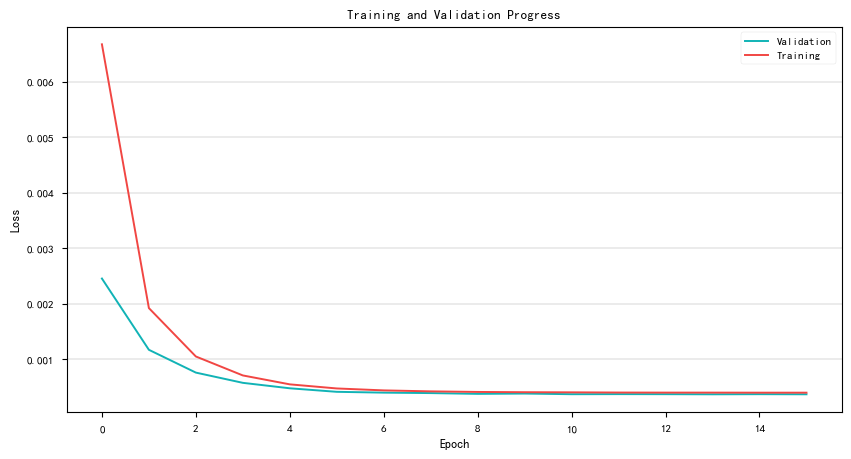

  7%|█████▌                                                                             | 1/15 [00:02<00:34,  2.44s/it]

Epoch [1/15], Training Loss: 0.0272, Validation Loss: 0.0088
Validation loss decreased (inf --> 0.008835).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:05<00:33,  2.55s/it]

Epoch [2/15], Training Loss: 0.0070, Validation Loss: 0.0034
Validation loss decreased (0.008835 --> 0.003383).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:07<00:28,  2.41s/it]

Epoch [3/15], Training Loss: 0.0029, Validation Loss: 0.0017
Validation loss decreased (0.003383 --> 0.001663).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:09<00:25,  2.30s/it]

Epoch [4/15], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001663 --> 0.000969).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:11<00:22,  2.22s/it]

Epoch [5/15], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.000969 --> 0.000655).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:13<00:19,  2.20s/it]

Epoch [6/15], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000655 --> 0.000512).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:15<00:17,  2.18s/it]

Epoch [7/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000512 --> 0.000439).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:17<00:15,  2.16s/it]

Epoch [8/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000439 --> 0.000406).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:20<00:12,  2.15s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000406 --> 0.000395).  Saving model ...
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:22<00:10,  2.14s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:24<00:08,  2.14s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000395 --> 0.000381).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:26<00:06,  2.16s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000381 --> 0.000381).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:28<00:04,  2.18s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:30<00:02,  2.18s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000381 --> 0.000376).  Saving model ...
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:33<00:00,  2.22s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000376 --> 0.000375).  Saving model ...
Updating learning rate to 0.0


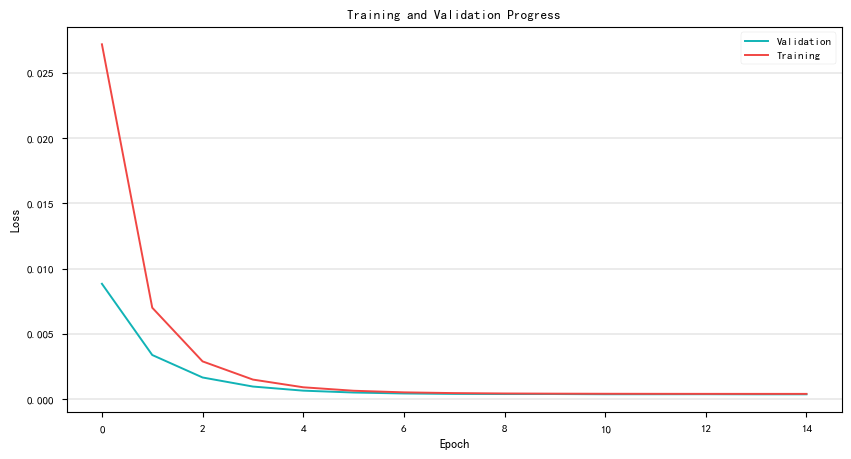

  6%|████▌                                                                              | 1/18 [00:02<00:39,  2.35s/it]

Epoch [1/18], Training Loss: 0.0240, Validation Loss: 0.0072
Validation loss decreased (inf --> 0.007170).  Saving model ...
Updating learning rate to 0.000992403876506104


 11%|█████████▏                                                                         | 2/18 [00:04<00:35,  2.22s/it]

Epoch [2/18], Training Loss: 0.0054, Validation Loss: 0.0024
Validation loss decreased (0.007170 --> 0.002390).  Saving model ...
Updating learning rate to 0.0009698463103929542


 17%|█████████████▊                                                                     | 3/18 [00:06<00:33,  2.22s/it]

Epoch [3/18], Training Loss: 0.0022, Validation Loss: 0.0014
Validation loss decreased (0.002390 --> 0.001373).  Saving model ...
Updating learning rate to 0.0009330127018922195


 22%|██████████████████▍                                                                | 4/18 [00:08<00:31,  2.25s/it]

Epoch [4/18], Training Loss: 0.0013, Validation Loss: 0.0009
Validation loss decreased (0.001373 --> 0.000883).  Saving model ...
Updating learning rate to 0.000883022221559489


 28%|███████████████████████                                                            | 5/18 [00:11<00:29,  2.28s/it]

Epoch [5/18], Training Loss: 0.0009, Validation Loss: 0.0006
Validation loss decreased (0.000883 --> 0.000627).  Saving model ...
Updating learning rate to 0.0008213938048432696


 33%|███████████████████████████▋                                                       | 6/18 [00:13<00:26,  2.23s/it]

Epoch [6/18], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000627 --> 0.000509).  Saving model ...
Updating learning rate to 0.00075


 39%|████████████████████████████████▎                                                  | 7/18 [00:15<00:24,  2.19s/it]

Epoch [7/18], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000509 --> 0.000439).  Saving model ...
Updating learning rate to 0.0006710100716628344


 44%|████████████████████████████████████▉                                              | 8/18 [00:17<00:22,  2.25s/it]

Epoch [8/18], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000439 --> 0.000407).  Saving model ...
Updating learning rate to 0.0005868240888334653


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:20<00:19,  2.21s/it]

Epoch [9/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000407 --> 0.000402).  Saving model ...
Updating learning rate to 0.0005


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:22<00:17,  2.18s/it]

Epoch [10/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000402 --> 0.000386).  Saving model ...
Updating learning rate to 0.00041317591116653486


 61%|██████████████████████████████████████████████████                                | 11/18 [00:24<00:15,  2.18s/it]

Epoch [11/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000386 --> 0.000384).  Saving model ...
Updating learning rate to 0.0003289899283371657


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:26<00:13,  2.17s/it]

Epoch [12/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002500000000000001


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:28<00:10,  2.17s/it]

Epoch [13/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000384 --> 0.000382).  Saving model ...
Updating learning rate to 0.0001786061951567303


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:30<00:08,  2.21s/it]

Epoch [14/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00011697777844051105


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:33<00:06,  2.19s/it]

Epoch [15/18], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000382 --> 0.000378).  Saving model ...
Updating learning rate to 6.698729810778065e-05


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:35<00:04,  2.15s/it]

Epoch [16/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 3.0153689607045842e-05


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:37<00:02,  2.20s/it]

Epoch [17/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 7.59612349389599e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:39<00:00,  2.21s/it]

Epoch [18/18], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 0.0


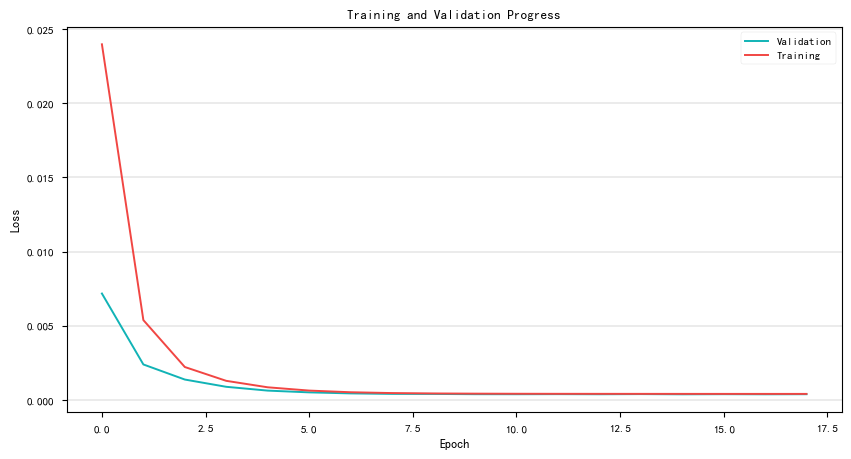

 10%|████████▎                                                                          | 1/10 [00:02<00:20,  2.24s/it]

Epoch [1/10], Training Loss: 0.0113, Validation Loss: 0.0040
Validation loss decreased (inf --> 0.004036).  Saving model ...
Updating learning rate to 0.0009755282581475768


 20%|████████████████▌                                                                  | 2/10 [00:04<00:17,  2.24s/it]

Epoch [2/10], Training Loss: 0.0031, Validation Loss: 0.0018
Validation loss decreased (0.004036 --> 0.001778).  Saving model ...
Updating learning rate to 0.0009045084971874737


 30%|████████████████████████▉                                                          | 3/10 [00:06<00:15,  2.22s/it]

Epoch [3/10], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001778 --> 0.001004).  Saving model ...
Updating learning rate to 0.0007938926261462366


 40%|█████████████████████████████████▏                                                 | 4/10 [00:09<00:13,  2.27s/it]

Epoch [4/10], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.001004 --> 0.000676).  Saving model ...
Updating learning rate to 0.0006545084971874737


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:11<00:11,  2.28s/it]

Epoch [5/10], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000676 --> 0.000535).  Saving model ...
Updating learning rate to 0.0005


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:13<00:08,  2.24s/it]

Epoch [6/10], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000535 --> 0.000469).  Saving model ...
Updating learning rate to 0.00034549150281252633


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:15<00:06,  2.19s/it]

Epoch [7/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000469 --> 0.000437).  Saving model ...
Updating learning rate to 0.00020610737385376348


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:17<00:04,  2.16s/it]

Epoch [8/10], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000437 --> 0.000419).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:19<00:02,  2.14s/it]

Epoch [9/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000419 --> 0.000412).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]

Epoch [10/10], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000412 --> 0.000410).  Saving model ...
Updating learning rate to 0.0


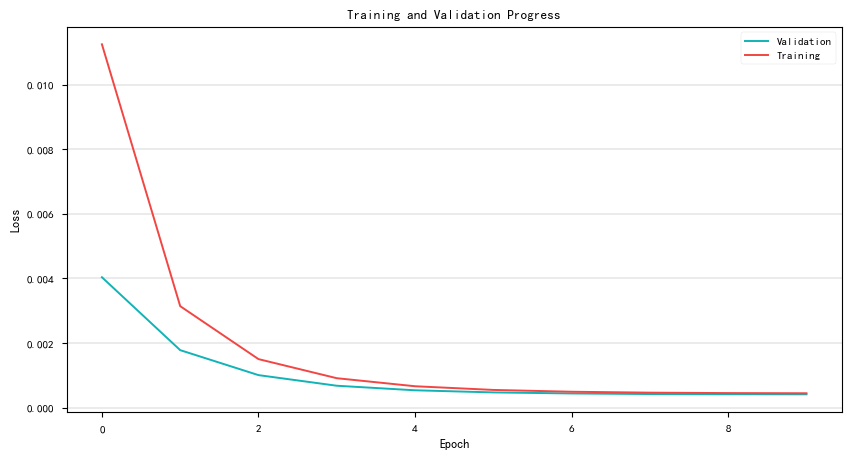

 20%|████████████████▊                                                                   | 1/5 [00:04<00:17,  4.49s/it]

Epoch [1/5], Training Loss: 0.0087, Validation Loss: 0.0019
Validation loss decreased (inf --> 0.001871).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:13,  4.54s/it]

Epoch [2/5], Training Loss: 0.0015, Validation Loss: 0.0008
Validation loss decreased (0.001871 --> 0.000797).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:13<00:08,  4.35s/it]

Epoch [3/5], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000797 --> 0.000509).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:17<00:04,  4.24s/it]

Epoch [4/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000509 --> 0.000442).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]

Epoch [5/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000442 --> 0.000430).  Saving model ...
Updating learning rate to 0.0


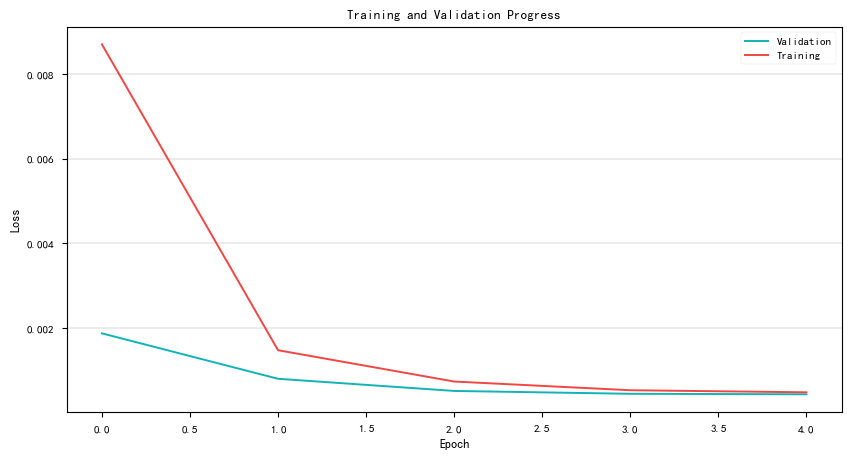

  6%|█████▏                                                                             | 1/16 [00:02<00:35,  2.33s/it]

Epoch [1/16], Training Loss: 0.0065, Validation Loss: 0.0024
Validation loss decreased (inf --> 0.002373).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:04<00:30,  2.19s/it]

Epoch [2/16], Training Loss: 0.0019, Validation Loss: 0.0012
Validation loss decreased (0.002373 --> 0.001178).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:06<00:28,  2.16s/it]

Epoch [3/16], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001178 --> 0.000746).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:08<00:25,  2.16s/it]

Epoch [4/16], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000746 --> 0.000545).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:10<00:23,  2.14s/it]

Epoch [5/16], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000545 --> 0.000473).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:12<00:21,  2.11s/it]

Epoch [6/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000473 --> 0.000428).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:14<00:18,  2.08s/it]

Epoch [7/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000428 --> 0.000389).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:16<00:16,  2.07s/it]

Epoch [8/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000389 --> 0.000381).  Saving model ...
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:19<00:14,  2.10s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:21<00:12,  2.09s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000381 --> 0.000379).  Saving model ...
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:23<00:10,  2.12s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:25<00:08,  2.15s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:27<00:06,  2.21s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000379 --> 0.000373).  Saving model ...
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:30<00:04,  2.22s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000373 --> 0.000369).  Saving model ...
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:32<00:02,  2.18s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:34<00:00,  2.15s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0


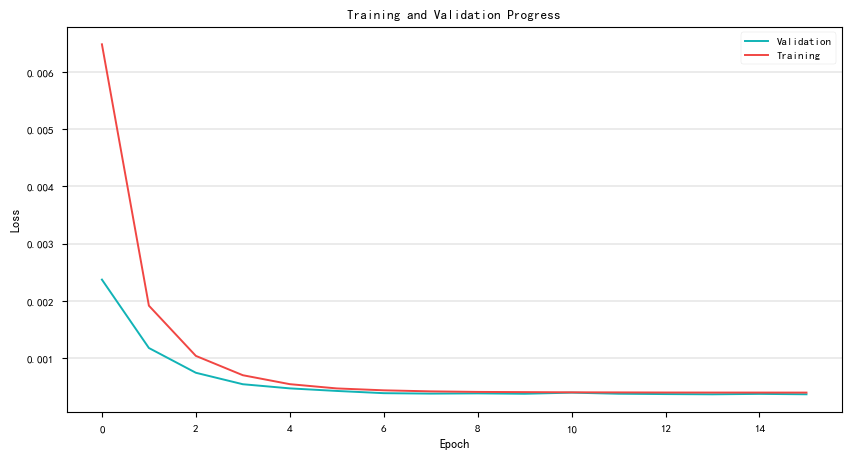

  7%|█████▌                                                                             | 1/15 [00:02<00:30,  2.17s/it]

Epoch [1/15], Training Loss: 0.0135, Validation Loss: 0.0040
Validation loss decreased (inf --> 0.003966).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:04<00:27,  2.11s/it]

Epoch [2/15], Training Loss: 0.0032, Validation Loss: 0.0018
Validation loss decreased (0.003966 --> 0.001813).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:06<00:25,  2.10s/it]

Epoch [3/15], Training Loss: 0.0016, Validation Loss: 0.0010
Validation loss decreased (0.001813 --> 0.001040).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:08<00:22,  2.08s/it]

Epoch [4/15], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.001040 --> 0.000674).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:10<00:20,  2.07s/it]

Epoch [5/15], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000674 --> 0.000507).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:12<00:18,  2.08s/it]

Epoch [6/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000507 --> 0.000440).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:14<00:16,  2.07s/it]

Epoch [7/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000440 --> 0.000401).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:16<00:14,  2.07s/it]

Epoch [8/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000401 --> 0.000392).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:18<00:12,  2.13s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000392 --> 0.000382).  Saving model ...
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:21<00:10,  2.16s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000382 --> 0.000375).  Saving model ...
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:23<00:08,  2.17s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000375 --> 0.000374).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:25<00:06,  2.21s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000374).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:27<00:04,  2.22s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000374).  Saving model ...
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:30<00:02,  2.24s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000373).  Saving model ...
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.16s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


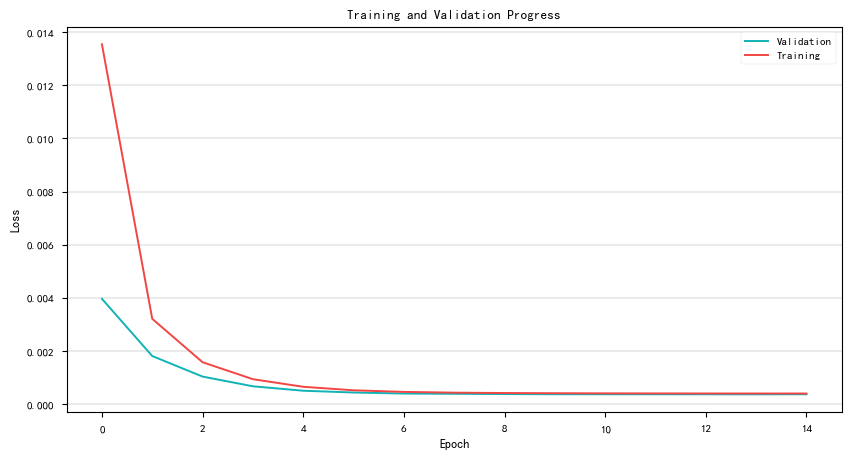

  7%|█████▌                                                                             | 1/15 [00:02<00:31,  2.24s/it]

Epoch [1/15], Training Loss: 0.0117, Validation Loss: 0.0041
Validation loss decreased (inf --> 0.004146).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:04<00:28,  2.23s/it]

Epoch [2/15], Training Loss: 0.0033, Validation Loss: 0.0019
Validation loss decreased (0.004146 --> 0.001854).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:06<00:26,  2.22s/it]

Epoch [3/15], Training Loss: 0.0016, Validation Loss: 0.0010
Validation loss decreased (0.001854 --> 0.001016).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:09<00:25,  2.29s/it]

Epoch [4/15], Training Loss: 0.0009, Validation Loss: 0.0007
Validation loss decreased (0.001016 --> 0.000688).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:11<00:22,  2.24s/it]

Epoch [5/15], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000688 --> 0.000525).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:13<00:20,  2.25s/it]

Epoch [6/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000525 --> 0.000446).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:15<00:17,  2.24s/it]

Epoch [7/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000446 --> 0.000415).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:18<00:16,  2.34s/it]

Epoch [8/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000415 --> 0.000412).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:20<00:14,  2.37s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000412 --> 0.000384).  Saving model ...
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:22<00:11,  2.31s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:25<00:09,  2.26s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000384 --> 0.000376).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:27<00:06,  2.22s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:29<00:04,  2.28s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:31<00:02,  2.25s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000376 --> 0.000374).  Saving model ...
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:33<00:00,  2.25s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


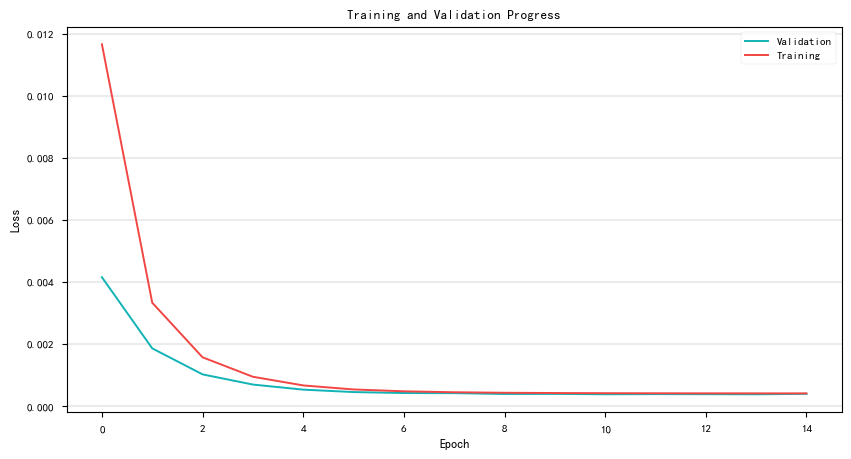

  7%|█████▉                                                                             | 1/14 [00:02<00:32,  2.46s/it]

Epoch [1/14], Training Loss: 0.0089, Validation Loss: 0.0031
Validation loss decreased (inf --> 0.003132).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:04<00:30,  2.50s/it]

Epoch [2/14], Training Loss: 0.0025, Validation Loss: 0.0014
Validation loss decreased (0.003132 --> 0.001409).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:07<00:27,  2.53s/it]

Epoch [3/14], Training Loss: 0.0012, Validation Loss: 0.0008
Validation loss decreased (0.001409 --> 0.000841).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:10<00:25,  2.59s/it]

Epoch [4/14], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000841 --> 0.000578).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:12<00:22,  2.54s/it]

Epoch [5/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000578 --> 0.000471).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:15<00:19,  2.47s/it]

Epoch [6/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000471 --> 0.000436).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:17<00:16,  2.39s/it]

Epoch [7/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000436 --> 0.000397).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:19<00:14,  2.36s/it]

Epoch [8/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000397 --> 0.000388).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:21<00:11,  2.37s/it]

Epoch [9/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000388 --> 0.000379).  Saving model ...
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:24<00:09,  2.33s/it]

Epoch [10/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000379 --> 0.000375).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:26<00:06,  2.29s/it]

Epoch [11/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:28<00:04,  2.30s/it]

Epoch [12/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000375 --> 0.000374).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:30<00:02,  2.29s/it]

Epoch [13/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000374).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.38s/it]

Epoch [14/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


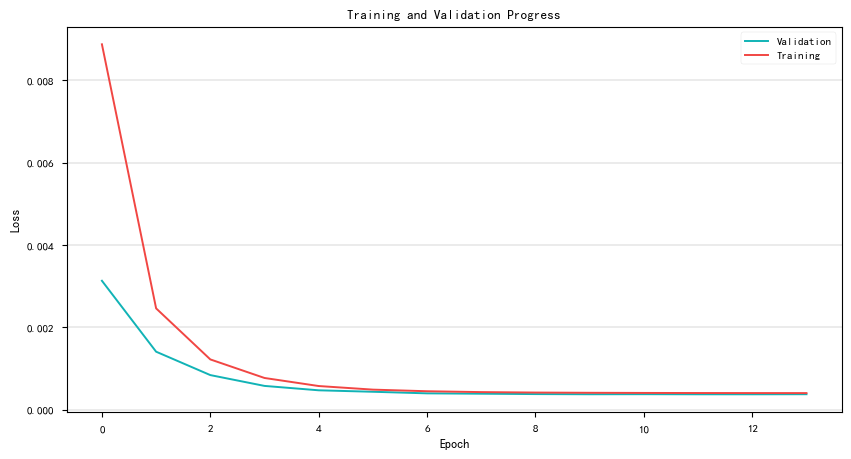

 20%|████████████████▊                                                                   | 1/5 [00:04<00:18,  4.75s/it]

Epoch [1/5], Training Loss: 0.0033, Validation Loss: 0.0015
Validation loss decreased (inf --> 0.001472).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:09<00:13,  4.53s/it]

Epoch [2/5], Training Loss: 0.0011, Validation Loss: 0.0006
Validation loss decreased (0.001472 --> 0.000605).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:13<00:09,  4.52s/it]

Epoch [3/5], Training Loss: 0.0006, Validation Loss: 0.0004
Validation loss decreased (0.000605 --> 0.000439).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:17<00:04,  4.44s/it]

Epoch [4/5], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000439 --> 0.000420).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.50s/it]

Epoch [5/5], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000420 --> 0.000410).  Saving model ...
Updating learning rate to 0.0


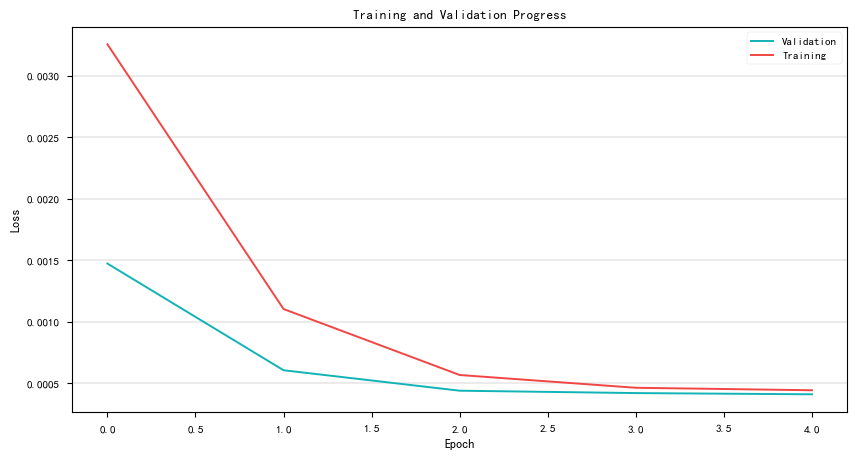

  6%|█████▏                                                                             | 1/16 [00:02<00:40,  2.72s/it]

Epoch [1/16], Training Loss: 0.0089, Validation Loss: 0.0032
Validation loss decreased (inf --> 0.003164).  Saving model ...
Updating learning rate to 0.0009903926402016153


 12%|██████████▍                                                                        | 2/16 [00:04<00:33,  2.41s/it]

Epoch [2/16], Training Loss: 0.0025, Validation Loss: 0.0014
Validation loss decreased (0.003164 --> 0.001429).  Saving model ...
Updating learning rate to 0.0009619397662556434


 19%|███████████████▌                                                                   | 3/16 [00:07<00:30,  2.34s/it]

Epoch [3/16], Training Loss: 0.0013, Validation Loss: 0.0009
Validation loss decreased (0.001429 --> 0.000855).  Saving model ...
Updating learning rate to 0.0009157348061512727


 25%|████████████████████▊                                                              | 4/16 [00:09<00:27,  2.28s/it]

Epoch [4/16], Training Loss: 0.0008, Validation Loss: 0.0006
Validation loss decreased (0.000855 --> 0.000607).  Saving model ...
Updating learning rate to 0.0008535533905932737


 31%|█████████████████████████▉                                                         | 5/16 [00:11<00:24,  2.25s/it]

Epoch [5/16], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000607 --> 0.000480).  Saving model ...
Updating learning rate to 0.0007777851165098011


 38%|███████████████████████████████▏                                                   | 6/16 [00:13<00:22,  2.21s/it]

Epoch [6/16], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000480 --> 0.000428).  Saving model ...
Updating learning rate to 0.000691341716182545


 44%|████████████████████████████████████▎                                              | 7/16 [00:15<00:20,  2.23s/it]

Epoch [7/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000428 --> 0.000398).  Saving model ...
Updating learning rate to 0.0005975451610080642


 50%|█████████████████████████████████████████▌                                         | 8/16 [00:18<00:17,  2.24s/it]

Epoch [8/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000398 --> 0.000383).  Saving model ...
Updating learning rate to 0.0005


 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:20<00:15,  2.28s/it]

Epoch [9/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000383 --> 0.000378).  Saving model ...
Updating learning rate to 0.00040245483899193594


 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:22<00:13,  2.25s/it]

Epoch [10/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000378 --> 0.000374).  Saving model ...
Updating learning rate to 0.0003086582838174551


 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:25<00:11,  2.28s/it]

Epoch [11/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00022221488349019903


 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:27<00:09,  2.38s/it]

Epoch [12/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00014644660940672628


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:30<00:07,  2.35s/it]

Epoch [13/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 3 out of 5
Updating learning rate to 8.426519384872733e-05


 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:32<00:04,  2.32s/it]

Epoch [14/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000374 --> 0.000370).  Saving model ...
Updating learning rate to 3.806023374435663e-05


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:34<00:02,  2.30s/it]

Epoch [15/16], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000370 --> 0.000370).  Saving model ...
Updating learning rate to 9.607359798384786e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:36<00:00,  2.29s/it]

Epoch [16/16], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


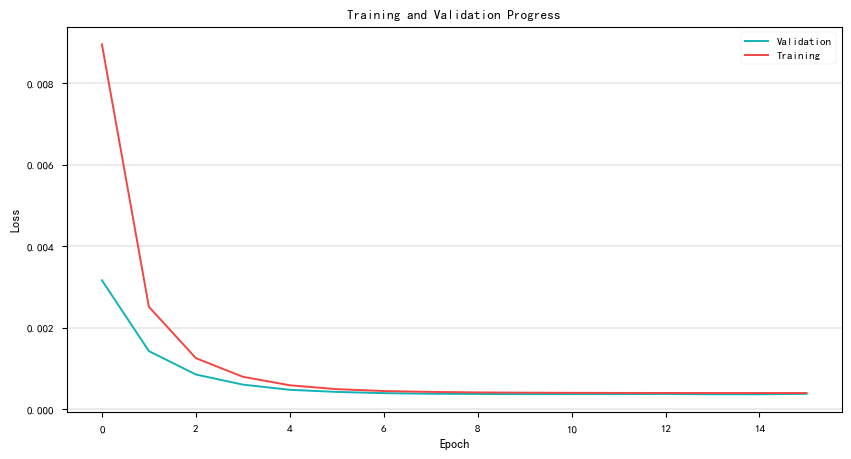

  7%|█████▌                                                                             | 1/15 [00:02<00:30,  2.20s/it]

Epoch [1/15], Training Loss: 0.0068, Validation Loss: 0.0024
Validation loss decreased (inf --> 0.002425).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:04<00:28,  2.16s/it]

Epoch [2/15], Training Loss: 0.0019, Validation Loss: 0.0012
Validation loss decreased (0.002425 --> 0.001189).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:06<00:25,  2.13s/it]

Epoch [3/15], Training Loss: 0.0010, Validation Loss: 0.0008
Validation loss decreased (0.001189 --> 0.000753).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:08<00:23,  2.11s/it]

Epoch [4/15], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000753 --> 0.000532).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:10<00:21,  2.13s/it]

Epoch [5/15], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000532 --> 0.000456).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:12<00:19,  2.13s/it]

Epoch [6/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000456 --> 0.000408).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:14<00:17,  2.13s/it]

Epoch [7/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000408 --> 0.000392).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:17<00:14,  2.12s/it]

Epoch [8/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000392 --> 0.000379).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:19<00:12,  2.11s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:21<00:10,  2.11s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000379 --> 0.000373).  Saving model ...
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:23<00:08,  2.11s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000373 --> 0.000371).  Saving model ...
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:25<00:06,  2.09s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:27<00:04,  2.08s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:29<00:02,  2.06s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000371 --> 0.000369).  Saving model ...
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.10s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


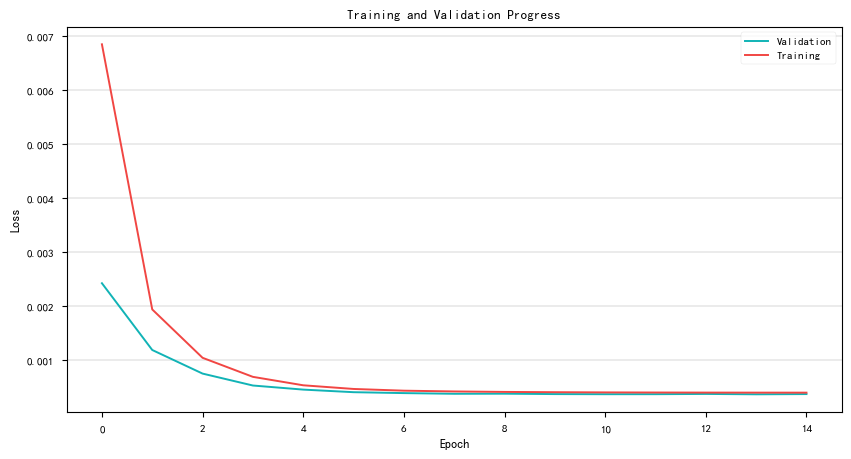

  7%|█████▌                                                                             | 1/15 [00:02<00:29,  2.10s/it]

Epoch [1/15], Training Loss: 0.0065, Validation Loss: 0.0025
Validation loss decreased (inf --> 0.002490).  Saving model ...
Updating learning rate to 0.0009890738003669028


 13%|███████████                                                                        | 2/15 [00:04<00:26,  2.07s/it]

Epoch [2/15], Training Loss: 0.0019, Validation Loss: 0.0012
Validation loss decreased (0.002490 --> 0.001177).  Saving model ...
Updating learning rate to 0.0009567727288213005


 20%|████████████████▌                                                                  | 3/15 [00:06<00:24,  2.05s/it]

Epoch [3/15], Training Loss: 0.0010, Validation Loss: 0.0007
Validation loss decreased (0.001177 --> 0.000737).  Saving model ...
Updating learning rate to 0.0009045084971874737


 27%|██████████████████████▏                                                            | 4/15 [00:08<00:22,  2.03s/it]

Epoch [4/15], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000737 --> 0.000545).  Saving model ...
Updating learning rate to 0.0008345653031794292


 33%|███████████████████████████▋                                                       | 5/15 [00:10<00:20,  2.08s/it]

Epoch [5/15], Training Loss: 0.0005, Validation Loss: 0.0005
Validation loss decreased (0.000545 --> 0.000460).  Saving model ...
Updating learning rate to 0.00075


 40%|█████████████████████████████████▏                                                 | 6/15 [00:12<00:18,  2.11s/it]

Epoch [6/15], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000460 --> 0.000417).  Saving model ...
Updating learning rate to 0.0006545084971874737


 47%|██████████████████████████████████████▋                                            | 7/15 [00:14<00:16,  2.10s/it]

Epoch [7/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000417 --> 0.000397).  Saving model ...
Updating learning rate to 0.0005522642316338268


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:16<00:14,  2.11s/it]

Epoch [8/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000397 --> 0.000387).  Saving model ...
Updating learning rate to 0.00044773576836617336


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [00:18<00:12,  2.12s/it]

Epoch [9/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000387 --> 0.000383).  Saving model ...
Updating learning rate to 0.00034549150281252633


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [00:20<00:10,  2.12s/it]

Epoch [10/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000383 --> 0.000373).  Saving model ...
Updating learning rate to 0.0002500000000000001


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [00:23<00:08,  2.21s/it]

Epoch [11/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00016543469682057105


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [00:25<00:06,  2.26s/it]

Epoch [12/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 9.549150281252633e-05


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [00:27<00:04,  2.23s/it]

Epoch [13/15], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000373 --> 0.000370).  Saving model ...
Updating learning rate to 4.322727117869951e-05


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:30<00:02,  2.27s/it]

Epoch [14/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 1.0926199633097156e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:32<00:00,  2.16s/it]

Epoch [15/15], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0


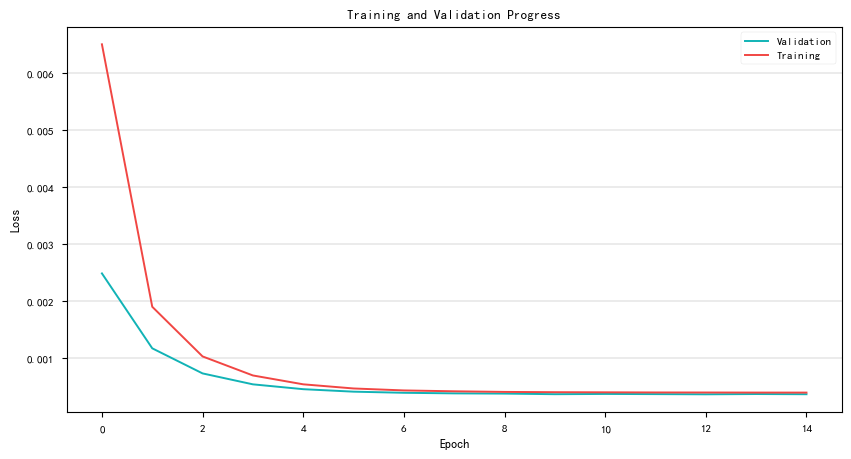

  7%|█████▉                                                                             | 1/14 [00:02<00:29,  2.28s/it]

Epoch [1/14], Training Loss: 0.0112, Validation Loss: 0.0039
Validation loss decreased (inf --> 0.003850).  Saving model ...
Updating learning rate to 0.0009874639560909118


 14%|███████████▊                                                                       | 2/14 [00:04<00:28,  2.35s/it]

Epoch [2/14], Training Loss: 0.0031, Validation Loss: 0.0017
Validation loss decreased (0.003850 --> 0.001713).  Saving model ...
Updating learning rate to 0.0009504844339512095


 21%|█████████████████▊                                                                 | 3/14 [00:06<00:25,  2.30s/it]

Epoch [3/14], Training Loss: 0.0015, Validation Loss: 0.0010
Validation loss decreased (0.001713 --> 0.000956).  Saving model ...
Updating learning rate to 0.000890915741234015


 29%|███████████████████████▋                                                           | 4/14 [00:09<00:23,  2.30s/it]

Epoch [4/14], Training Loss: 0.0009, Validation Loss: 0.0006
Validation loss decreased (0.000956 --> 0.000640).  Saving model ...
Updating learning rate to 0.0008117449009293668


 36%|█████████████████████████████▋                                                     | 5/14 [00:11<00:20,  2.27s/it]

Epoch [5/14], Training Loss: 0.0006, Validation Loss: 0.0005
Validation loss decreased (0.000640 --> 0.000500).  Saving model ...
Updating learning rate to 0.0007169418695587791


 43%|███████████████████████████████████▌                                               | 6/14 [00:13<00:17,  2.22s/it]

Epoch [6/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000500 --> 0.000432).  Saving model ...
Updating learning rate to 0.0006112604669781572


 50%|█████████████████████████████████████████▌                                         | 7/14 [00:15<00:15,  2.18s/it]

Epoch [7/14], Training Loss: 0.0005, Validation Loss: 0.0004
Validation loss decreased (0.000432 --> 0.000402).  Saving model ...
Updating learning rate to 0.0005


 57%|███████████████████████████████████████████████▍                                   | 8/14 [00:17<00:13,  2.18s/it]

Epoch [8/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000402 --> 0.000389).  Saving model ...
Updating learning rate to 0.00038873953302184284


 64%|█████████████████████████████████████████████████████▎                             | 9/14 [00:19<00:10,  2.17s/it]

Epoch [9/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00028305813044122096


 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [00:22<00:08,  2.18s/it]

Epoch [10/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000389 --> 0.000376).  Saving model ...
Updating learning rate to 0.00018825509907063325


 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [00:24<00:06,  2.15s/it]

Epoch [11/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00010908425876598516


 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [00:26<00:04,  2.12s/it]

Epoch [12/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000376 --> 0.000376).  Saving model ...
Updating learning rate to 4.9515566048790485e-05


 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [00:28<00:02,  2.09s/it]

Epoch [13/14], Training Loss: 0.0004, Validation Loss: 0.0004
Validation loss decreased (0.000376 --> 0.000373).  Saving model ...
Updating learning rate to 1.2536043909088191e-05


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:30<00:00,  2.17s/it]

Epoch [14/14], Training Loss: 0.0004, Validation Loss: 0.0004
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0


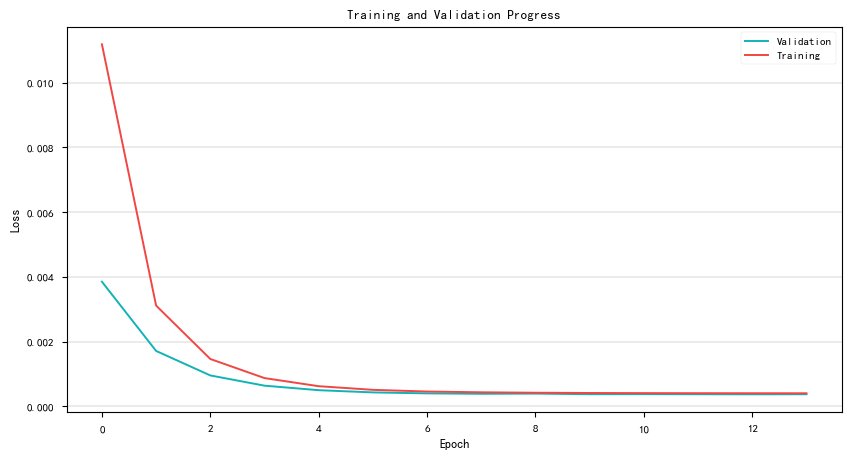

 20%|████████████████▊                                                                   | 1/5 [00:03<00:15,  4.00s/it]

Epoch [1/5], Training Loss: 0.1046, Validation Loss: 0.0135
Validation loss decreased (inf --> 0.013511).  Saving model ...
Updating learning rate to 0.0009045084971874737


 40%|█████████████████████████████████▌                                                  | 2/5 [00:08<00:12,  4.28s/it]

Epoch [2/5], Training Loss: 0.0088, Validation Loss: 0.0031
Validation loss decreased (0.013511 --> 0.003060).  Saving model ...
Updating learning rate to 0.0006545084971874737


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:12<00:08,  4.39s/it]

Epoch [3/5], Training Loss: 0.0021, Validation Loss: 0.0009
Validation loss decreased (0.003060 --> 0.000914).  Saving model ...
Updating learning rate to 0.00034549150281252633


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:17<00:04,  4.51s/it]

Epoch [4/5], Training Loss: 0.0009, Validation Loss: 0.0006
Validation loss decreased (0.000914 --> 0.000596).  Saving model ...
Updating learning rate to 9.549150281252633e-05


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]

Epoch [5/5], Training Loss: 0.0007, Validation Loss: 0.0005
Validation loss decreased (0.000596 --> 0.000545).  Saving model ...
Updating learning rate to 0.0


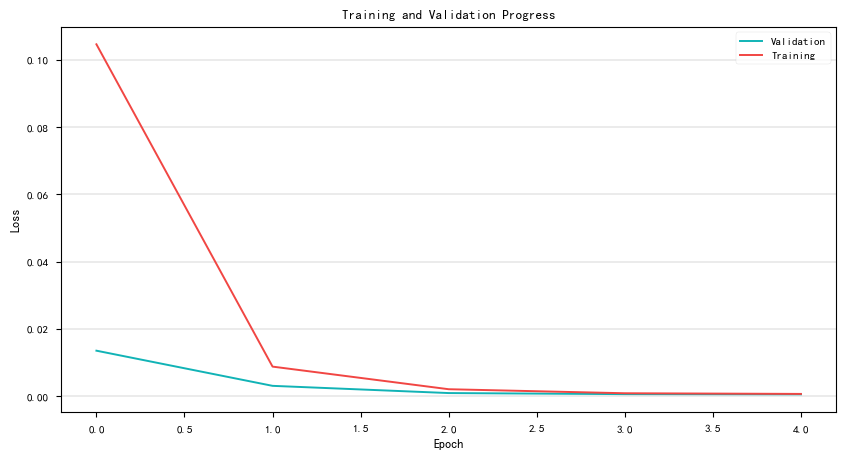

In [22]:
import SSA # 加载本地算法

# 构造参数字典
ssa_args = {
    "pop": 5, # 种群数量，需遍历
    "dim": 4, # 优化参数维度
    "lb": np.array([3, 1, 16, 5]), # 下边界，分别为回视窗口、预测维度、批量大小、迭代次数
    "ub": np.array([20, 3, 64, 20]), # 上边界，分别为回视窗口、预测维度、批量大小、迭代次数
    "fun": fitness, # 适应度函数，最小化问题
    "Max_iter": 2, # 最大迭代次数，需遍历
}

#函数传参，运行次数：pop*Max_iter*n_epochs
GbestScore, GbestPositon, Curve = SSA.SSA(**ssa_args)

In [23]:
x1, x2, x3, x4 = GbestPositon[0]
print('最优适应度值：',GbestScore)
print('最优解[回视窗口]：', int(x1))
print('最优解[预测维度]：', int(x2))
print('最优解[批量大小]：', int(x3))
print('最优解[迭代次数]：', int(x4))

最优适应度值： [0.00036953]
最优解[回视窗口]： 10
最优解[预测维度]： 1
最优解[批量大小]： 34
最优解[迭代次数]： 16


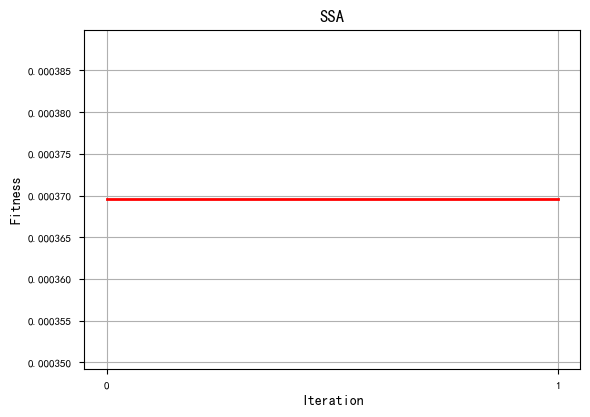

In [24]:
#绘制适应度曲线
plt.figure(1)
plt.plot(Curve,'r-',linewidth=2)
# 设置X轴刻度为整数
plt.locator_params(axis='x', integer=True)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("Fitness",fontsize='medium')
plt.grid()
plt.title('SSA',fontsize='large')
plt.show()